<a href="https://colab.research.google.com/github/AgadaOlshtein/simulation-project/blob/main/Simulation%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation water park

מבנה הקוד:
1. אלגוריתמי דגימה
2. ישויות
3. מתקנים
4. ה"main" הסימולציה עצמה



In [ ]:
#imports block
import math
import heapq
import pandas as pd
import numpy as np
import random
from sympy import symbols, Eq, solve
from scipy.optimize import root_scalar
from IPython.display import display, HTML
from scipy.stats import probplot
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import truncnorm
from datetime import timedelta, datetime, time
from contextlib import closing
import heapq
from enum import Enum
from datetime import timedelta

# Sampling_Algorithms class

<div dir="rtl" >

# מחלקת אלגוריתמי דגימה (Sampling Algorithms)

 המחלקה מרכזת את המימוש של כל אלגוריתמי הדגימה הנדרשים בפרויקט, שבעזרתם ניצור את  המשתנים המקריים במערכת – מהגעת המבקרים ועד לקביעת משך השהייה במתקנים.

  כלל הדגימות מבוססות על מספרים אקראיים בטווח $[0,1]$ המופקים על ידי  הפונקציה sample_uniform שמממשת התפלגות אחידה רציפה.

   במחלקה זו יישמנו שלוש שיטות דגימה מרכזיות:


*   שיטת הטרנספורם ההופכי (Inverse Transform): משמשת לדגימה מהתפלגויות מעריכית ואחידה, וכן עבור פונקציות צפיפות מורכבות (כמו בבריכת הקטנטנים) שדרשו פיתוח ידני של הנוסחה ההופכית.
*   אלגוריתם בוקס-מולר (Box-Muller): משמש ליצירת משתנים המתפלגים נורמלית (כגון משך הגלישה במגלשה הגדולה), תוך שילוב בדיקת חיוביות לערכים המתקבלים

*   שיטת קבלה-דחייה (Acceptance-Rejection): יושמה עבור בריכת הגלים כנדרש בפרויקט.

המחלקה מפרידה בין הלוגיקה המתמטית לבין הרצת הסימולציה עצמה, ומספקת למערכת את כל
המידע הסטוכסטי הדרוש לניהול פארק המים.

</div>

In [ ]:
import math
import random


class Sampling_Algorithms:
    """
    Collection of sampling algorithms for simulation.
    Implements various probability distributions using:
    - Inverse Transform Method
    - Box-Muller Transform (for normal distribution)
    - Acceptance-Rejection Algorithm
    - Composition Method
    """

    # ============================================
    # BASIC MATHEMATICAL ALGORITHMS
    # ============================================

    @staticmethod
    def sample_uniform(a, b):
        """
        Sample from Uniform(a, b) using inverse transform method.

        Args:
            a: Lower bound
            b: Upper bound

        Returns:
            Random value in [a, b]
        """
        u = random.random()  # U(0,1)
        return a + (b - a) * u

    @staticmethod
    def sample_exponential(lambda_param):
        """
        Sample from Exponential(lambda) using inverse transform method.

        Args:
            lambda_param: Rate parameter (λ)

        Returns:
            Random value from exponential distribution
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return -math.log(1 - u) / lambda_param

    @staticmethod
    def sample_normal(mu, sigma):
        """
        Sample from Normal(mu, sigma) using Box-Muller transform.

        Args:
            mu: Mean
            sigma: Standard deviation

        Returns:
            Random value from normal distribution
        """
        u1 = Sampling_Algorithms.sample_uniform(0, 1)
        u2 = Sampling_Algorithms.sample_uniform(0, 1)
        z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        return mu + sigma * z

    # ============================================
    # VISITOR GENERATION
    # ============================================

    @staticmethod
    def get_number_kids():
        """
        Sample number of kids in family.
        Distribution: Discrete Uniform[1,5]

        Returns:
            Number of kids (1-5, equal probability)
        """
        u = random.random()
        if u < 0.2:
            return 1
        elif u < 0.4:
            return 2
        elif u < 0.6:
            return 3
        elif u < 0.8:
            return 4
        else:
            return 5

    @staticmethod
    def get_kid_age():
        """
        Sample kid age.
        Distribution: Continuous Uniform[2,18]

        Returns:
            Kid age in years (continuous, 2-18)
        """
        return Sampling_Algorithms.sample_uniform(2, 18)

    @staticmethod
    def sample_family_interarrival_time():
        """
        Sample time between family arrivals.
        Distribution: Exponential with rate 40/hour

        Returns:
            Inter-arrival time in MINUTES
            Mean = 1.5 minutes
        """
        # Rate = 40 per hour = 40/60 per minute = 2/3 per minute
        # Mean time between arrivals = 60/40 = 1.5 minutes
        return Sampling_Algorithms.sample_exponential(40 / 60)

    @staticmethod
    def get_family_departure_time():
        """
        Sample family departure time using inverse transform.
        PDF: f(x) = (2/9)(x-16), 16 ≤ x ≤ 19

        Returns:
            Departure hour (16.0 to 19.0)
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return 3 * math.sqrt(u) + 16

    @staticmethod
    def get_teen_group_size():
        """
        Sample teen group size.
        Distribution:
        - P(2-3) = 0.4
        - P(4-5) = 0.5
        - P(6) = 0.1

        Returns:
            Group size (2-6 people)
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        if u <= 0.2:
            return 2
        elif u <= 0.4:
            return 3
        elif u <= 0.65:
            return 4
        elif u <= 0.9:
            return 5
        else:
            return 6

    @staticmethod
    def sample_teens_group_interarrival_time():
        """
        Sample time between teen group arrivals.
        Distribution: Exponential with 500 groups/day on average
        Day = 6 hours (10:00-16:00) = 360 minutes

        Returns:
            Inter-arrival time in MINUTES
        """
        return Sampling_Algorithms.sample_exponential(500 / 360)

    @staticmethod
    def sample_single_visitor_interarrival_time():
        """
        Sample time between single visitor arrivals.
        Distribution: Exponential with rate 10 per 15 minutes = 40/hour

        Returns:
            Inter-arrival time in MINUTES
        """
        return Sampling_Algorithms.sample_exponential(40 / 60)

    @staticmethod
    def should_buy_express_on_entry():
        """
        Determine if visitor buys express pass on entry.
        Probability: 0.25

        Returns:
            True if buying express pass, False otherwise
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return u <= 0.25

    # ============================================
    # FACILITY ACTIVITY DURATIONS
    # ============================================

    @staticmethod
    def pipes_river_duration():
        """
        Sample Pipes River activity duration.
        Distribution: Uniform[20, 30] minutes

        Returns:
            Activity duration in minutes
        """
        return Sampling_Algorithms.sample_uniform(20, 30)

    @staticmethod
    def sample_big_pipes_slide_duration():
        """
        Sample Big Pipes Slide duration.
        Distribution: Normal(μ=4.8, σ=1.8322)
        Parameters from Maximum Likelihood Estimation

        Returns:
            Slide duration in minutes
        """
        mu = 4.8
        sigma = 1.8322
        return Sampling_Algorithms.sample_normal(mu, sigma)

    @staticmethod
    def sample_small_pipes_slide_duration():
        """
        Sample Small Pipes Slide duration.
        Distribution: Exponential(λ=2.10706)
        Parameter from Maximum Likelihood Estimation

        Returns:
            Slide duration in minutes
        """
        lambda_param = 2.10706
        return Sampling_Algorithms.sample_exponential(lambda_param)

    # ============================================
    # COMPLEX SAMPLING ALGORITHMS
    # ============================================

    @staticmethod
    def get_wave_pool_duration():
        """
        Sample Wave Pool duration using Acceptance-Rejection algorithm.

        PDF:
        - f(x) = x/2700, 0 ≤ x ≤ 10
        - f(x) = 0, 10 < x < 30
        - f(x) = (60-x)/2700 + 1/30, 30 ≤ x ≤ 50
        - f(x) = (60-x)/2700, 50 < x ≤ 60

        Returns:
            Pool duration in minutes
        """
        # Maximum of f(x)
        M = 2.0 / 45.0

        while True:
            # Generate candidate
            x = Sampling_Algorithms.sample_uniform(0, 60)

            # Evaluate PDF at x
            if 0 <= x <= 10:
                f_x = x / 2700.0
            elif 10 < x < 30:
                f_x = 0
            elif 30 <= x <= 50:
                f_x = (60 - x) / 2700.0 + 1.0 / 30.0
            elif 50 < x <= 60:
                f_x = (60 - x) / 2700.0
            else:
                f_x = 0

            # Accept/reject
            u = Sampling_Algorithms.sample_uniform(0, 1)
            if u <= f_x / M:
                return x

    @staticmethod
    def sample_kids_pool_duration():
        """
        Sample Kids Pool stay duration using inverse transform.

        PDF (piecewise):
        - f(x) = 16/3(x-1), 1 ≤ x < 1.25
        - f(x) = 4/3, 1.25 ≤ x < 1.75
        - f(x) = 16/3(2-x), 1.75 ≤ x ≤ 2

        Formula is in hours, result returned in minutes.

        Returns:
            Pool duration in minutes
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)

        # Select formula part based on u value
        if 0 <= u < 1 / 6:
            # First range (1 to 1.25 hours)
            duration_hours = 1 + math.sqrt((3 * u) / 8)

        elif 1 / 6 <= u < 5 / 6:
            # Middle range (1.25 to 1.75 hours)
            duration_hours = 0.75 * u + 1.125

        else:
            # Last range (1.75 to 2 hours)
            duration_hours = 2 - math.sqrt((3 * (1 - u)) / 8)

        # Convert hours to minutes
        return duration_hours * 60

    # ============================================
    # ADDITIONAL SAMPLING METHODS
    # ============================================

    @staticmethod
    def sample_ticket_purchase_time():
        """
        Sample ticket purchase duration.
        Distribution: Uniform[0.5, 2] minutes

        Returns:
            Purchase time in minutes
        """
        return Sampling_Algorithms.sample_uniform(0.5, 2)

    @staticmethod
    def sample_wristband_time():
        """
        Sample wristband reception duration.
        Distribution: Exponential(mean=2 minutes)

        Returns:
            Reception time in minutes
        """
        return Sampling_Algorithms.sample_exponential(1.0 / 2.0)

    @staticmethod
    def sample_restaurant_service_time():
        """
        Sample restaurant service duration.
        Distribution: Normal(μ=5, σ=1.5) minutes

        Returns:
            Service time in minutes
        """
        return Sampling_Algorithms.sample_normal(5, 1.5)

    @staticmethod
    def sample_meal_duration():
        """
        Sample meal eating duration.
        Distribution: Uniform[15, 35] minutes

        Returns:
            Eating duration in minutes
        """
        return Sampling_Algorithms.sample_uniform(15, 35)

    @staticmethod
    def sample_snorkel_tour_duration():
        """
        Sample snorkel tour duration.
        Distribution: Normal(μ=30, σ=10) minutes

        Returns:
            Tour duration in minutes
        """
        return Sampling_Algorithms.sample_normal(30, 10)

    # ============================================
    # VISITOR BEHAVIOR & DECISION-MAKING
    # ============================================

    @staticmethod
    def should_teens_buy_express_after_abandon():
        """
        Determine if teen group buys express pass after abandoning queue.
        Probability: 0.6

        Returns:
            True if buying express pass, False otherwise
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return u <= 0.6

    @staticmethod
    def had_good_experience():
        """
        Determine if visitor had good experience at attraction.
        Probability: 0.5

        Returns:
            True if good experience, False otherwise
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return u <= 0.5

    @staticmethod
    def calculate_positive_rating(group_size, adrenaline_level):
        """
        Calculate rating increase after good experience.

        Formula: score = (GS-1)/5 * 0.3 + (A-1)/4 * 0.7

        Args:
            group_size: Number of people in group (GS)
            adrenaline_level: Facility adrenaline level 1-5 (A)

        Returns:
            Rating increase value
        """
        return ((group_size - 1) / 5.0) * 0.3 + ((adrenaline_level - 1) / 4.0) * 0.7

    @staticmethod
    def should_eat_lunch():
        """
        Determine if visitor chooses to eat lunch.
        Probability: 0.7

        Returns:
            True if eating lunch, False otherwise
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return u <= 0.7

    @staticmethod
    def choose_restaurant():
        """
        Choose restaurant based on visitor preferences.

        Distribution:
        - 3/8 (37.5%) → Burger
        - 1/4 (25%) → Pizza
        - 3/8 (37.5%) → Salad

        Returns:
            Restaurant choice: "burger", "pizza", or "salad"
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        if u < 3.0 / 8.0:
            return "burger"
        elif u < 3.0 / 8.0 + 1.0 / 4.0:
            return "pizza"
        else:
            return "salad"

    @staticmethod
    def is_meal_unsatisfactory():
        """
        Determine if meal is unsatisfactory.
        Probability: 0.1 (leads to rating -0.8)

        Returns:
            True if meal unsatisfactory, False otherwise
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return u <= 0.1

    @staticmethod
    def get_photo_purchase_decision(final_rating):
        """
        Determine photo package purchase based on final park rating.

        Rating tiers:
        - < 6: No purchase
        - 6-7.5: 1 photo (20₪)
        - 7.5-8.5: 10 photos (100₪)
        - 8.5+: 10 photos + video (120₪)

        Args:
            final_rating: Visitor's final park rating (0-10)

        Returns:
            (package_type, price) tuple
        """
        if final_rating < 6:
            return None, 0
        elif final_rating < 7.5:
            return "1_photo", 20
        elif final_rating < 8.5:
            return "10_photos", 100
        else:
            return "10_photos_video", 120

    @staticmethod
    def should_family_split():
        """
        Determine if family splits into subgroups.
        Probability: 0.6

        Returns:
            True if splitting, False otherwise
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return u <= 0.6

    @staticmethod
    def get_num_split_groups():
        """
        Determine number of groups if family splits.
        Distribution: 2 or 3 groups (equal probability)

        Returns:
            Number of subgroups (2 or 3)
        """
        u = Sampling_Algorithms.sample_uniform(0, 1)
        return 2 if u <= 0.5 else 3

## אלגוריתם דגימה התפלגות אחידה בדידה רציפה:

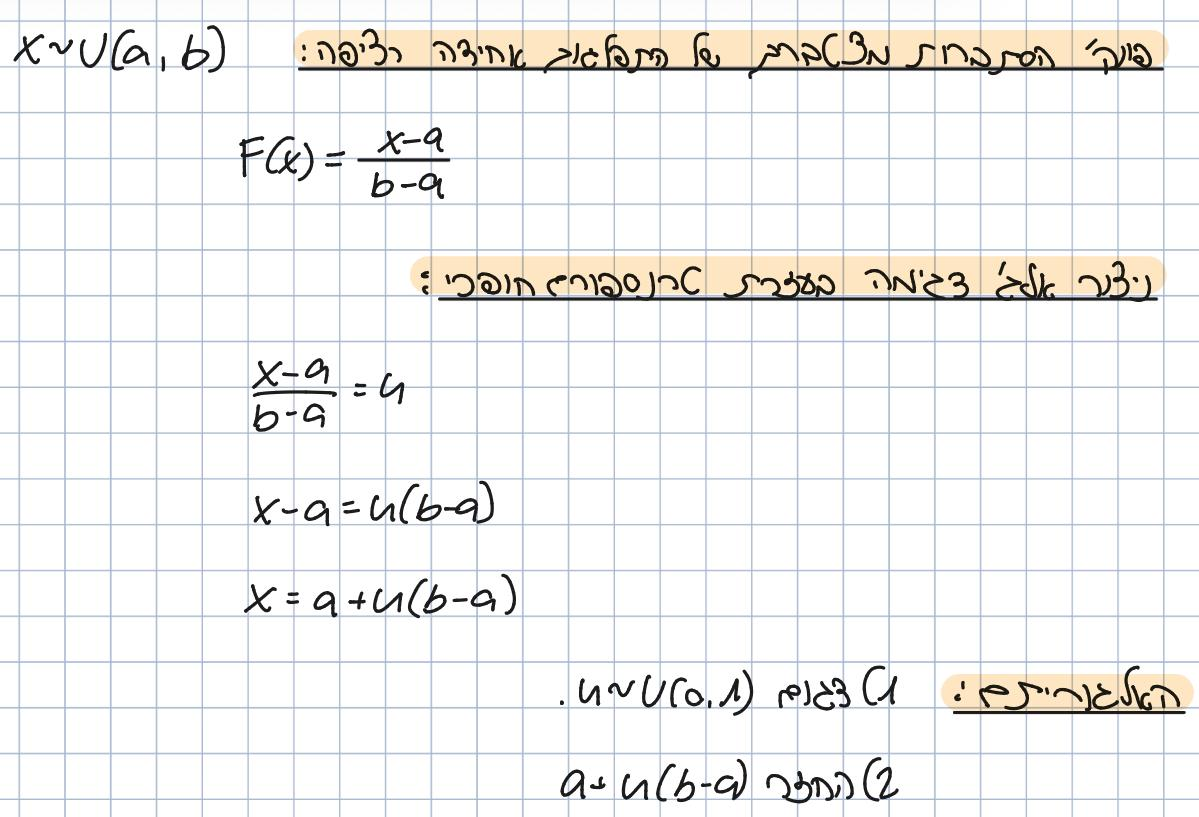

##אלגוריתם דגימה התפלגות אקספוננציאלית:

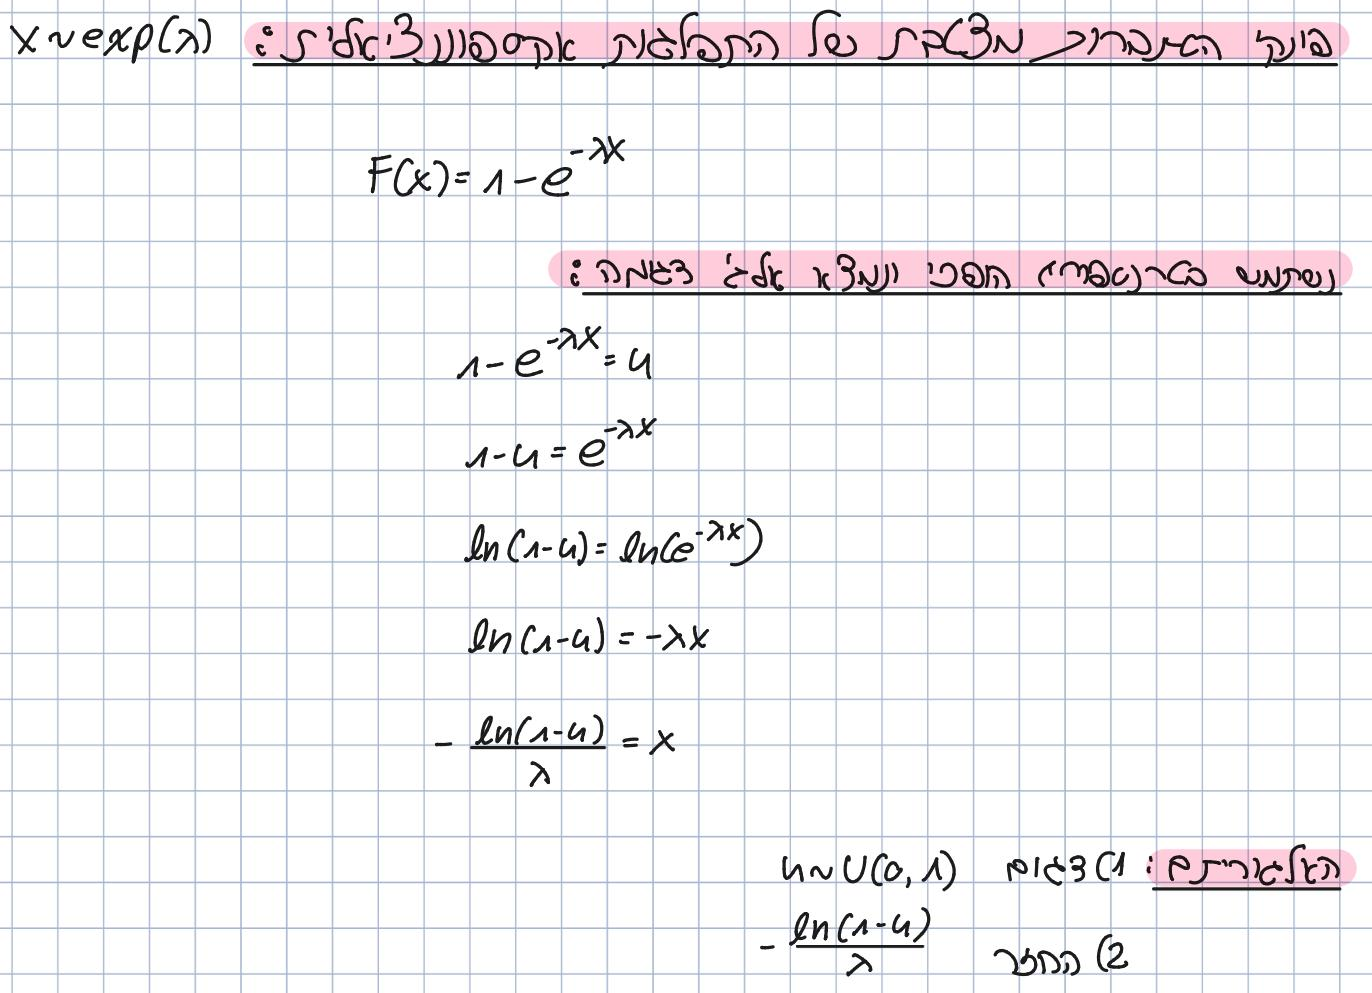

## אלגוריתם דגימה זמן עזיבת משפחה:

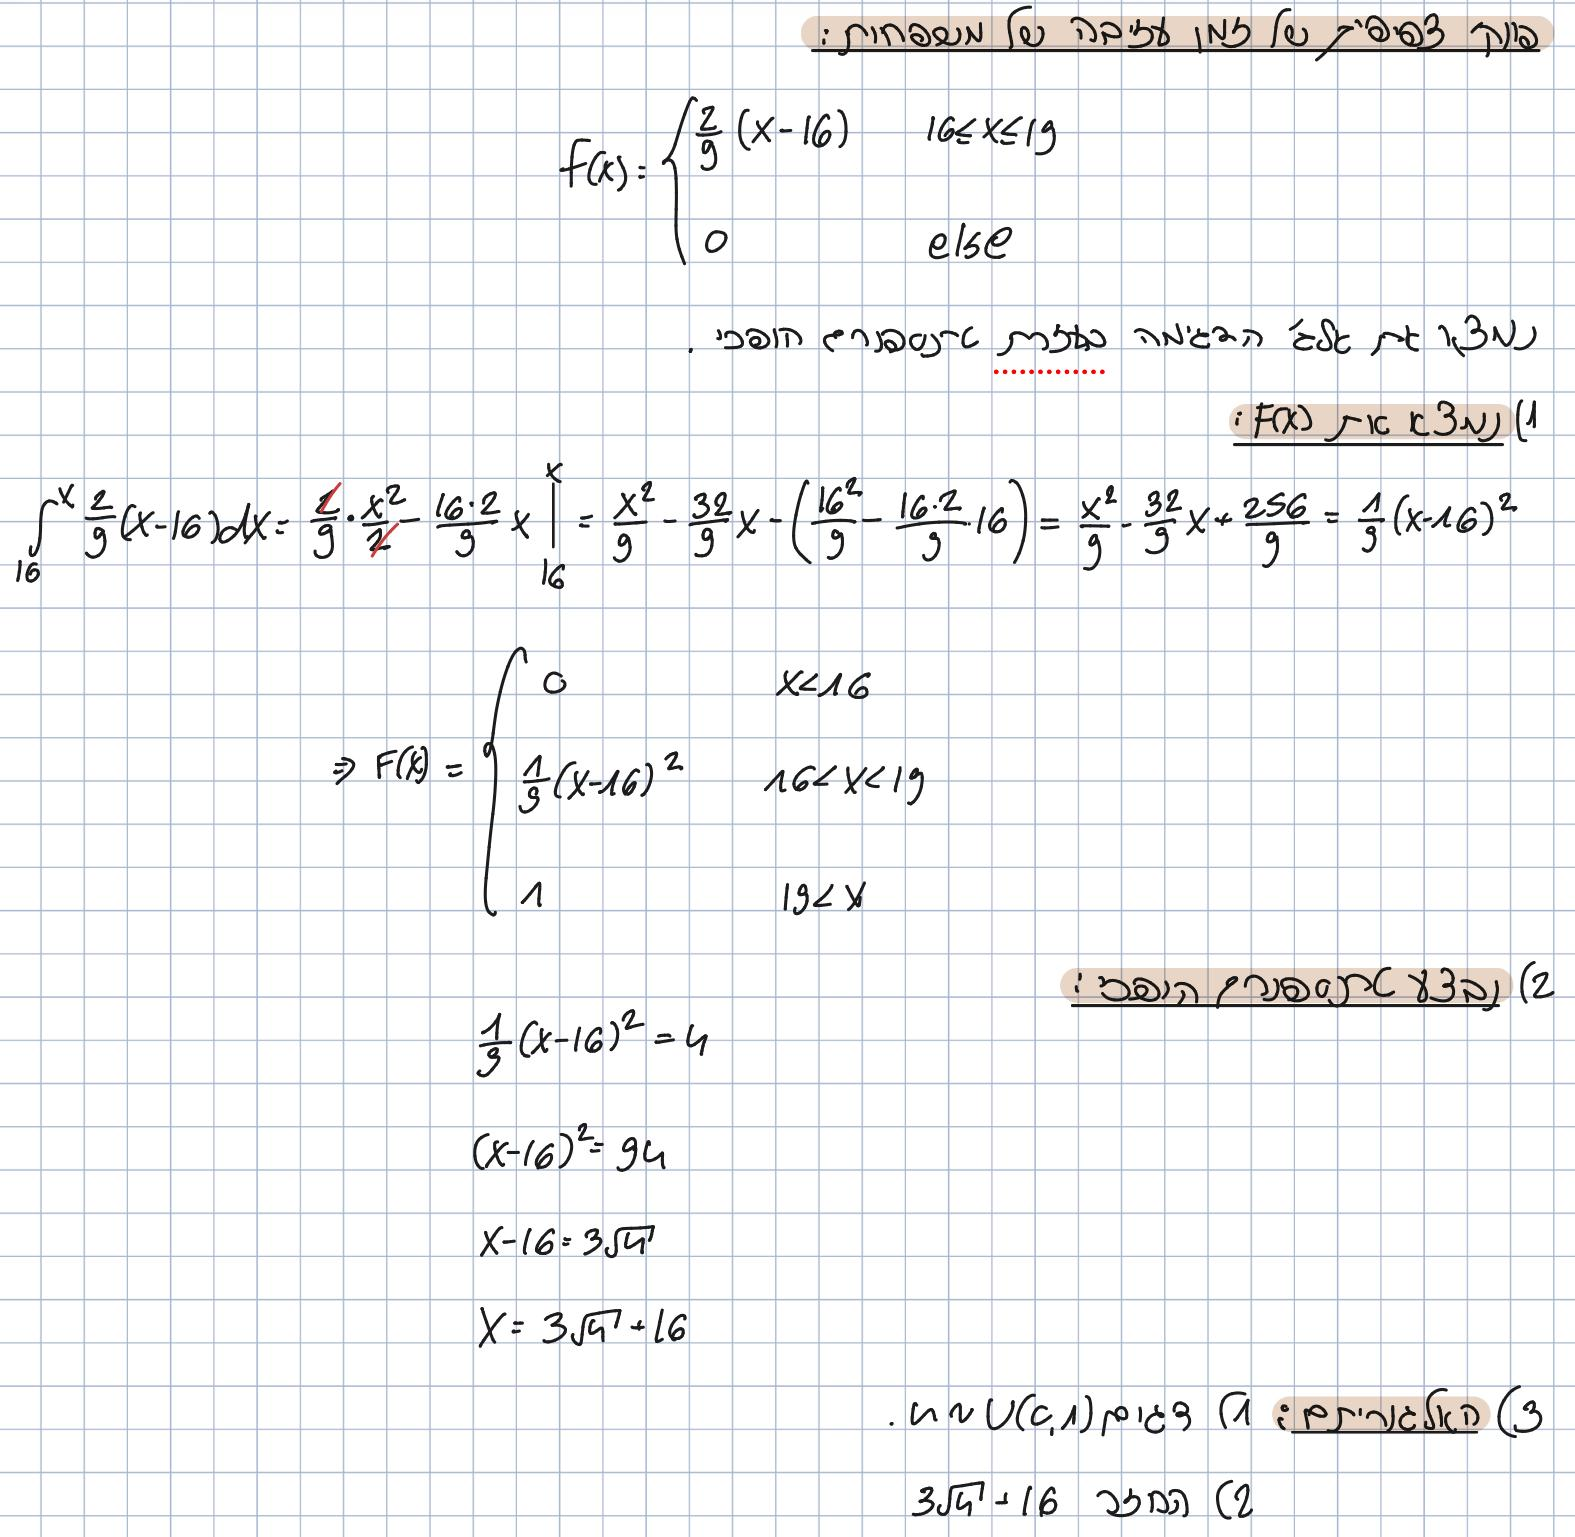

## אלגוריתם דגימה משך בריכת קטנטנים:

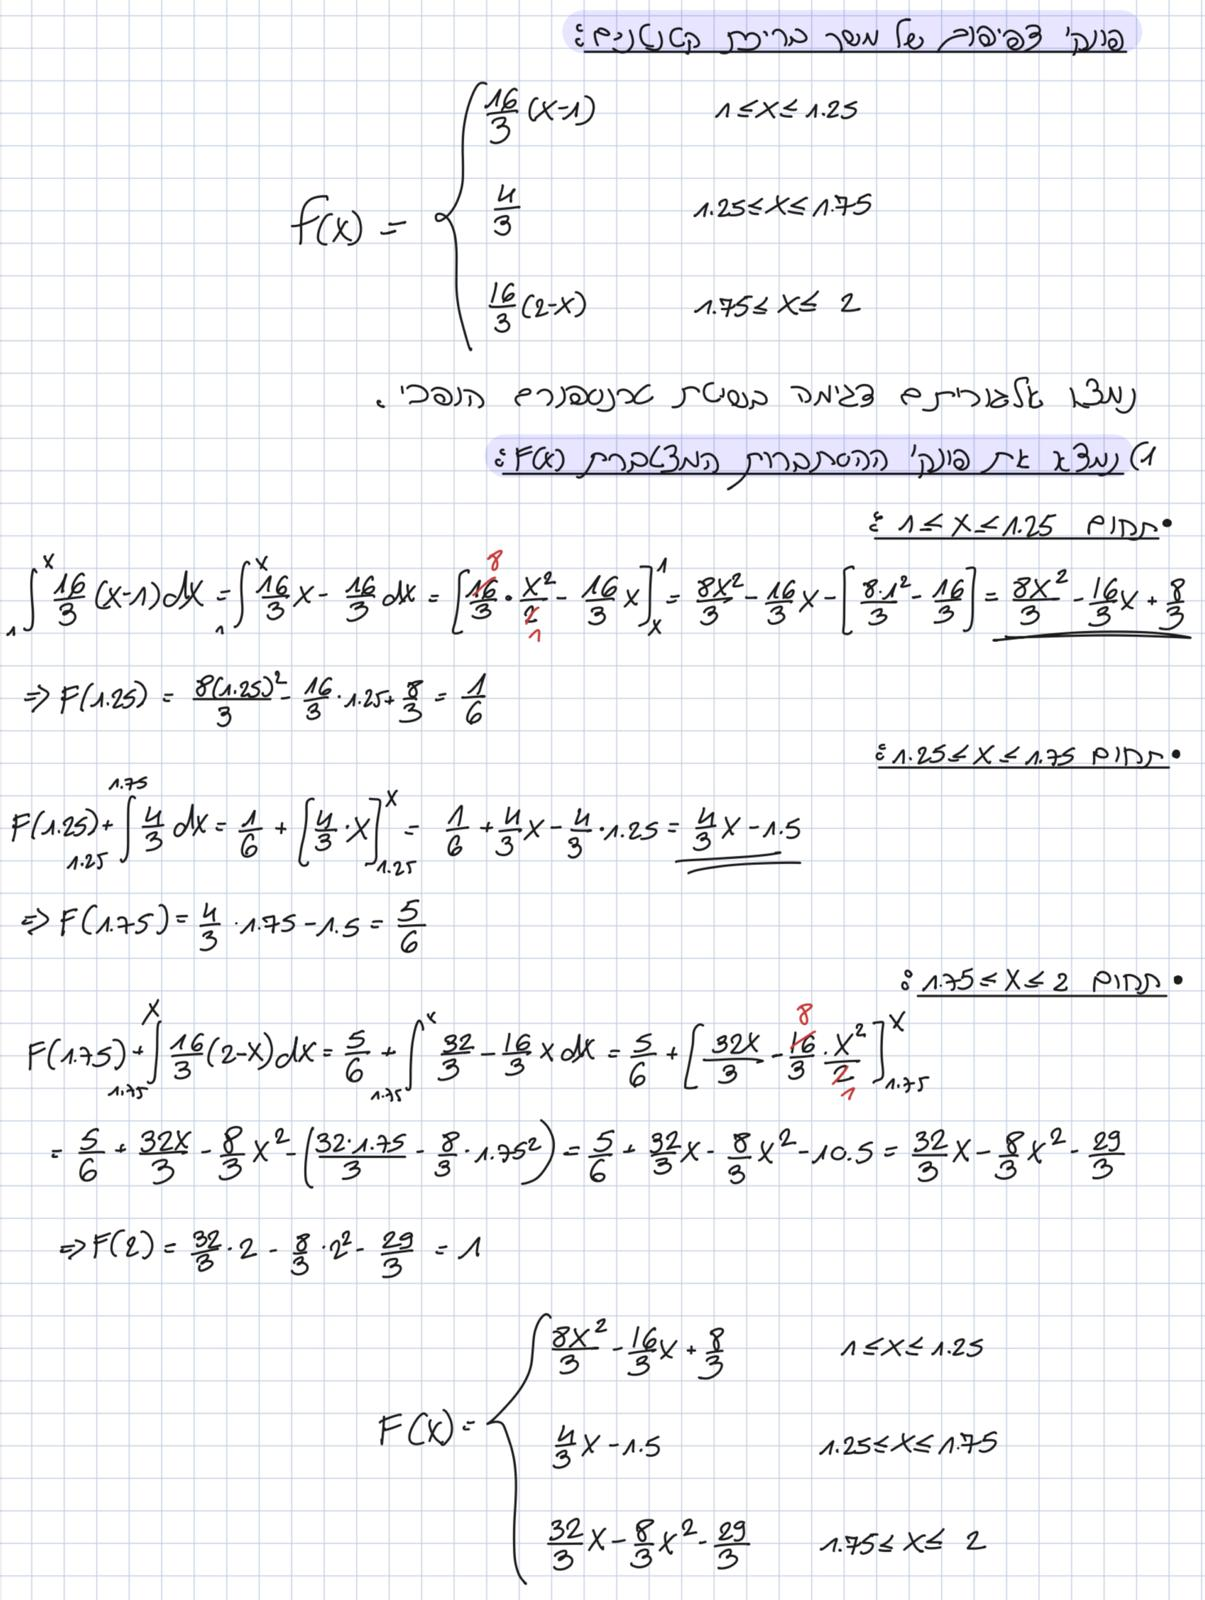

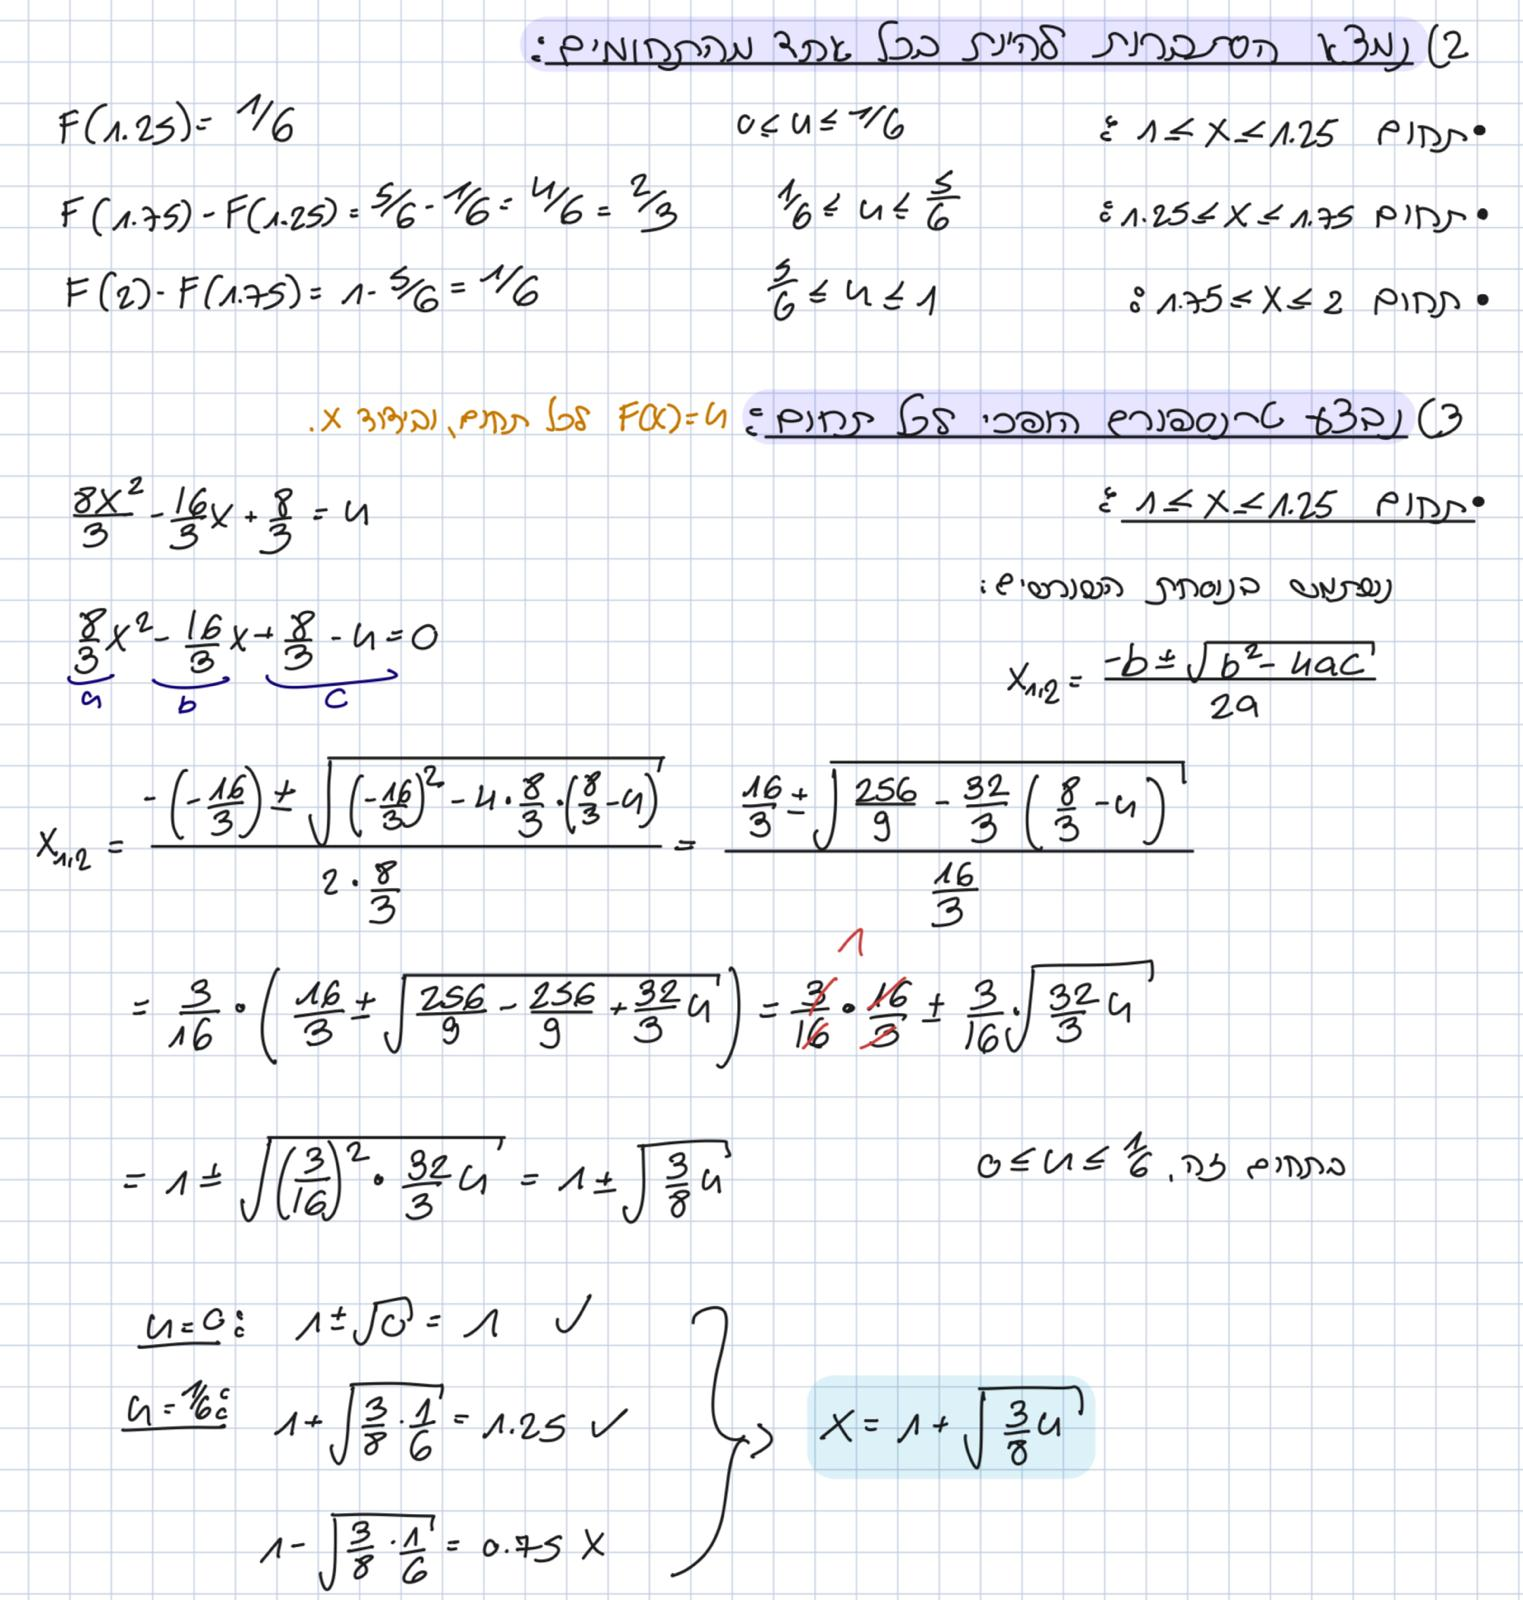

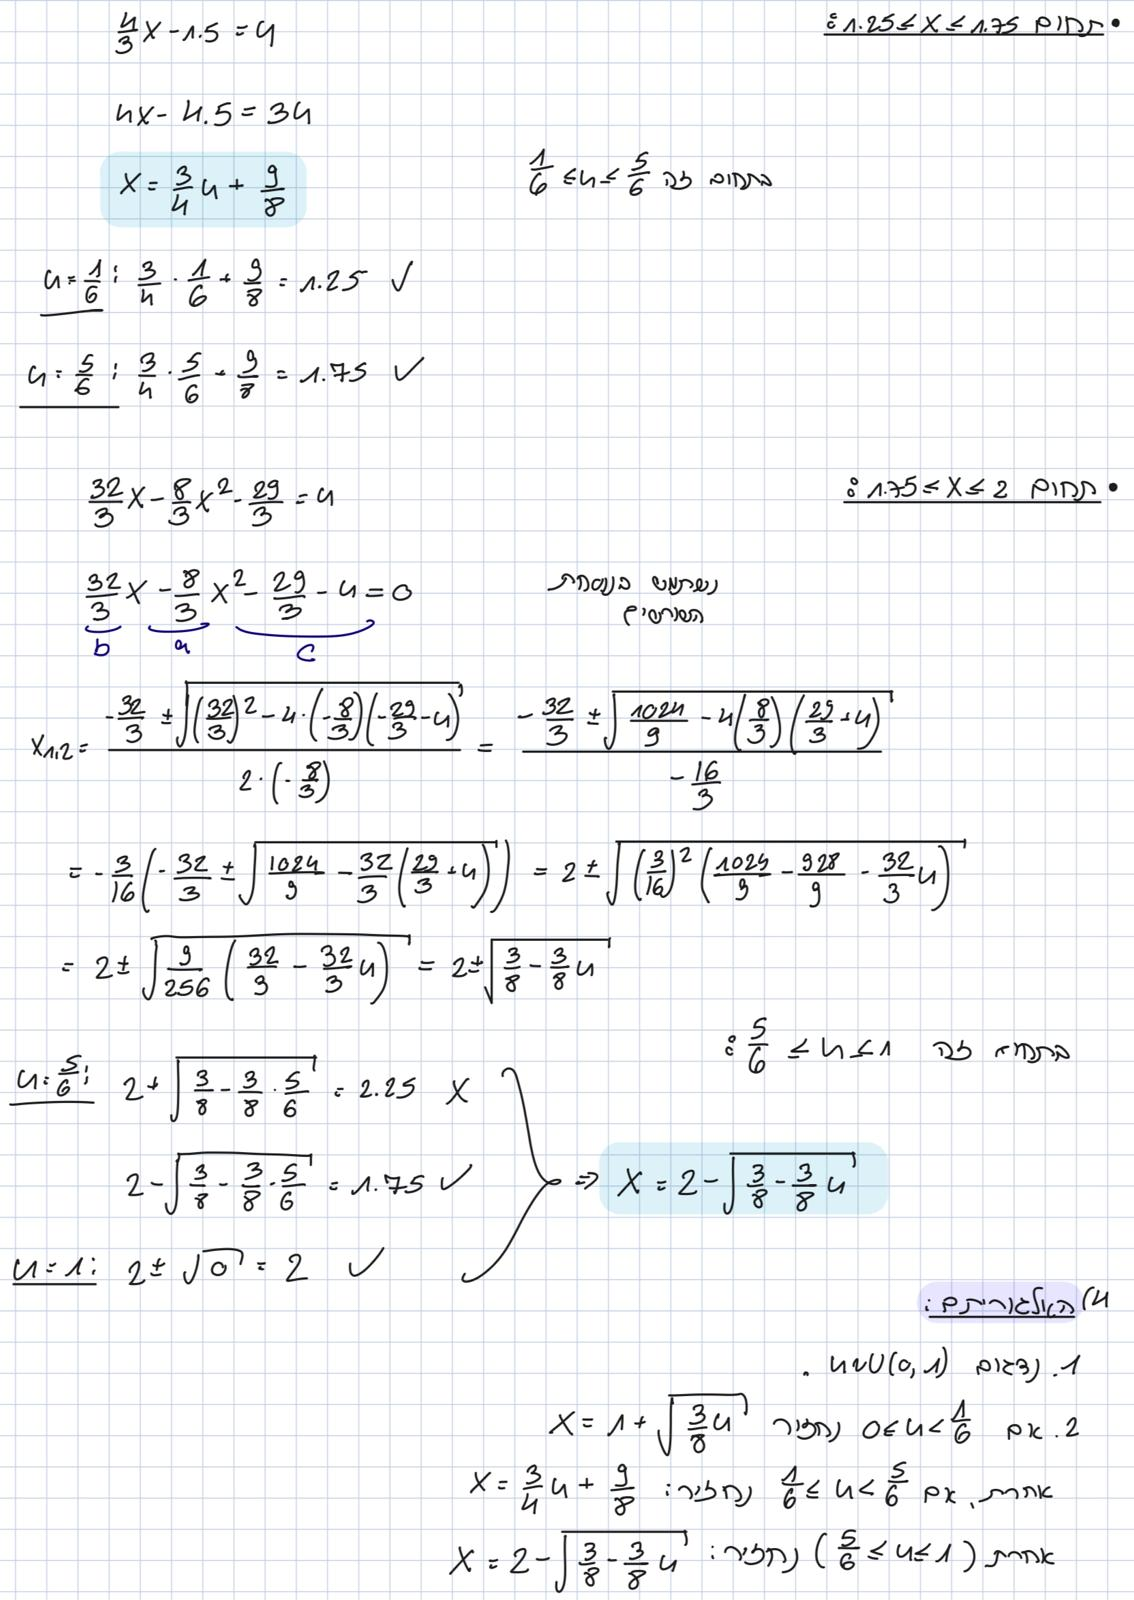

##אלגוריתם דגימה משך בריכת גלים:

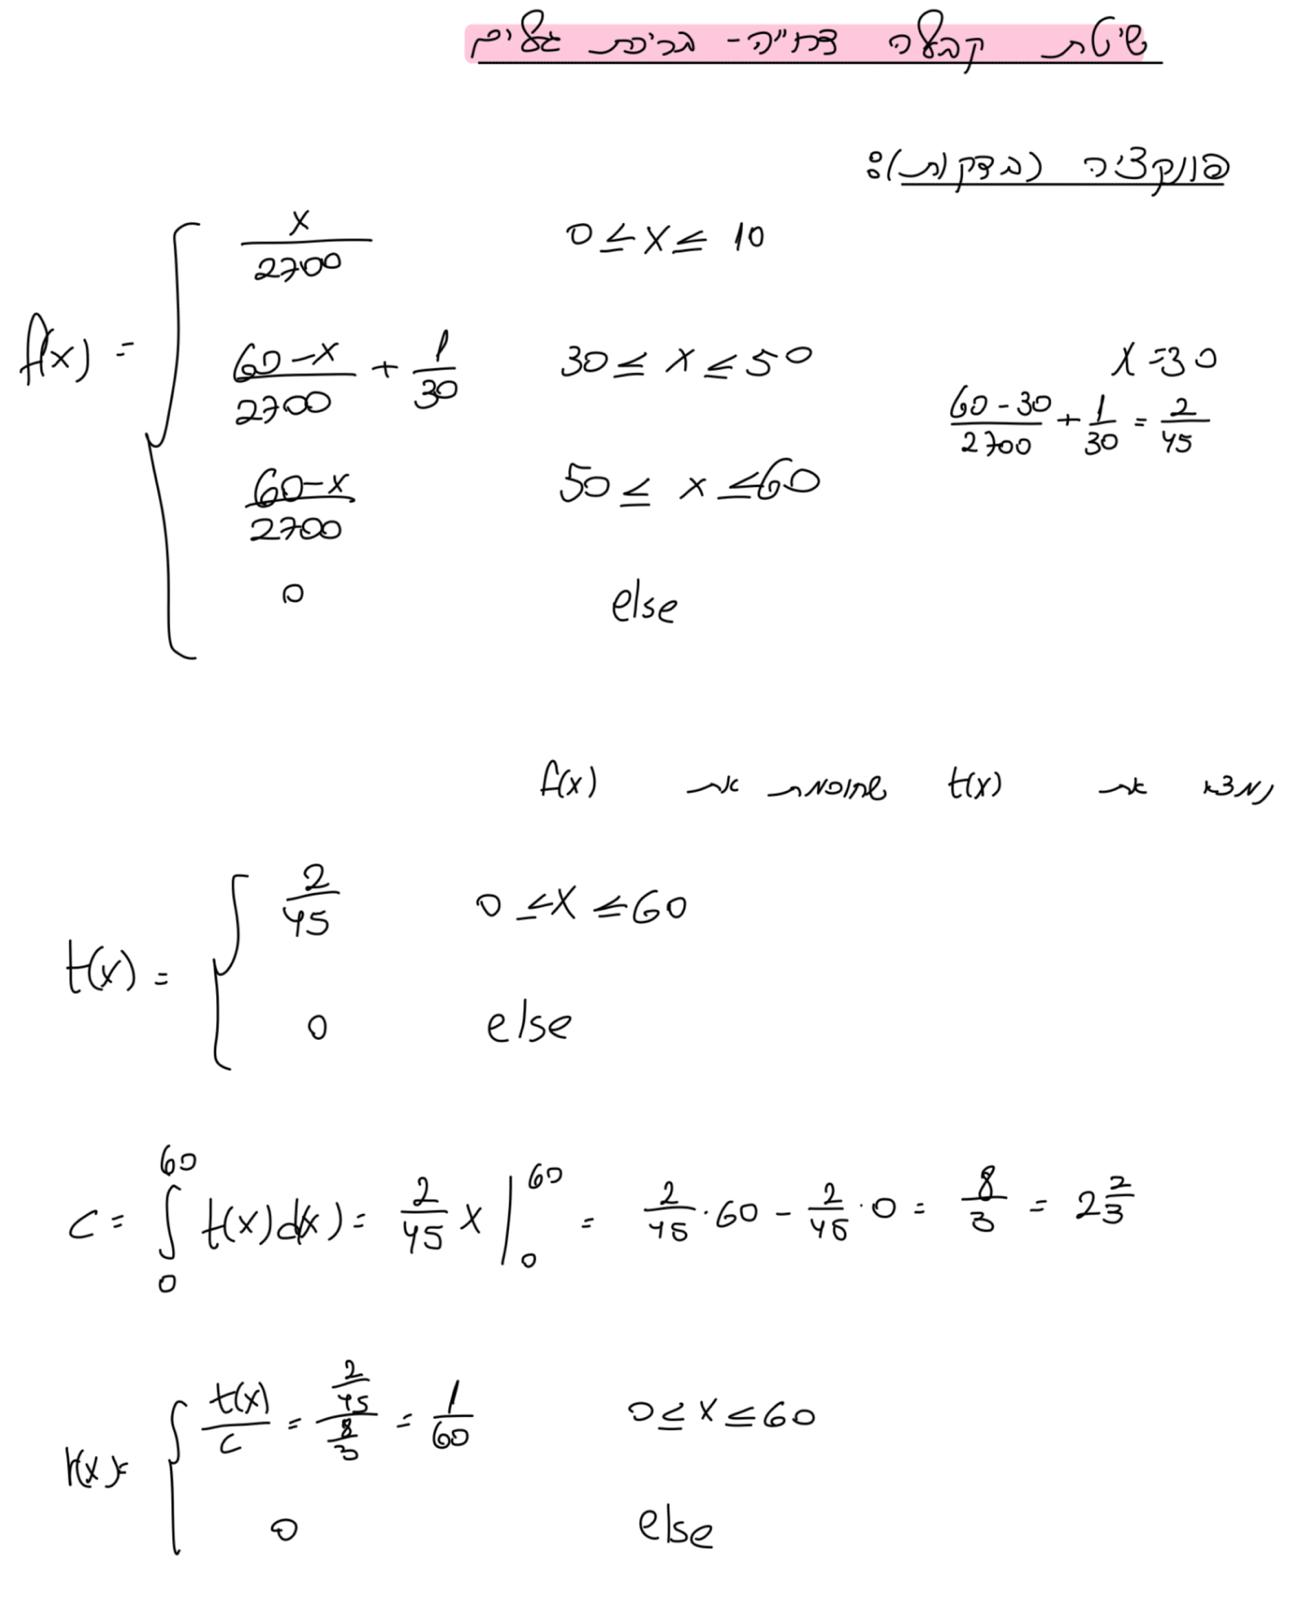

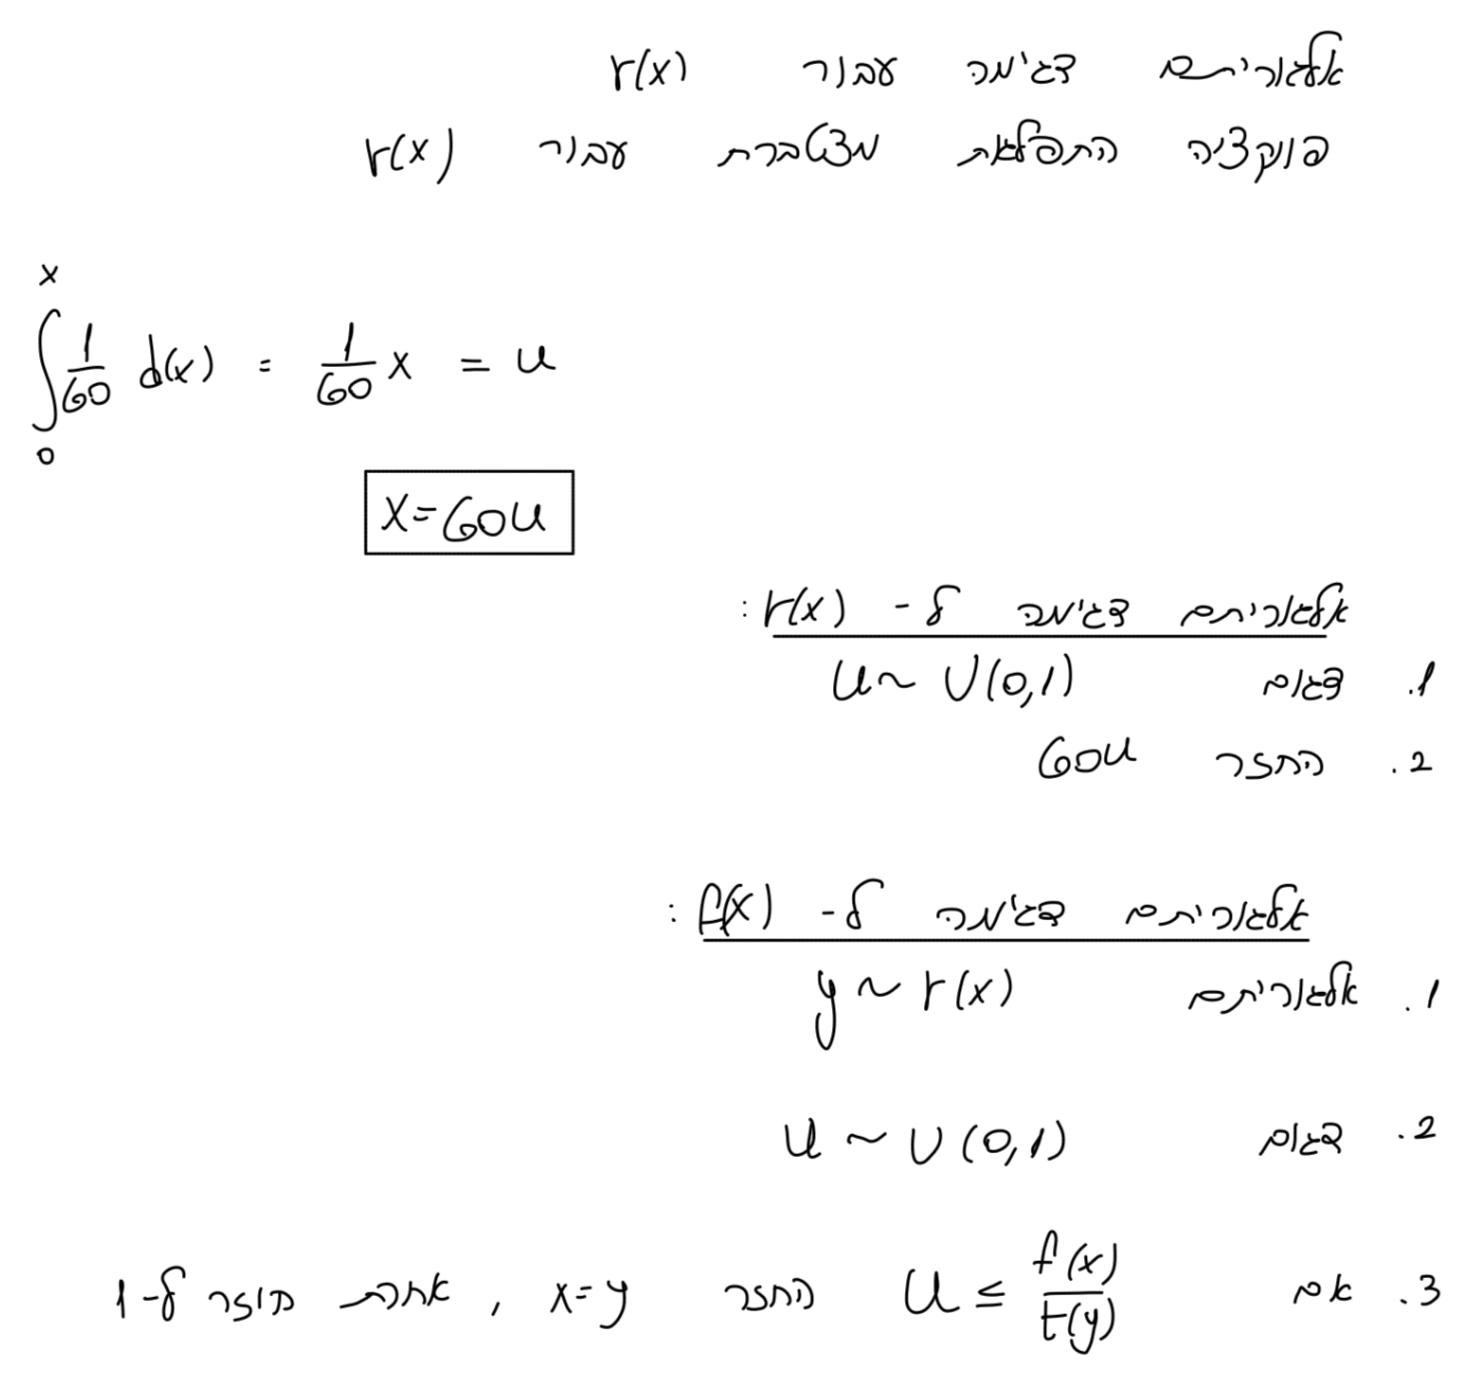

# Statistics Tests for small and big Pipes slides distribution

<div dir="rtl" style="text-align: right; font-size: 16px; line-height: 1.8;">

# התאמת התפלגויות סטטיסטיות ואמידת פרמטרים בשיטת MLE לנתונים מקובץ ה-Excel

בחלק זה אנו מבצעים תיקוף סטטיסטי (Statistical Validation) לזמני הפעילות של שני מתקנים בפארק: המגלשה הגדולה (Big Pipes) והמגלשה הקטנה (Small Pipes). הניתוח מבוסס על נתונים שניתנו בקובץ Excel. תחילה בוצע עיבוד וניקוי של הנתונים, ולאחר מכן הותאמו להם מודלים הסתברותיים ונמצאו הפרמטרים הנדרשים  באמצעות שיטת אומד נראות מקסימלית (MLE). עבור המגלשה הגדולה נבחנה התאמה להתפלגות נורמלית, ועבור המגלשה הקטנה להתפלגות מעריכית. איכות ההתאמה הוערכה באמצעים גרפיים, הכוללים היסטוגרמות, תרשימי QQ והשוואה בין פונקציית ההתפלגות האמפירית לפונקציה התאורטית. מטרת שלב זה היא לקבוע פרמטרים סטטיסטיים שישמשו בהמשך את שלבי הדגימה והסימולציה.


</div>

Saving samples for course project.xlsx to samples for course project (7).xlsx


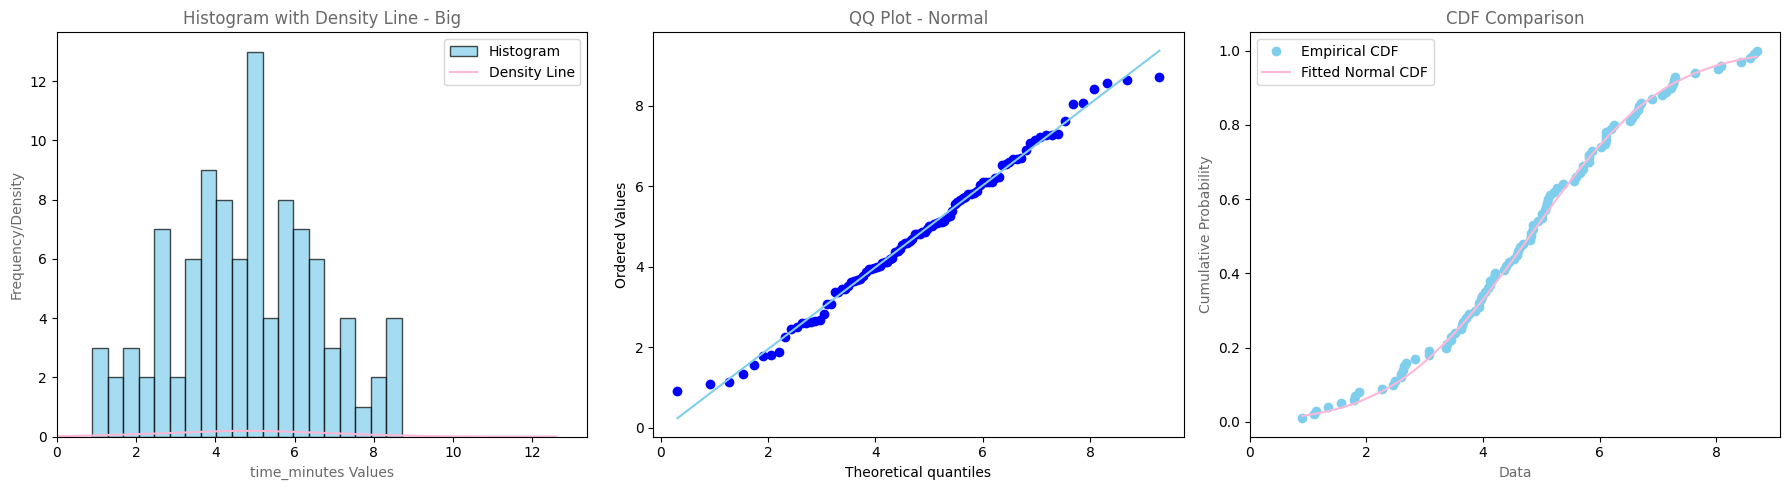

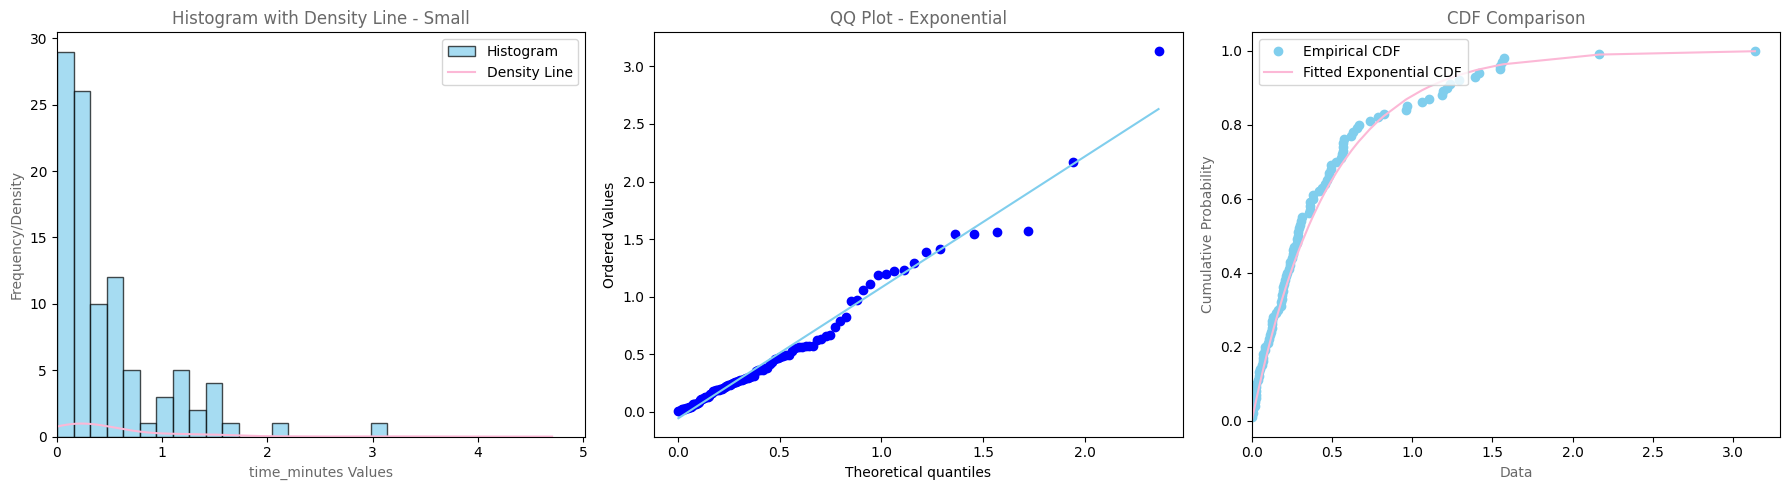

In [ ]:
from google.colab import files

# Load Excel Data
uploaded = files.upload()
excel_file = list(uploaded.keys())[0] # Get the file name
excel_data = pd.ExcelFile(excel_file)

column_name = "time_minutes"

# Read sheets
df_big = pd.read_excel(excel_file, sheet_name=0)
df_small = pd.read_excel(excel_file, sheet_name=1)

#  Data preparation
def prepare_data(df, column):
    x = df[column].dropna()
    x = x[x > 0]
    return x.to_numpy()

x_big = prepare_data(df_big, column_name)
x_small = prepare_data(df_small, column_name)

def histogram_and_density_line(data, title, ax, column_label):
    unified_blue = "#80CEED"
    unified_pink = "#FCB8D6"

    data_series = pd.Series(data)
    ax.hist(data_series, bins=20, edgecolor='black', alpha=0.7, label='Histogram', color=unified_blue)
    data_series.plot(kind='kde', color=unified_pink, label='Density Line', bw_method=0.5, ax=ax)
    ax.set_title(f"Histogram with Density Line - {title}", color='dimgray')
    ax.set_xlabel(f"{column_label} Values", color='dimgray')
    ax.set_ylabel('Frequency/Density', color='dimgray')
    ax.set_xlim(left=0)
    ax.legend()


def MLE(data, dist_type):
    data = np.asarray(data)

    if dist_type == "exponential":
        def neg_log_likelihood(params):
            lam = params[0]
            if lam <= 0:
                return np.inf
            return -np.sum(np.log(lam) - lam * data)

        init = [1 / np.mean(data)]
        bounds = [(1e-6, None)]

    elif dist_type == "normal":
        def neg_log_likelihood(params):
            mu, sigma = params
            if sigma <= 0:
                return np.inf
            return np.sum(
                np.log(sigma)
                + 0.5 * np.log(2 * np.pi)
                + ((data - mu) ** 2) / (2 * sigma ** 2)
            )

        init = [np.mean(data), np.std(data, ddof=1)]
        bounds = [(None, None), (1e-6, None)]

    else:
        raise ValueError("dist_type must be 'exponential' or 'normal'")

    result = minimize(neg_log_likelihood, init, bounds=bounds)
    return tuple(result.x)


def QQ_plot(data, dist_type, params, ax):
    unified_blue = "#80CEED"

    if dist_type == "exponential":
        (lam,) = params
        probplot(data, dist="expon", sparams=(0, 1/lam), plot=ax)
        title = "QQ Plot - Exponential"

    elif dist_type == "normal":
        mu, sigma = params
        probplot(data, dist="norm", sparams=(mu, sigma), plot=ax)
        title = "QQ Plot - Normal"

    else:
        raise ValueError("Unsupported distribution type")

    ax.get_lines()[1].set_color(unified_blue)
    ax.set_title(title, color="dimgray")

def CDF_plot(data, dist_type, params, ax):
    unified_blue = "#80CEED"
    unified_pink = "#FCB8D6"

    data = np.asarray(data)
    sorted_data = np.sort(data)
    n = len(sorted_data)

    ecdf = np.arange(1, n + 1) / n

    if dist_type == "exponential":
        (lam,) = params
        cdf_fitted = 1 - np.exp(-lam * sorted_data)
        label = "Fitted Exponential CDF"

    elif dist_type == "normal":
        mu, sigma = params
        z = (sorted_data - mu) / (sigma * np.sqrt(2))
        cdf_fitted = 0.5 * (1 + np.vectorize(math.erf)(z))
        label = "Fitted Normal CDF"

    else:
        raise ValueError("dist_type must be 'exponential' or 'normal'")

    ax.plot(sorted_data, ecdf, marker='o', linestyle='', label='Empirical CDF', color=unified_blue)
    ax.plot(sorted_data, cdf_fitted, linestyle='-', label=label, color=unified_pink)
    ax.set_title("CDF Comparison", color='dimgray')
    ax.set_xlabel("Data", color='dimgray')
    ax.set_ylabel("Cumulative Probability", color='dimgray')
    ax.set_xlim(left=0)
    ax.legend(loc='upper left')

# Big
params_big = MLE(x_big, "normal")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
histogram_and_density_line(x_big, "Big", axs[0], column_name)
QQ_plot(x_big, "normal", params_big, axs[1])
CDF_plot(x_big, "normal", params_big, axs[2])
plt.tight_layout()
plt.show()

# Small
params_small = MLE(x_small, "exponential")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
histogram_and_density_line(x_small, "Small", axs[0], column_name)
QQ_plot(x_small, "exponential", params_small, axs[1])
CDF_plot(x_small, "exponential", params_small, axs[2])
plt.tight_layout()
plt.show()

<div dir="rtl" style="text-align: right; font-size: 16px; line-height: 1.8;">

## ניתוח התפלגות עבור זמני פעילות במגלשות אבובים

---

### מגלשת אבובים קטנה – התפלגות מעריכית

---

### **היסטוגרמה:**

בניתוח זמני הפעילות במגלשת האבובים הקטנה, ההיסטוגרמה מציגה דפוס שאינו סימטרי, עם ריכוז גבוה של תצפיות בערכים נמוכים של זמן הפעילות וירידה הדרגתית בשכיחות ככל שהערכים עולים.

תבנית זו מאפיינת התפלגות מעריכית, שבה רוב המשתמשים מסיימים את הפעילות בזמן קצר יחסית, אך קיימת הסתברות הולכת ופוחתת לזמני פעילות ארוכים יותר. דפוס זה תואם את האופי האקראי של זמני שירות ופעילות במערכות תור.

---

### **QQ Plot:**

בתרשים ה־QQ עבור המגלשה הקטנה נבחנה התאמת הנתונים להתפלגות המעריכית. ניתן לראות כי עבור הערכים הנמוכים והבינוניים קיימת התאמה טובה בין הכמותונים האמפיריים לכמותונים התאורטיים של ההתפלגות.

עם זאת, בזנב הימני של ההתפלגות נצפית סטייה מסוימת מהקו התיאורטי, בעיקר עבור ערכים גבוהים של זמן הפעילות. סטייה זו שכיחה בנתונים אמפיריים ואינה מעידה בהכרח על חוסר התאמה מהותי של המודל.

---

### **התאמה לפונקציה המצטברת (CDF):**

בהשוואה בין פונקציית ההתפלגות המצטברת האמפירית (ECDF) לבין פונקציית ההתפלגות המצטברת התאורטית של ההתפלגות המעריכית, נצפית חפיפה טובה לאורך רוב תחום הערכים.

עם זאת, קיימים אזורים שבהם ההצטברות בפועל מהירה מעט מהמצופה לפי המודל התאורטי, דבר המרמז על כך שחלק מהמשתמשים מסיימים את הפעילות בזמן קצר במיוחד ביחס להתפלגות התאורטית.

---

### **סיכום – מגלשה קטנה:**

למרות שמדובר במדגם בגודל סופי, הניתוח הגרפי מצביע על כך שההתפלגות המעריכית מהווה קירוב סביר ומתאים לזמני הפעילות במגלשת האבובים הקטנה.

---

## אומדן סבירות מרבית (MLE) – מגלשה קטנה

---

### **פונקציית צפיפות ההסתברות (PDF):**

פונקציית הצפיפות של ההתפלגות המעריכית מוגדרת כך:

$$
f(x; \lambda) =
\begin{cases}
\lambda e^{-\lambda x}, & x \geq 0 \\
0, & x < 0
\end{cases}
$$

כאשר \( \lambda > 0 \) הוא פרמטר הקצב של ההתפלגות.

---

### **פונקציית הסבירות (Likelihood):**

בהינתן מדגם בגודל \( n \):
$$
x_1, x_2, \dots, x_n
$$

פונקציית הסבירות היא:

$$
L(\lambda) = \prod_{i=1}^n \lambda e^{-\lambda x_i}
= \lambda^n e^{-\lambda \sum_{i=1}^n x_i}
$$

---

### **פונקציית הלוג-סבירות (Log-Likelihood):**

$$
\ell(\lambda) = n \ln(\lambda) - \lambda \sum_{i=1}^n x_i
$$

---

### **מציאת אומדן λ (MLE):**

נגזור ונשווה לאפס:

$$
\frac{d\ell(\lambda)}{d\lambda}
= \frac{n}{\lambda} - \sum_{i=1}^n x_i = 0
$$

ומכאן:

$$
\lambda_{MLE} = \frac{n}{\sum_{i=1}^n x_i}
= \frac{1}{\bar{x}}
$$

---

### **מסקנה – מגלשה קטנה:**

אומדן הסבירות המרבית של פרמטר הקצב הוא:

$$
\lambda_{MLE} = \frac{1}{\bar{x}}
$$

---
<div dir="rtl" style="text-align: right; font-size: 16px; line-height: 1.8;">

## מגלשת אבובים גדולה – ניתוח התפלגות ואמידת פרמטרים

---

### **היסטוגרמה:**

בניתוח זמני הפעילות במגלשת האבובים הגדולה, ההיסטוגרמה מציגה התפלגות סימטרית יחסית סביב ערך מרכזי ברור. ניתן לראות כי מרבית זמני הפעילות מרוכזים סביב הממוצע, כאשר השכיחות פוחתת באופן דומה לשני צידי המרכז.

דפוס זה מאפיין התפלגות נורמלית, שבה זמני הפעילות מתפלגים סביב תוחלת מסוימת, עם שונות הנובעת מהבדלים טבעיים בין המשתמשים ומהשפעות אקראיות במהלך הפעילות.

---

### **QQ Plot:**

תרשים ה־QQ עבור המגלשה הגדולה בוחן את התאמת הנתונים להתפלגות הנורמלית. מהתרשים עולה כי מרבית הנקודות ממוקמות בסמוך לקו התיאורטי, דבר המעיד על התאמה טובה בין הכמותונים האמפיריים לבין הכמותונים התאורטיים של ההתפלגות הנורמלית.

סטיות קלות נצפות בקצוות ההתפלגות, בעיקר עבור ערכים קיצוניים, אך סטיות אלו שכיחות במדגמים אמפיריים ואינן מעידות על חוסר התאמה מהותי של המודל.

---

### **התאמה לפונקציה המצטברת (CDF):**

בהשוואה בין פונקציית ההתפלגות המצטברת האמפירית (ECDF) לבין פונקציית ההתפלגות המצטברת התאורטית של ההתפלגות הנורמלית, נצפית חפיפה גבוהה לאורך רוב תחום הערכים. חפיפה זו מחזקת את המסקנה כי ההתפלגות הנורמלית מתארת היטב את התנהגות הנתונים.

---

## אומדן סבירות מרבית (MLE) – מגלשת אבובים גדולה

---

### **פונקציית צפיפות ההסתברות (PDF):**

נניח כי זמני הפעילות במגלשת האבובים הגדולה מתפלגים נורמלית:

$$
X \sim N(\mu,\sigma^2)
$$

פונקציית הצפיפות של ההתפלגות הנורמלית היא:

$$
f(x;\mu,\sigma)=\frac{1}{\sqrt{2\pi}\sigma}
\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$

כאשר \( \sigma > 0 \).

---

### **פונקציית הסבירות (Likelihood):**

בהינתן מדגם בגודל \( n \):

$$
x_1,x_2,\dots,x_n
$$

פונקציית הסבירות היא:

$$
L(\mu,\sigma)=
\prod_{i=1}^{n}
\frac{1}{\sqrt{2\pi}\sigma}
\exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right)
$$

---

### **פונקציית הלוג-סבירות (Log-Likelihood):**

ניקח לוגריתם טבעי לפונקציית הסבירות:

$$
\ell(\mu,\sigma)
= -n\ln(\sigma)
- \frac{n}{2}\ln(2\pi)
- \frac{1}{2\sigma^2}
\sum_{i=1}^{n}(x_i-\mu)^2
$$

---

### **מציאת אומדן \(\mu\) (MLE):**

נגזור את פונקציית הלוג-סבירות לפי \(\mu\) ונשווה לאפס:

$$
\frac{\partial \ell}{\partial \mu}
= \frac{1}{\sigma^2}
\sum_{i=1}^{n}(x_i-\mu)=0
$$

ומכאן מתקבל:

$$
\mu_{MLE}=\bar{x}
$$

כאשר \( \bar{x} \) הוא ממוצע המדגם.

---

### **מציאת אומדן \(\sigma\) (MLE):**

נגזור לפי \(\sigma\) (או לפי \(\sigma^2\)) ונשווה לאפס, ומתקבל:

$$
\sigma^2_{MLE}
= \frac{1}{n}
\sum_{i=1}^{n}(x_i-\bar{x})^2
$$

ולכן:

$$
\sigma_{MLE}
= \sqrt{\frac{1}{n}
\sum_{i=1}^{n}(x_i-\bar{x})^2}
$$

---

### **מסקנה – מגלשת אבובים גדולה:**

אומדי הסבירות המרבית עבור זמני הפעילות במגלשת האבובים הגדולה הם:

$$
\mu_{MLE}=\bar{x},
\qquad
\sigma_{MLE}=
\sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar{x})^2}
$$

אומדים אלו שימשו להתאמת ההתפלגות הנורמלית לנתונים האמפיריים ולבחינת טיב ההתאמה.

</div>




<div dir="rtl" style="text-align: right;">
  <h2 style="color: #80CEED;"> מבחן טיב התאמה סטטיסטי: KS Test</h2>

  <p style="font-size: 18px; line-height: 1.6;">
  לאחר הניתוח הגרפי, ביצענו בחלק זה מבחן השערות פורמלי מסוג <b>Kolmogorov-Smirnov (KS)</b> כדי לקבוע האם ניתן לאשש את בחירת ההתפלגויות ברמת מובהקות של $\alpha=0.05$.
  </p>

  <p style="font-size: 18px; line-height: 1.6;">
  <b>השערות המבחן:</b><br>
  $H_0$: הנתונים נדגמו מההתפלגות התאורטית שנבחרה.<br>
  $H_1$: הנתונים אינם מתפלגים לפי ההתפלגות התאורטית.
  </p>

  <p style="font-size: 18px; line-height: 1.6;">
  עבור כל מתקן, חישבנו את סטטיסטי המבחן ($D$) והשווינו אותו לערך הקריטי המתאים לסוג ההתפלגות ולגודל המדגם. מאחר והשתמשנו בפרמטרים שנאמדו מתוך הנתונים (MLE), הקוד כולל תיקון לסטטיסטי המבחן כדי להבטיח דיוק מירבי.
  </p>

  <p style="font-size: 18px; line-height: 1.6;">
  <b>תוצאות המבחן:</b><br>
  במידה ו-<b>D Statistic < Critical Value</b>, אנו נכשלים בדחיית השערת האפס (Fail to reject $H_0$), מה שמהווה אישור סטטיסטי סופי לכך שהמודל שבנינו מהימן וניתן להשתמש בו בסימולציה.
  </p>

  <p style="font-size: 18px; line-height: 1.6; color: gray;">

</div>

In [ ]:
from math import erf, sqrt

#Goodness-of-Fit Test for small and big slides distribution

#Compute the empirical CDF of the data
def empirical_cdf(data):
    data_sorted = np.sort(data)
    n = len(data)
    return data_sorted, np.arange(1, n+1) / n


# Compute the KS test
def ks_test(data, dist_type, cdf, *params):
    n = len(data)
    data_sorted, emp_cdf = empirical_cdf(data)
    theo_cdf = cdf(data_sorted, *params)
    d_statistic = np.max(np.abs(emp_cdf - theo_cdf))   # KS raw statistic

    # Adjusted statistic according to distribution
    if dist_type == "exponential":
        new_d_statistic = (np.sqrt(n) + 0.26 + 0.5/np.sqrt(n)) * (d_statistic - 0.2/n)

    elif dist_type == "normal":
        new_d_statistic = (np.sqrt(n) - 0.01 + 0.85/np.sqrt(n)) * d_statistic

    else:
        raise ValueError("dist_type must be 'exponential' or 'normal'")

    return new_d_statistic

# Define the theoretical CDF for the exponential distribution
def exp_cdf(x, lambda_):
    return 1 - np.exp(-lambda_ * x)

def d_critical_exponential(alpha):
  if 1-alpha == 0.85:
     return 0.926
  if 1-alpha == 0.9:
     return 0.900
  if 1-alpha == 0.95:
      return 1.094
  if 1-alpha == 0.975:
      return 1.19
  if 1-alpha == 0.99:
      return 1.308

# Define the theoretical CDF for the normal distribution

def normal_cdf(x, mu, sigma):
    x = np.asarray(x)
    z = (x - mu) / (sigma * sqrt(2))
    return 0.5 * (1 + np.vectorize(erf)(z))

def d_critical_normal(alpha):
  if 1-alpha == 0.85:
     return 0.775
  if 1-alpha == 0.9:
     return 0.819
  if 1-alpha == 0.95:
      return 0.895
  if 1-alpha == 0.975:
      return 0.955
  if 1-alpha == 0.99:
      return 1.035

def hypothesis_test(critical_value,d_statistic):
  if d_statistic > critical_value:
    print(f"{d_statistic} > {critical_value} therefore, Reject the null hypothesis")
  else:
    print(f"{d_statistic} < {critical_value} therefore, Fail to reject the null hypothesis")

# KS test for small
display(HTML("<h2 style='text-align: letf ; color: unified_blue;'>small KS test </h2>"))
d_statistic_small = ks_test(x_small,"exponential",exp_cdf, *params_small)
critical_value_small = d_critical_exponential(0.05)
print("D Statistic:", d_statistic_small)
print("Critical Value:", critical_value_small)
hypothesis_test(critical_value_small, d_statistic_small)

# KS test for big
display(HTML("<h2 style='text-align: letf ; color: unified_blue;'>big KS test </h2>"))
d_statistic_big = ks_test(x_big,"normal",normal_cdf, *params_big)
critical_value_big = d_critical_normal(0.05)
print("D Statistic:", d_statistic_big)
print("Critical Value:", critical_value_big)
hypothesis_test(critical_value_big, d_statistic_big)



D Statistic: 0.685154684725994
Critical Value: 1.094
0.685154684725994 < 1.094 therefore, Fail to reject the null hypothesis


D Statistic: 0.37229898840754105
Critical Value: 0.895
0.37229898840754105 < 0.895 therefore, Fail to reject the null hypothesis


<div dir="rtl" style="text-align: right; font-size: 16px; line-height: 1.8;">

##ניתוח תוצאות מבחן KS

עבור המגלשה הקטנה הסטטיסטי המחושב היה D* = 0.685, אשר קטן מהערך הקריטי 1.094 ברמת מובהקות α = 0.05.

לפיכך, לא נדחתה השערת האפס, וניתן לומר כי הנתונים תואמים התפלגות אקספוננציאלית.

---

עבור המגלשה הגדולה הסטטיסטי המחושב היה
D* = 0.372, אשר קטן מהערך הקריטי 0.895 ברמת מובהקות α = 0.05.

לפיכך, גם במקרה זה לא נדחתה השערת האפס, והנתונים תואמים התפלגות נורמלית.

</div>

# Implementation Details

<div dir="rtl" style="text-align: right; font-size: 16px; line-height: 1.8;">

---

**הסבר כללי על המידול**
---

**Arrival to Reception-** ממדל הגעות של אורחים לפארק המים, לפי זמני הגעה שונים. מאתחל את אירועי ההגעה הבאים. בדיקה האם יש פקיד בקבלה. כאשר לקוח מגיעה לקבלה משלם ומקבל צמיד. בהסתברות של 0.25 רוכש כרטיס אקספרס.

**End Reception**- הלקוח סיים לשלם ונכנס לפארק. הלולאה העצמית אומרת שכאשר לקוח מסיים, אם יש מישהו בתור קח אותו ותזמן לו סיום שירות.

**Arrive at Facility**- הלקוח מגיע לתור של מתקן ספציפי. בודק אם המתקן פנוי או יש מספיק אנשים בשביל למלא את הדרישה (אבובים).

**Queue abandonment**- אירוע שמתרחש רק אם לקוח חיכה יותר מדי זמן ועדיין לא קיבל שירות. עבור בני נוער: בהסתברות 0.6 הנער רוכש צמיד אקספרס וחוזר לתור, אם לא הוא הולך למתקן אחר.

**Upgrade of Express**- אירוע עבור בני נוער שנטשו את התור והחליטו לרכוש כרטיס אקספרס.

**End service**- סיום שירות- סיום שהות במתקן, כשהאורח מסיים במתקן הוא סורק את הצמיד ומעדכן את הדירוג לפי חווית המתקן.

**Arrival Lunch**- הורח נכנס למתחם האוכל, בוחר מסעדה (פיצה/המבורגר/סלטים) ועומד בתור.

**Departure Event**- כאפשר אורח מחליט ללכת לפני שעת היציאה הסופית, האורח בודק את התמונות. ההחלטה אם לקנות תלויה בדירוג הסופי שצבר במהלך היום.

**End of Day Event**- אורחים יותר לא נכנסים לפארק. סיום הרצת הסימולציה ב19:00. כל האורחים עוזבים.

---

</div>





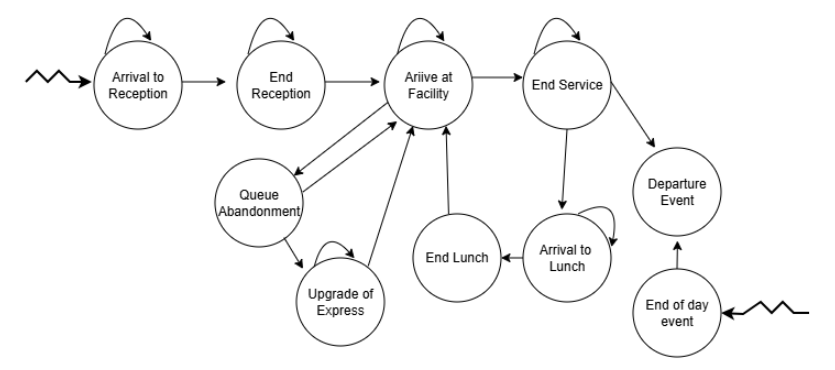


**תרשים טיפול- עזיבה ורכישת תמונות**
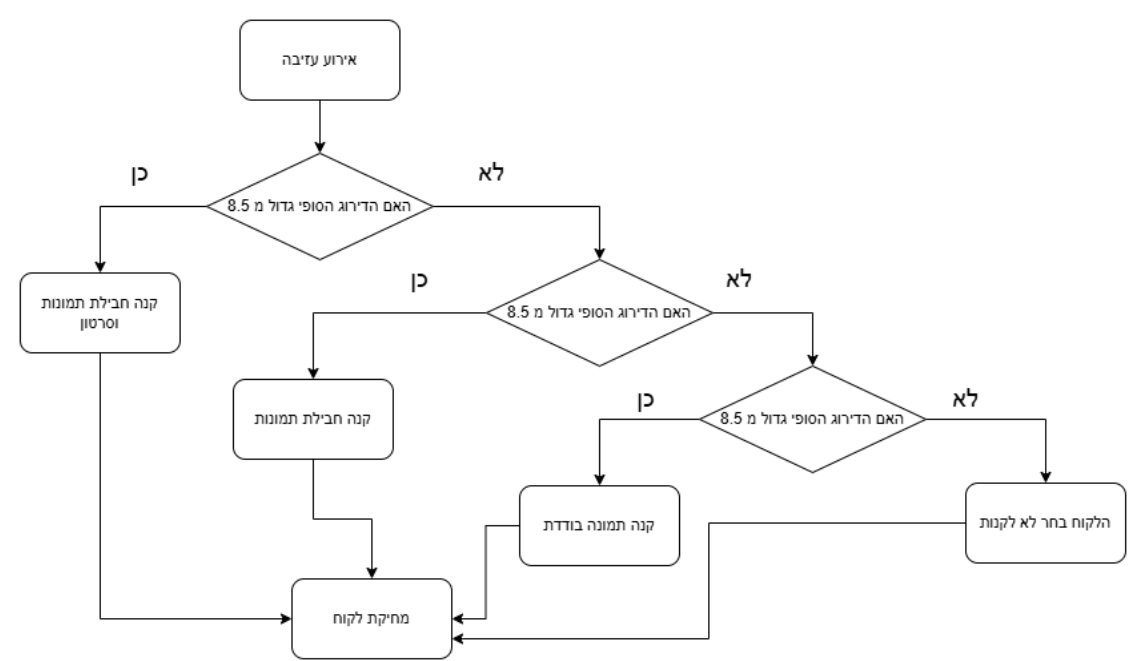

**תרשים טיפול-נטישת תור**

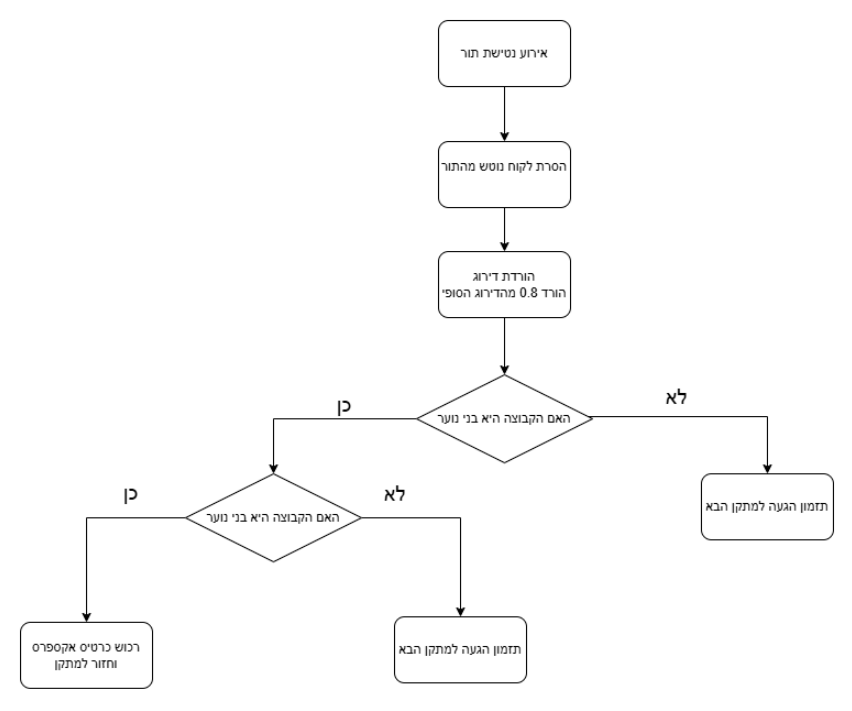

**תרשים טיפול- הגעה לקבלה**

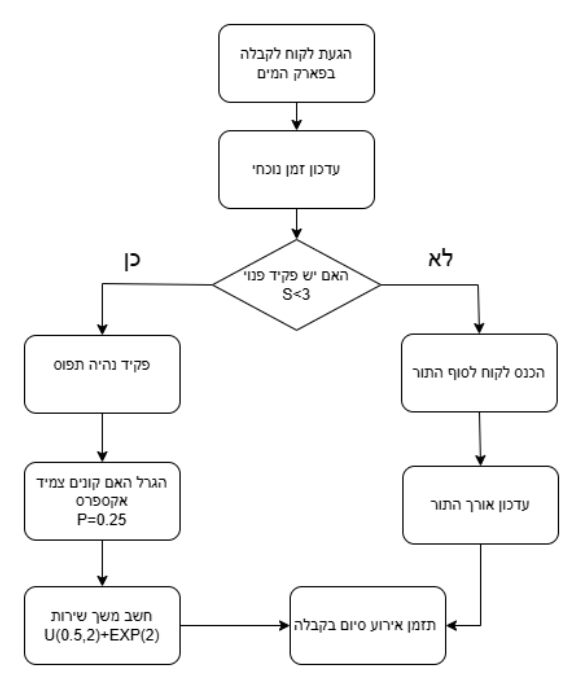

# Visitor classes

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h2 style="color: #80CEED;">  מחלקות הישויות (Entities)</h2>

<p style="font-size: 18px; line-height: 1.6;">
מימוש הישויות מתבסס על היררכיית מחלקות (Inheritance), כאשר בראשן עומדת מחלקת הבסיס <b>Visitor</b>. מבנה זה מאפשר לנהל תכונות משותפות (כמו זמן הגעה ודירוג) לצד התנהגויות ייחודיות לכל סוג קבוצה.
</p>

<h3 style="color: dimgray;">מחלקת הבסיס: Visitor</h3>
<p style="font-size: 18px; line-height: 1.6;">
כל ישות בפארק מחזיקה במזהה ייחודי (ID) ובמדד שביעות רצון (Rating) המתחיל ב-5.0. המחלקה כוללת לוגיקה לניהול כניסה לתורים ובדיקת <b>סף נטישה (Abandonment Threshold)</b> – מנגנון המוודא כי מבקרים ללא כרטיס אקספרס יעזבו את התור אם זמן ההמתנה חורג מהסבלנות שלהם.
</p>

<h3 style="color: dimgray;">סוגי המבקרים והתנהגותם:</h3>

<ul style="font-size: 18px; line-height: 1.6;">
  <li><b>משפחות (Family):</b> מאופיינות במספר משתנה של ילדים (1-5) בגילאים שונים. למשפחות יש סף נטישה נמוך יחסית (15 דקות). אחת היכולות המורכבות שמומשו היא ה-<b>Split</b>: היכולת של משפחה להתפצל לתתי-קבוצות (SubGroups) בהתאם למגבלות גיל במתקנים.</li>
  <li><b>קבוצות בני נוער (TeenGroup):</b> מגיעות בקבוצות של 2-6 חברים. לבני נוער יש לוגיקת נטישה ייחודית: במידה והמתינו מעל 20 דקות, ישנה הסתברות של 60% שיבחרו לשדרג לכרטיס אקספרס בו-במקום כדי לחזור למתקן במהירות.</li>
  <li><b>מבקרים בודדים (SingleVisitor):</b> מיוצגים כאנשים בוגרים (גילאי 18-70). אלו המבקרים הסבלניים ביותר בפארק, עם סף נטישה של 30 דקות.</li>
</ul>

<p style="font-size: 18px; line-height: 1.6; background-color: #f9f9f9; padding: 10px; border-right: 5px solid #80CEED;">
<b>הדירוג</b><br>
כל ישות מעדכנת את ה-Rating שלה לאחר כל אירוע: עלייה לאחר חוויה טובה במתקן (מבוסס על אדרנלין וגודל קבוצה) וירידה במקרה של נטישת תור או ארוחה לא מספקת. דירוג זה יקבע בסוף היום האם הישות תרכוש חבילת תמונות למזכרת.
</p>

</div>

In [ ]:
class Visitor:
    """
    Base class for all park visitors.
    Handles rating system, express pass, and queue management.
    """


    def __init__(self, arrival_time):
        self.id = id(self)  # Unique identifier for the visitor
        self.arrival_time = arrival_time  # DateTime when visitor arrived at park
        self.rating = 10.0
        self.has_express_pass = False  # Whether visitor purchased express pass
        self.time_entered_queue = None  # Track when visitor entered current queue
        self.current_facility = None  # Current facility visitor is queuing for
        self.departure_time = None  # Scheduled departure time

    def update_rating_positive(self, group_size, adrenaline_level):
        """
        Increase rating after good experience at facility.
        Formula: score = (GS-1)/5 * 0.3 + (A-1)/4 * 0.7
        """
        increase = Sampling_Algorithms.calculate_positive_rating(group_size, adrenaline_level)
        self.rating += increase

    def update_rating_negative(self, amount=0.1):
        """
        Decrease rating (e.g., after bad experience or queue abandonment).
        Rating cannot go below 0.
        """
        self.rating -= amount
        self.rating = max(0, self.rating)

    def get_abandonment_threshold(self):
        """
        Return maximum waiting time in minutes before abandoning queue.
        Must be implemented by subclasses.
        """
        raise NotImplementedError("Subclass must implement abandonment threshold")

    def should_abandon(self, current_time):
        """
        Check if visitor should abandon current queue based on waiting time.
        Express pass holders never abandon.
        """
        if self.time_entered_queue is None:
            return False
        if self.has_express_pass:
            return False
        waiting_time = current_time - self.time_entered_queue
        return waiting_time >= self.get_abandonment_threshold()

    def enter_queue(self, facility, current_time):
        """
        Add visitor to facility queue (regular or express based on pass).
        """
        self.time_entered_queue = current_time
        self.current_facility = facility
        facility.enter_queue(self)

    def reset_queue_time(self):
        """Reset queue entry time (e.g., after leaving queue)."""
        self.time_entered_queue = None


class Family(Visitor):
    """
    Represents a family group (2 parents + 1-5 kids).
    Can split into subgroups based on children's ages.
    """

    def __init__(self, arrival_time):
        super().__init__(arrival_time)

        # Generate family composition
        self.num_kids = Sampling_Algorithms.get_number_kids()  # Discrete Uniform[1,5]
        self.total_size = self.num_kids + 2  # Kids + 2 parents
        self.group_size = self.total_size

        # Generate ages for all kids
        self.kids_ages = []
        for _ in range(self.num_kids):
            age = Sampling_Algorithms.get_kid_age()  # Uniform[2,18]
            self.kids_ages.append(age)

        # Family departure time: f(x) = 2/9(x-16), 16≤x≤19
        self.departure_time = Sampling_Algorithms.get_family_departure_time()

        # Splitting management
        self.is_split = False  # Whether family has split into subgroups
        self.subgroups = []  # List of SubGroup objects if split
        self.active_subgroups_count = 1  # Number of active subgroups (for tracking completion)

        # Track which facilities have been visited
        self.visited_facilities = []

        # 25% chance to buy express pass on entry
        if Sampling_Algorithms.should_buy_express_on_entry():
            self.has_express_pass = True

    def get_abandonment_threshold(self):
        """Families abandon queue after 15 minutes."""
        return 15

    def check_and_split(self):
        """
        Determine if family splits into subgroups (60% probability).
        Splitting rules:
        - Kids under 8 must be with a parent
        - Kids 12+ can supervise younger siblings
        - Split into 2 or 3 groups (equal probability)

        Returns: List containing either [self] or list of SubGroup objects
        """
        # 40% chance family stays together
        if not Sampling_Algorithms.should_family_split():
            return [self]

        self.is_split = True
        num_groups = Sampling_Algorithms.get_num_split_groups()  # 2 or 3 groups

        # Categorize kids by age
        kids_under_8 = [age for age in self.kids_ages if age < 8]
        kids_8_to_12 = [age for age in self.kids_ages if 8 <= age < 12]
        kids_over_12 = [age for age in self.kids_ages if age >= 12]

        subgroups = []

        # Group 1: Kids under 8 with one parent (mandatory if any kids under 8)
        if kids_under_8:
            group = SubGroup(
                parent_family=self,
                size=1 + len(kids_under_8),  # 1 parent + kids
                min_age=min(kids_under_8),
                has_express_pass=self.has_express_pass
            )
            subgroups.append(group)

        # Group 2: Kids 12+ can go independently
        if kids_over_12 and len(subgroups) < num_groups:
            group = SubGroup(
                parent_family=self,
                size=len(kids_over_12),
                min_age=min(kids_over_12),
                has_express_pass=self.has_express_pass
            )
            subgroups.append(group)

        # Group 3: Remaining kids (8-12) with remaining parent
        if len(subgroups) < num_groups:
            remaining_size = self.total_size - sum(g.group_size for g in subgroups)
            if remaining_size > 0:
                remaining_ages = kids_8_to_12 if kids_8_to_12 else [14]
                group = SubGroup(
                    parent_family=self,
                    size=remaining_size,
                    min_age=min(remaining_ages) if remaining_ages else 14,
                    has_express_pass=self.has_express_pass
                )
                subgroups.append(group)

        # If couldn't create at least 2 groups, don't split
        if len(subgroups) < 2:
            self.is_split = False
            return [self]

        # Store subgroups and set counter for completion tracking
        self.subgroups = subgroups
        self.active_subgroups_count = len(subgroups)
        return subgroups

    def get_min_age(self):
        """Return minimum age in family (youngest kid)."""
        return min(self.kids_ages) if self.kids_ages else 14


class SubGroup(Visitor):
    """
    Represents a portion of a split family.
    Maintains reference to parent family for coordination.
    """

    def __init__(self, parent_family, size, min_age, has_express_pass):
        super().__init__(parent_family.arrival_time)
        self.parent_family = parent_family  # Reference to original Family object
        self.group_size = size
        self.min_age = min_age
        self.has_express_pass = has_express_pass
        self.rating = parent_family.rating  # Share rating with parent family
        self.departure_time = parent_family.departure_time  # Share departure time

        # Track which facilities have been visited
        self.visited_facilities = []

    def get_abandonment_threshold(self):
        """SubGroups abandon queue after 15 minutes (same as families)."""
        return 15

    def get_min_age(self):
        """Return minimum age in this subgroup."""
        return self.min_age


class TeenGroup(Visitor):
    """
    Represents a group of teenagers (2-6 people, age 14+).
    Prefer high-adrenaline facilities (level 3+).
    Can purchase express pass after abandoning queue.
    """

    def __init__(self, arrival_time):
        super().__init__(arrival_time)

        # Group composition
        self.group_size = Sampling_Algorithms.get_teen_group_size()  # 2-6 people
        self.min_age = 14  # All teens are 14+

        # Abandonment tracking
        self.abandoned_facilities = []  # List of facilities they abandoned
        self.abandon_count = 0  # Number of times they've abandoned queues

        # Track which facilities have been visited
        self.visited_facilities = []

        # Teens leave at park closing (19:00)
        self.departure_time = 19.0

        # 25% chance to buy express pass on entry
        if Sampling_Algorithms.should_buy_express_on_entry():
            self.has_express_pass = True

    def get_abandonment_threshold(self):
        """Teen groups abandon queue after 20 minutes."""
        return 20

    def handle_abandonment(self, facility):
        """
        Handle queue abandonment for teen group.
        60% chance they buy express pass and return to same facility.
        Otherwise, they move to next facility.

        Returns: "buy_express_and_return" or "move_to_next"
        """
        self.abandoned_facilities.append(facility)
        self.abandon_count += 1

        # If don't have express pass yet, 60% chance to buy one
        if not self.has_express_pass:
            if Sampling_Algorithms.should_teens_buy_express_after_abandon():
                self.has_express_pass = True
                return "buy_express_and_return"

        return "move_to_next"

    def get_min_age(self):
        """Return minimum age (always 14 for teen groups)."""
        return self.min_age


class SingleVisitor(Visitor):
    """
    Represents an individual adult visitor (age 18-70).
    Prefer facilities with age restriction 12+.
    """

    def __init__(self, arrival_time):
        super().__init__(arrival_time)

        self.group_size = 1
        self.min_age = Sampling_Algorithms.sample_uniform(18, 70)  # Random adult age

        # Track which facilities have been visited
        self.visited_facilities = []

        # Single visitors leave at park closing (19:00)
        self.departure_time = 19.0

        # 25% chance to buy express pass on entry
        if Sampling_Algorithms.should_buy_express_on_entry():
            self.has_express_pass = True

    def get_abandonment_threshold(self):
        """Single visitors abandon queue after 30 minutes."""
        return 30

    def get_min_age(self):
        """Return visitor's age."""
        return self.min_age


# Factory functions for creating visitors
def create_family(arrival_time):
    """Create and return a new Family object."""
    return Family(arrival_time)


def create_teen_group(arrival_time):
    """Create and return a new TeenGroup object."""
    return TeenGroup(arrival_time)


def create_single_visitor(arrival_time):
    """Create and return a new SingleVisitor object."""
    return SingleVisitor(arrival_time)

# Queue Class

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h2 style="color: #80CEED;"> ניהול תורים ואיסוף נתונים (QueueServer)</h2>

<p style="font-size: 18px; line-height: 1.6;">
כדי למדוד את יעילות הפארק, פיתחנו את מחלקת ה-<b>QueueServer</b>. מחלקה זו עוטפת את מבנה הנתונים <code>deque</code> ומוסיפה לו שכבת "אינטליגנציה סטטיסטית" המאפשרת מעקב רציף אחר ביצועי המתקנים.
</p>

<h3 style="color: dimgray;">תכונות מרכזיות של מנגנון התורים:</h3>

<ul style="font-size: 18px; line-height: 1.6;">
  <li><b>מדידת זמני המתנה:</b> בכל פעם שמתבצע <code>pop</code> (מבקר נכנס למתקן), המערכת מחשבת את ההפרש בין זמן הכניסה לתור לזמן היציאה ממנו. נתונים אלו נשמרים ברשימת <code>waiting_times</code> לצורך חישוב ממוצעים יומיים.</li>
  <li><b>חישוב אורך תור ממוצע (Time-Weighted Average):</b> המערכת לא רק סופרת כמה אנשים יש בתור, אלא משקללת זאת לאורך זמן. פונקציית <code>record_queue_length</code> מחשבת את ה"שטח מתחת לעקומה" של אורך התור, מה שמאפשר לקבל תמונה ריאליסטית של העומס לאורך שעות הפעילות.</li>
  <li><b>גמישות תפעולית:</b> המחלקה תומכת בפעולות מתקדמות כמו <code>insert</code> (הכנסת קבוצה למיקום ספציפי) ו-<code>remove</code> (טיפול בנטישת תור), תוך עדכון מיידי של המדדים הסטטיסטיים.</li>
</ul>

<p style="font-size: 18px; line-height: 1.6; background-color: #fdf6e3; padding: 10px; border-right: 5px solid #80CEED;">
<b>חישוב סטטיסטיקה יומית:</b><br>
בסיום כל יום סימולציה, פונקציית <code>calc_daily_statistics</code> מסכמת את הנתונים ומכינה אותם להצגה גרפית. היא מאפסת את המדדים לקראת היום הבא אך שומרת את הממוצעים היומיים (Daily Avg) כדי שנוכל לבצע ניתוח השוואתי בין ימי עבודה שונים.
</p>

</div>

In [ ]:
import numpy as np
from datetime import datetime
from collections import deque


class QueueServer:
    """
    Queue management class with statistics tracking.
    Tracks waiting times, queue lengths, and calculates daily averages.
    Used for both regular and express queues at all facilities.
    """

    def __init__(self):
        self.server_queue = deque()  # Main queue: [(visitor, arrival_time), ...]
        self.active_hours = 10  # Default active hours (9:00-19:00)

        # Statistics tracking
        self.waiting_times = []  # List of all waiting times (minutes)
        self.total_queue_length_time = 0  # Area under queue length curve
        self.queue_lengths = [0]  # Queue length at each change
        self.queue_change_times = []  # Times when queue length changed

        # Daily statistics (calculated at end of day)
        self.daily_avg_queue_lengths = []  # Average queue length per day
        self.daily_avg_waiting_times = []  # Average waiting time per day

    def add(self, visitor, arrival_time):
        """
        Add visitor to queue and record statistics.

        Args:
            visitor: Visitor object
            arrival_time: DateTime when visitor joined queue
        """
        self.server_queue.append([visitor, arrival_time])
        self.record_queue_length(arrival_time)

    def insert(self, index, visitor, time):
        """
        Insert visitor at specific position in queue.
        Used for returning visitors to queue after failed batch formation.

        Args:
            index: Position to insert (0 = front of queue)
            visitor: Visitor object
            time: DateTime of insertion
        """
        temp_list = list(self.server_queue)
        temp_list.insert(index, [visitor, time])
        self.server_queue = deque(temp_list)
        if time is not None:
            self.record_queue_length(time)

    def remove(self, visitor, current_time):
        """
        Remove specific visitor from queue (e.g., for abandonment).

        Args:
            visitor: Visitor object to remove
            current_time: DateTime of removal
        """
        self.record_queue_length(current_time)  # Record statistics before removal

        # Find and remove visitor
        for i, (v, t) in enumerate(self.server_queue):
            if v == visitor:
                temp_list = list(self.server_queue)
                temp_list.pop(i)
                self.server_queue = deque(temp_list)
                return

    def pop(self, removing_time):
        """
        Remove and return first visitor from queue.
        Calculates waiting time if removing_time is provided.

        Args:
            removing_time: DateTime when visitor removed (None to skip statistics)

        Returns:
            (visitor, arrival_time) or (None, None) if queue empty
        """
        if self.server_queue:
            extracted = self.server_queue.popleft()

            if removing_time is not None:
                # Record statistics
                self.record_queue_length(removing_time)

                # Calculate waiting time
                wait_duration = (removing_time - extracted[1]).total_seconds() / 60  # Minutes
                self.waiting_times.append(wait_duration)

            return extracted[0], extracted[1]
        return None, None

    def record_queue_length(self, current_time):
        """
        Record queue length change for statistics.
        Updates area under queue length curve.

        Args:
            current_time: DateTime of queue length change
        """
        if self.queue_lengths and self.queue_change_times:
            # Calculate time since last change
            last_time = self.queue_change_times[-1]
            duration_hours = (current_time - last_time).total_seconds() / 3600

            # Update area under curve: queue_length * time_duration
            self.total_queue_length_time += self.queue_lengths[-1] * duration_hours

        # Record new state
        self.queue_change_times.append(current_time)
        self.queue_lengths.append(self.size())

    def size(self):
        """Return current number of visitors in queue."""
        return len(self.server_queue)

    def __len__(self):
        """Support len() operator."""
        return self.size()

    def __bool__(self):
        """Support boolean check (True if queue not empty)."""
        return self.size() > 0

    def __getitem__(self, index):
        """
        Support indexing: queue[0] returns first visitor.

        Args:
            index: Position in queue

        Returns:
            Visitor object at index
        """
        return list(self.server_queue)[index][0]

    def __iter__(self):
        """
        Support iteration over queue.

        Yields:
            Visitor objects in queue order
        """
        for visitor, time in self.server_queue:
            yield visitor

    def set_active_hours(self, opening_hour, closing_hour):
        """
        Set active hours for daily statistics calculation.

        Args:
            opening_hour: String in format "HH:MM" (e.g., "09:00")
            closing_hour: String in format "HH:MM" (e.g., "19:00")
        """
        fmt = '%H:%M'
        tdelta = datetime.strptime(closing_hour, fmt) - datetime.strptime(opening_hour, fmt)
        self.active_hours = tdelta.total_seconds() / 3600  # Convert to hours

    def calc_daily_statistics(self):
        """
        Calculate and store daily statistics.
        Called at end of simulation day.
        Resets daily counters for next day.
        """
        # Calculate average queue length (area under curve / active hours)
        daily_avg_length = self.total_queue_length_time / self.active_hours if self.active_hours > 0 else 0
        self.daily_avg_queue_lengths.append(daily_avg_length)

        # Calculate average waiting time
        daily_avg_wait = np.mean(self.waiting_times) if self.waiting_times else 0
        self.daily_avg_waiting_times.append(daily_avg_wait)

        # Reset daily counters
        self.total_queue_length_time = 0
        self.queue_change_times = []
        self.queue_lengths = [0]
        self.waiting_times = []

# Facilities classes


<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h2 style="color: #80CEED;"> תשתיות הפארק: מתקנים ושירותים (Facilities & Services)</h2>

<p style="font-size: 18px; line-height: 1.6;">
המתקנים בסימולציה ממומשים באמצעות היררכיית מחלקות המבוססת על מחלקת האם <b>Facility</b>. כל מתקן מנהל שני תורים נפרדים (רגיל ואקספרס) באמצעות אובייקט <code>QueueServer</code>, המאפשר איסוף נתונים סטטיסטיים בזמן אמת על זמני המתנה ואורכי תור.
</p>

<h3 style="color: dimgray;">לוגיקת תפעול ייחודית:</h3>

<ul style="font-size: 18px; line-height: 1.6;">
  <li><b>נהר האבובים (Pipes River):</b> המתקן המורכב ביותר תפעולית. המערכת מיישמת לוגיקת "זיווג" (Pairing) עבור קבוצות בגודל אי זוגי, כדי למקסם את ניצול האבובים (2 אנשים באבוב) ולמנוע בזבוז קיבולת.</li>
  <li><b>מגלשות הצינור (Big & Small Pipes):</b> כאן מיושמת מדיניות "מנה (Batch)": המגלשה הגדולה ממתינה למילוי אבוב של 8 אנשים, בעוד הקטנה דורשת 3. המערכת נותנת עדיפות לתור האקספרס אך יודעת "למשוך" אנשים מהתור הרגיל כדי להשלים מנה ולצאת לדרך.</li>
  <li><b>מגלשות בודדות (Single Slides):</b> מידול המבוסס על <b>מרווח בטיחות (Safety Interval)</b>. הכניסה למגלשה מתאפשרת רק לאחר שחלפו 30 שניות מהגולש הקודם, מה שיוצר צוואר בקבוק טבעי המדמה את המציאות.</li>
  <li><b>מתחם הצלילה (Snorkel Tour):</b> מנוהל על ידי צוות מדריכים. המערכת מדמה את לוח הזמנים של המדריכים, כולל יציאה להפסקות והפסקת צהריים קבועה בין 13:00 ל-14:00.</li>
</ul>

<h3 style="color: dimgray;">מתחם ההסעדה (Restaurants)</h3>
<p style="font-size: 18px; line-height: 1.6;">
מתחם האוכל כולל שלוש מסעדות (פיצה, המבורגר וסלטים). בניגוד למתקנים, במסעדות אין תור אקספרס. זמן השירות הכולל מורכב משני משתנים מקריים: זמן הכנת האוכל (המבוסס על סוג המנה) וזמן שירות בקופה (התפלגות נורמלית). לאחר מכן, מוקצה זמן אכילה (התפלגות אחידה) בטרם הלקוח חוזר לפעילות בפארק.
</p>

<p style="font-size: 18px; line-height: 1.6; background-color: #f0f7ff; padding: 10px; border-right: 5px solid #80CEED;">
<b>אינטגרציה עם אלגוריתמי דגימה:</b><br>
כל מתקן מושך את זמני השירות שלו ממחלקת ה-<code>Sampling_Algorithms</code>. למשל, בריכת הגלים משתמשת ב<b>קבלה-דחייה</b>, בעוד בריכת הקטנטנים משתמשת ב<b>טרנספורם הופכי</b> שפותח מתמטית עבור פונקציית צפיפות מפוצלת.
</p>

</div>

In [ ]:
from collections import deque
import math

class Facility:
    """
    Base class for all park facilities.
    Manages queues (regular and express), capacity, and age restrictions.
    """

    def __init__(self, name, capacity, age_limit, adrenalin_level):
        self.name = name
        self.capacity = capacity  # Maximum number of people using facility at once
        self.age_limit = age_limit  # Minimum age required (0 = no restriction)
        self.adrenalin_level = adrenalin_level  # Excitement level (1-5)

        # Queue management using QueueServer for statistics tracking

        self.queue_regular = QueueServer()  # Regular queue
        self.queue_express = QueueServer()  # Express pass queue (priority)
        self.users_in_service = []  # List of visitors currently using facility

    def get_total_waiting(self):
        """Return total number of people waiting in both queues."""
        return self.queue_regular.size() + self.queue_express.size()

    def enter_queue(self, visitor, current_time):
        """
        Add visitor to appropriate queue based on express pass status.
        Express pass holders get priority.
        """
        if visitor.has_express_pass:
            self.queue_express.add(visitor, current_time)
        else:
            self.queue_regular.add(visitor, current_time)


# ============================================
# RECEPTION (PARK ENTRANCE)
# ============================================

class Reception:
    """
    Park reception for ticket purchase and wristband collection.
    Has multiple clerks to serve visitors in parallel.
    """

    def __init__(self, num_clerks=3):
        self.name = "Reception"
        self.num_clerks = num_clerks  # Number of service clerks (default: 3)
        self.clerks_busy = [False] * num_clerks  # Track which clerks are busy
        self.clerks_finish_time = [0] * num_clerks  # Track when each clerk finishes


    def get_available_clerk(self, current_time):
        """Return index of available clerk, or None if all busy."""
        for i in range(self.num_clerks):
            if not self.clerks_busy[i]:
                return i
        return None

    def get_ticket_purchase_duration(self):
        """Duration for ticket purchase: Uniform[0.5, 2] minutes."""
        return Sampling_Algorithms.sample_ticket_purchase_time()

    def get_wristband_duration(self):
        """Duration for wristband collection: Exponential(mean=2) minutes."""
        return Sampling_Algorithms.sample_wristband_time()

    def get_total_service_duration(self):
        """Total time at reception: ticket purchase + wristband collection."""
        return self.get_ticket_purchase_duration() + self.get_wristband_duration()


# ============================================
# PIPES RIVER
# ============================================

class Pipes_River(Facility):
    """
    River with tubes - 2 people per tube, 60 tubes total.
    Implements special pairing logic for odd-sized groups.
    """

    def __init__(self):
        super().__init__(name="Pipes River", capacity=120, age_limit=0, adrenalin_level=1)
        self.people_per_tube = 2  # Each tube holds 2 people
        self.total_tubes = 60  # Total available tubes
        self.occupied_tubes = 0  # Currently occupied tubes

    def get_service_duration(self):
        """Activity duration: Uniform[20, 30] minutes."""
        return Sampling_Algorithms.pipes_river_duration()

    def can_enter(self, current_time, group_size=1):
        """Check if there are available tubes."""
        return self.occupied_tubes < self.total_tubes

    def find_odd_group_in_queue(self, queue_list):
        """
        Find first odd-sized group in queue.
        Returns: index of group, or None if no odd groups found.
        """
        for idx, visitor_group in enumerate(queue_list):
            if visitor_group.group_size % 2 == 1:
                return idx
        return None

    def process_entry(self, current_time):
        """
        Handle entry to river with pairing logic for odd groups.
        Odd-sized groups are paired together to maximize tube usage.
        Priority: Express queue > Regular queue

        Returns: list of groups that entered
        """
        entering_groups = []

        made_progress = True  # Track if making progress

        while self.occupied_tubes < self.total_tubes and made_progress:
            made_progress = False  # Reset at start of each iteration
            # Process express queue first (priority)
            if self.queue_express:
                group = self.queue_express[0]

                # Even group - enter directly
                if group.group_size % 2 == 0:
                    tubes_used = group.group_size // self.people_per_tube

                    if self.occupied_tubes + tubes_used <= self.total_tubes:
                        self.queue_express.pop(current_time)
                        self.occupied_tubes += tubes_used
                        entering_groups.append(group)
                        made_progress = True
                        continue
                    else:
                        break  # Not enough tubes available

                # Odd group - try to find a pair
                else:
                    # Look for another odd group in express queue (skip first)
                    express_list = list(self.queue_express)[1:]
                    odd_idx_express = self.find_odd_group_in_queue(express_list)

                    if odd_idx_express is not None:
                        # Found pair in express queue
                        odd_idx_express += 1  # Adjust for skipped first element
                        group1, _ = self.queue_express.pop(current_time)
                        group2 = list(self.queue_express)[odd_idx_express - 1]
                        self.queue_express.remove(group2, current_time)

                        total_size = group1.group_size + group2.group_size
                        tubes_used = math.ceil(total_size / self.people_per_tube)

                        if self.occupied_tubes + tubes_used <= self.total_tubes:
                            self.occupied_tubes += tubes_used

                            # Mark that these groups share tubes
                            group1.is_shared_tube = True
                            group2.is_shared_tube = True
                            group1.tube_partner = group2
                            group2.tube_partner = group1

                            entering_groups.append(group1)
                            entering_groups.append(group2)
                            made_progress = True
                            continue
                        else:
                            # Not enough space, return to queue
                            self.queue_express.insert(0, group1, current_time)
                            self.queue_express.insert(odd_idx_express, group2, current_time)
                            break

                    # Look for odd group in regular queue
                    regular_list = list(self.queue_regular)
                    odd_idx_regular = self.find_odd_group_in_queue(regular_list)

                    if odd_idx_regular is not None:
                        # Found pair: express + regular
                        group1, _ = self.queue_express.pop(current_time)
                        group2 = list(self.queue_regular)[odd_idx_regular]
                        self.queue_regular.remove(group2, current_time)

                        total_size = group1.group_size + group2.group_size
                        tubes_used = math.ceil(total_size / self.people_per_tube)

                        if self.occupied_tubes + tubes_used <= self.total_tubes:
                            self.occupied_tubes += tubes_used

                            # Mark that these groups share tubes
                            group1.is_shared_tube = True
                            group2.is_shared_tube = True
                            group1.tube_partner = group2
                            group2.tube_partner = group1

                            entering_groups.append(group1)
                            entering_groups.append(group2)
                            made_progress = True
                            continue
                        else:
                            # Not enough space, return to queue
                            self.queue_express.insert(0, group1, current_time)
                            self.queue_regular.insert(odd_idx_regular, group2, current_time)
                            break

                    # No pair found - wait for another odd group
                    break

            # Process regular queue
            elif self.queue_regular:
                group = self.queue_regular[0]

                # Even group - enter directly
                if group.group_size % 2 == 0:
                    tubes_used = group.group_size // self.people_per_tube

                    if self.occupied_tubes + tubes_used <= self.total_tubes:
                        self.queue_regular.pop(current_time)
                        self.occupied_tubes += tubes_used
                        entering_groups.append(group)
                        made_progress = True
                        continue
                    else:
                        break

                # Odd group - try to find another odd group
                else:
                    regular_list = list(self.queue_regular)[1:]
                    odd_idx = self.find_odd_group_in_queue(regular_list)

                    if odd_idx is not None:
                        # Found pair in regular queue
                        odd_idx += 1
                        group1, _ = self.queue_regular.pop(current_time)
                        group2 = list(self.queue_regular)[odd_idx - 1]
                        self.queue_regular.remove(group2, current_time)

                        total_size = group1.group_size + group2.group_size
                        tubes_used = math.ceil(total_size / self.people_per_tube)

                        if self.occupied_tubes + tubes_used <= self.total_tubes:
                            self.occupied_tubes += tubes_used

                            # Mark that these groups share tubes
                            group1.is_shared_tube = True
                            group2.is_shared_tube = True
                            group1.tube_partner = group2
                            group2.tube_partner = group1

                            entering_groups.append(group1)
                            entering_groups.append(group2)
                            made_progress = True
                            continue
                        else:
                            # Not enough space, return to queue
                            self.queue_regular.insert(0, group1, current_time)
                            self.queue_regular.insert(odd_idx, group2, current_time)
                            break

                    # No pair found - wait
                    break
            else:
                break  # No more visitors in queues

        return entering_groups

    def release_tubes(self, visitor):
        """
        Release tubes when visitors finish.
        For shared tubes, only release when LAST person exits.
        """
        # Check if this visitor shared a tube with someone
        if hasattr(visitor, 'is_shared_tube') and visitor.is_shared_tube:
            partner = getattr(visitor, 'tube_partner', None)
            if partner:
                # Check if partner already exited (not in users_in_service)
                if partner not in self.users_in_service:
                    # Partner already left, we are the last one - release the tube(s)
                    total_size = visitor.group_size + partner.group_size
                    tubes_to_release = math.ceil(total_size / self.people_per_tube)
                    self.occupied_tubes -= tubes_to_release
                # else: Partner still inside, don't release yet
        else:
            # Normal case: visitor(s) used their own tube(s)
            tubes_to_release = math.ceil(visitor.group_size / self.people_per_tube)
            self.occupied_tubes -= tubes_to_release

        # Ensure we never have negative tubes
        self.occupied_tubes = max(0, self.occupied_tubes)


# ============================================
# SINGLE SLIDE
# ============================================

class Single_Slide(Facility):
    """
    Individual slides - 2 slides, 30 second safety interval.
    Only one person per slide, with mandatory 30s wait between entries.
    Age 14+, high adrenaline (level 5).
    """

    def __init__(self):
        super().__init__(name="Single Slide", capacity=6, age_limit=14, adrenalin_level=5)
        self.num_slides = 2  # Number of parallel slides
        self.activity_duration = 3  # 3 minutes per slide
        self.safety_interval = 0.5  # 30 seconds (0.5 minutes) between entries
        self.last_entry_times = [-1000, -1000]  # Track last entry for each slide

    def get_service_duration(self):
        """Slide duration: exactly 3 minutes."""
        return self.activity_duration

    def can_enter(self, current_time, group_size=1):
        """
        Check if can enter (capacity + safety interval).
        Must respect both global capacity and per-slide safety interval.
        """
        if len(self.users_in_service) >= self.capacity:
            return False

        # Convert current_time to minutes for comparison
        current_minutes = current_time.hour * 60 + current_time.minute + current_time.second / 60

        # Check if any slide is available (30 sec since last entry)
        for last_time in self.last_entry_times:
            if current_minutes - last_time >= self.safety_interval:
                return True
        return False

    def get_available_slide(self, current_time):
        """Return index of available slide, or None if all slides on cooldown."""
        current_minutes = current_time.hour * 60 + current_time.minute + current_time.second / 60

        for i in range(self.num_slides):
            if current_minutes - self.last_entry_times[i] >= self.safety_interval:
                return i
        return None

    def record_entry(self, slide_index, current_time):
        """Record entry time for slide (for safety interval tracking)."""
        current_minutes = current_time.hour * 60 + current_time.minute + current_time.second / 60
        self.last_entry_times[slide_index] = current_minutes


# ============================================
# BIG PIPES SLIDE
# ============================================

class Big_Pipes_Slide(Facility):
    """
    Large tube slide - exactly 8 people per tube.
    Only ONE tube can slide at a time.
    Duration: Normal(4.8, 1.8322) from MLE estimation.
    """

    def __init__(self):
        super().__init__(name="Big Pipes Slide", capacity=8, age_limit=0, adrenalin_level=2)
        self.tube_size = 8  # Must have exactly 8 people

    def get_service_duration(self):
        """Slide duration: Normal(μ=4.8, σ=1.8322) from data."""
        return Sampling_Algorithms.sample_big_pipes_slide_duration()

    def can_enter(self, current_time, group_size=1):
        """Can only enter when no one is currently sliding."""
        return len(self.users_in_service) == 0

    def get_next_batch(self, current_time):
        """
        Get next batch of EXACTLY 8 visitors.
        Strategy: Take groups sequentially until we reach exactly 8.
        If we can't reach exactly 8, don't process anyone (wait for more).

        ✅ IMPORTANT: Must have EXACTLY 8 people, no more, no less.

        Returns: list of visitors totaling exactly 8 people, or empty list
        """
        # First, check if it's even possible to make 8
        total_in_queue = 0
        for v in self.queue_express:
            total_in_queue += v.group_size
        for v in self.queue_regular:
            total_in_queue += v.group_size

        if total_in_queue < self.tube_size:
            return []  # Not enough people total

        # Try to build a batch of exactly 8
        batch = []
        batch_size = 0

        # Step 1: Take from express queue
        temp_express = []
        while self.queue_express and batch_size < self.tube_size:
            visitor = self.queue_express[0]
            if batch_size + visitor.group_size <= self.tube_size:
                v, t = self.queue_express.pop(current_time)
                temp_express.append((v, t))
                batch.append(v)
                batch_size += v.group_size

                if batch_size == self.tube_size:
                    return batch  # Perfect!
            else:
                break  # This group too large, stop here

        # Step 2: Fill remaining from regular queue
        temp_regular = []
        while self.queue_regular and batch_size < self.tube_size:
            visitor = self.queue_regular[0]
            if batch_size + visitor.group_size <= self.tube_size:
                v, t = self.queue_regular.pop(current_time)
                temp_regular.append((v, t))
                batch.append(v)
                batch_size += v.group_size

                if batch_size == self.tube_size:
                    return batch  # Perfect!
            else:
                break  # This group too large

        # Didn't reach exactly 8 - rollback everyone
        for v, t in reversed(temp_express):
            self.queue_express.insert(0, v, t)
        for v, t in reversed(temp_regular):
            self.queue_regular.insert(0, v, t)

        return []  # Can't make 8 right now


# ============================================
# SMALL PIPES SLIDE
# ============================================

class Small_Pipes_Slide(Facility):
    """
    Small tube slide - exactly 3 people per tube.
    Only ONE tube can slide at a time.
    Age 12+, Duration: Exponential(λ=2.10706) from MLE.
    """

    def __init__(self):
        super().__init__(name="Small Pipes Slide", capacity=3, age_limit=12, adrenalin_level=4)
        self.tube_size = 3  # Must have exactly 3 people

    def get_service_duration(self):
        """Slide duration: Exponential(λ=2.10706) from data."""
        return Sampling_Algorithms.sample_small_pipes_slide_duration()

    def can_enter(self, current_time, group_size=1):
        """Can only enter when no one is currently sliding."""
        return len(self.users_in_service) == 0

    def get_next_batch(self, current_time):
        """
        Get next batch of EXACTLY 3 visitors.
        Strategy: Take groups sequentially until we reach exactly 3.
        If we can't reach exactly 3, don't process anyone (wait for more).

        ✅ IMPORTANT: Must have EXACTLY 3 people, no more, no less.

        Returns: list of visitors totaling exactly 3 people, or empty list
        """
        # First, check if it's even possible to make 3
        total_in_queue = 0
        for v in self.queue_express:
            total_in_queue += v.group_size
        for v in self.queue_regular:
            total_in_queue += v.group_size

        if total_in_queue < self.tube_size:
            return []  # Not enough people total

        # Try to build a batch of exactly 3
        batch = []
        batch_size = 0

        # Step 1: Take from express queue
        temp_express = []
        while self.queue_express and batch_size < self.tube_size:
            visitor = self.queue_express[0]
            if batch_size + visitor.group_size <= self.tube_size:
                v, t = self.queue_express.pop(current_time)
                temp_express.append((v, t))
                batch.append(v)
                batch_size += v.group_size

                if batch_size == self.tube_size:
                    return batch  # Perfect!
            else:
                break  # This group too large, stop here

        # Step 2: Fill remaining from regular queue
        temp_regular = []
        while self.queue_regular and batch_size < self.tube_size:
            visitor = self.queue_regular[0]
            if batch_size + visitor.group_size <= self.tube_size:
                v, t = self.queue_regular.pop(current_time)
                temp_regular.append((v, t))
                batch.append(v)
                batch_size += v.group_size

                if batch_size == self.tube_size:
                    return batch  # Perfect!
            else:
                break  # This group too large

        # Didn't reach exactly 3 - rollback everyone
        for v, t in reversed(temp_express):
            self.queue_express.insert(0, v, t)
        for v, t in reversed(temp_regular):
            self.queue_regular.insert(0, v, t)

        return []  # Can't make 3 right now


# ============================================
# WAVE POOL
# ============================================

class Waves_Pool(Facility):
    """
    Wave pool - capacity 80 people (or 120 with upgrade).
    Age 12+, multiple visitors can use simultaneously.
    Duration sampled using Acceptance-Rejection algorithm.
    """

    def __init__(self, capacity=80):
        super().__init__(name="Wave Pool", capacity=capacity, age_limit=12, adrenalin_level=3)

    def get_service_duration(self):
        """Duration sampled using acceptance-rejection algorithm."""
        return Sampling_Algorithms.get_wave_pool_duration()

    def can_enter(self, current_time, group_size=1):
        """Check if pool has space for this group."""
        current_occupancy = sum(v.group_size for v in self.users_in_service)
        return current_occupancy + group_size <= self.capacity


# ============================================
# KIDS POOL
# ============================================

class Kids_Pool(Facility):
    """
    Kids pool - age 4 and under only, capacity 30 kids.
    Duration: 1-2 hours sampled using inverse transform.
    """

    def __init__(self):
        super().__init__(name="Kids Pool", capacity=30, age_limit=4, adrenalin_level=1)
        self.max_age = 4  # Only kids 4 and under allowed

    def get_service_duration(self):
        """
        Duration in hours, sampled using inverse transform.
        Returns: duration in minutes (converted from hours).
        """
        return Sampling_Algorithms.sample_kids_pool_duration()

    def can_enter(self, current_time, group_size=1):
        """Check if pool has space for this group."""
        current_occupancy = sum(v.group_size for v in self.users_in_service)
        return current_occupancy + group_size <= self.capacity


# ============================================
# SNORKEL TOUR
# ============================================

class Snorkel_Tour(Facility):
    """
    Snorkeling tour with instructors - age 6+.
    2 instructors, max 30 people per tour.
    Instructors take 30min break after each tour.
    MANDATORY lunch break: 13:00-14:00 (NO tours during this time).
    Tours cannot start between 12:20-13:00 to avoid overlap with lunch.
    """

    def __init__(self, num_instructors=2):
        super().__init__(name="Snorkel Tour", capacity=30, age_limit=6, adrenalin_level=3)
        self.num_instructors = num_instructors
        self.tour_capacity = 30  # Max people per tour

        # Track instructor states
        self.instructor_states = []
        for i in range(num_instructors):
            self.instructor_states.append({
                'available': True,  # Can start new tour
                'on_tour': False,  # Currently leading tour
                'on_break': False,  # On 30-min break after tour
                'on_lunch': False,  # On lunch break (13:00-14:00)
                'finish_time': 0  # Time when current activity finishes (in minutes)
            })

    def get_service_duration(self):
        """Tour duration: Normal(30, 10) minutes."""
        return Sampling_Algorithms.sample_snorkel_tour_duration()

    def get_available_instructor(self, current_time):
        """
        Return index of available instructor, or None if all busy.
        ✅ FIXED: Check if current time is in restricted period (12:20-13:00 or 13:00-14:00).
        """
        current_minutes = current_time.hour * 60 + current_time.minute

        # ✅ CRITICAL: No tours can start between 12:20-14:00
        # 12:20-13:00: Buffer to prevent tours from running into lunch
        # 13:00-14:00: Mandatory lunch break
        if (12 * 60 + 20) <= current_minutes < (14 * 60):  # 12:20 to 14:00
            return None  # No instructor available during restricted hours

        for i, state in enumerate(self.instructor_states):
            if state['available'] and current_minutes >= state['finish_time']:
                return i
        return None

    def start_tour(self, instructor_idx, current_time, tour_duration):
        """Start a tour with given instructor."""
        current_minutes = current_time.hour * 60 + current_time.minute
        self.instructor_states[instructor_idx]['available'] = False
        self.instructor_states[instructor_idx]['on_tour'] = True
        self.instructor_states[instructor_idx]['finish_time'] = current_minutes + tour_duration

    def finish_tour(self, instructor_idx, current_time):
        """
        Finish tour and send instructor on break.
        After break, instructor goes to lunch if it's lunch time (13:00-14:00).
        """
        current_minutes = current_time.hour * 60 + current_time.minute
        self.instructor_states[instructor_idx]['on_tour'] = False
        self.instructor_states[instructor_idx]['on_break'] = True
        self.instructor_states[instructor_idx]['finish_time'] = current_minutes + 30  # 30 min break

    def finish_break(self, instructor_idx, current_time):
        """
        Instructor finishes break.
        If it's lunch time (13:00-14:00), go to lunch.
        Otherwise, become available.

        NOTE: If going to lunch, Event.py must create InstructorLunchEndEvent!
        """
        self.instructor_states[instructor_idx]['on_break'] = False

        # Check if it's lunch time (13:00-14:00)
        hour = current_time.hour
        if 13 <= hour < 14:
            # It's lunch time - go to lunch
            current_minutes = current_time.hour * 60 + current_time.minute
            self.instructor_states[instructor_idx]['on_lunch'] = True
            # Lunch ends at 14:00, so calculate remaining time until 14:00
            lunch_end = 14 * 60  # 14:00 in minutes
            remaining_lunch_time = lunch_end - current_minutes
            self.instructor_states[instructor_idx]['finish_time'] = current_minutes + remaining_lunch_time
            # Return True to signal that lunch end event should be created
            return True  # ✅ SIGNAL: Create lunch end event!
        else:
            # Not lunch time - become available
            self.instructor_states[instructor_idx]['available'] = True
            return False

    def finish_lunch(self, instructor_idx):
        """Instructor finishes lunch and becomes available."""
        self.instructor_states[instructor_idx]['on_lunch'] = False
        self.instructor_states[instructor_idx]['available'] = True


# ============================================
# RESTAURANTS
# ============================================

class Restaurant:
    """
    Base restaurant class.
    Single service station for ordering and payment.
    Service time: Normal(5, 1.5) minutes.
    ✅ NOW USES QueueServer for statistics tracking.
    """

    def __init__(self, name, service_stations=1):
        self.name = name
        self.queue = QueueServer()  # ✅ CHANGED: Use QueueServer instead of deque
        self.service_stations = service_stations
        self.stations_busy = [False] * service_stations
        self.stations_finish_time = [0] * service_stations

    def enter_queue(self, visitor, current_time):
        """Add visitor to restaurant queue."""
        self.queue.add(visitor, current_time)  # ✅ CHANGED: Use .add() instead of .append()

    def get_available_station(self, current_time):
        """Return index of available service station, or None if all busy."""
        for i in range(self.service_stations):
            if not self.stations_busy[i]:
                return i
        return None

    def get_preparation_time(self, visitor):
        """Get food preparation time (must be overridden by subclasses)."""
        raise NotImplementedError

    def get_service_time(self):
        """Service time: Normal(5, 1.5) minutes."""
        return Sampling_Algorithms.sample_restaurant_service_time()

    def get_total_time(self, visitor):
        """Total time = food preparation + service."""
        return self.get_preparation_time(visitor) + self.get_service_time()

    def get_meal_duration(self):
        """Eating duration: Uniform[15, 35] minutes."""
        return Sampling_Algorithms.sample_meal_duration()


class Pizza_Restaurant(Restaurant):
    """
    Pizza restaurant.
    Preparation: Uniform[4, 6] minutes.
    Price: 40₪ individual, 100₪ family tray.
    """

    def __init__(self):
        super().__init__(name="Pizza", service_stations=1)

    def get_preparation_time(self, visitor):
        """Uniform[4, 6] minutes per order."""
        return Sampling_Algorithms.sample_uniform(4, 6)

    def get_price(self, visitor):
        """Individual 40₪, Family tray 100₪."""
        if visitor.group_size == 1:
            return 40
        else:
            return 100  # Family tray


class Burger_Restaurant(Restaurant):
    """
    Burger restaurant.
    Preparation: Uniform[3, 4] minutes per person.
    Price: 100₪ per person (burger + fries + drink).
    """

    def __init__(self):
        super().__init__(name="Burger", service_stations=1)

    def get_preparation_time(self, visitor):
        """Uniform[3, 4] minutes per person."""
        return Sampling_Algorithms.sample_uniform(3, 4)

    def get_price(self, visitor):
        """100₪ per person."""
        return 100 * visitor.group_size


class Salad_Restaurant(Restaurant):
    """
    Salad and healthy food restaurant.
    Preparation: Uniform[3, 7] minutes per person.
    Price: 65₪ per person (salad + drink).
    """

    def __init__(self):
        super().__init__(name="Salad", service_stations=1)

    def get_preparation_time(self, visitor):
        """Uniform[3, 7] minutes per person."""
        return Sampling_Algorithms.sample_uniform(3, 7)

    def get_price(self, visitor):
        """65₪ per person."""
        return 65 * visitor.group_size

# Event classes




<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h2 style="color: #80CEED;"> מנגנון ניהול אירועים (Discrete Event Logic)</h2>

<p style="font-size: 18px; line-height: 1.6;">
הסימולציה מנוהלת באמצעות תור עדיפויות (Priority Queue) הממיין אובייקטים מסוג <code>Event</code> לפי זמן התרחשותם. כל אירוע מממש פונקציית <code>handle</code> המעדכנת את מצב המערכת ומחוללת את האירועים הבאים בשרשרת.
</p>

<h3 style="color: dimgray;">שרשרת האירועים המרכזית:</h3>

<ul style="font-size: 18px; line-height: 1.6;">
  <li><b>אירועי הגעה (Arrival Events):</b> קיימים שלושה סוגי הגעות (משפחות, נוער ויחידים). כל אירוע הגעה מחולל באופן רקורסיבי את אירוע ההגעה הבא בהתאם להתפלגות זמני הביניים (Inter-arrival), ובמקביל מנתב את המבקר הנוכחי לעמדת הקבלה.</li>
  <li><b>ניהול הקבלה והכנסות:</b> אירוע ה-<code>EndReceptionEvent</code> הוא השלב בו נקבע הסטטוס הכלכלי של המבקר. כאן מחושבת ההכנסה ממחירי כניסה ושדרוגי אקספרס, ומתבצעת הבחירה הראשונית של המתקן אליו ילך המבקר.</li>
  <li><b>אירועי מתקנים (Facility Events):</b>
    <ul>
      <li><code>ArriveAtFacilityEvent</code>: מנהל את הכניסה לתורים (רגיל/אקספרס) ומזמן "אירוע נטישה" עתידי.</li>
      <li><code>EndFacilityEvent</code>: משחרר משאבים (כמו אבובים או מדריכים), מעדכן את דירוג שביעות הרצון של המבקר ומחליט על היעד הבא (מתקן אחר או הפסקת אוכל).</li>
    </ul>
  </li>
  <li><b>ניהול סבלנות ונטישה (Abandonment):</b> אירוע ה-<code>AbandonmentEvent</code> מוזמן באופן אוטומטי לכל מבקר ללא אקספרס. הוא בודק בזמן אמת האם המבקר עדיין בתור; אם כן, המבקר עוזב עם פגיעה משמעותית בדירוג. עבור בני נוער, האירוע כולל לוגיקה של "החלטה של הרגע האחרון" לרכישת אקספרס.</li>
</ul>

<h3 style="color: dimgray;">דינמיקת סיום היום ועזיבה</h3>
<p style="font-size: 18px; line-height: 1.6;">
המערכת כוללת מנגנון עזיבה כפול:
<ol style="font-size: 18px; line-height: 1.6;">
  <li><b>עזיבה מתוכננת:</b> משפחות עוזבות לפי זמן עזיבה שנדגם מראש (Inverse Transform).</li>
  <li><b>עזיבה מאולצת:</b> החל מהשעה 18:30, המערכת מונעת כניסה למתקנים חדשים ומנתבת את המבקרים לתהליך עזיבה הכולל רכישת תמונות מזכרת על בסיס הדירוג המצטבר.</li>
</ol>
</p>

</div>

In [ ]:
from datetime import timedelta

class Event:
    """
    Base class for all simulation events.
    Events are ordered by time in priority queue.
    """

    def __init__(self, time):
        self.time = time  # DateTime when event should occur

    def __lt__(self, other):
        """Comparison operator for priority queue ordering."""
        if self.time == other.time:
            return id(self) < id(other)  # Deterministic tiebreaker
        return self.time < other.time

    def handle(self, simulation):
        """Process event (must be implemented by subclasses)."""
        raise NotImplementedError


# ============================================
# ARRIVAL EVENTS
# ============================================

class FamilyArrivalEvent(Event):
    """
    Family arrival event.
    Families arrive 09:00-12:00 with exponential inter-arrival time (40/hour).
    """

    def handle(self, simulation):
        simulation.clock = self.time

        # Create new family
        visitor = create_family(self.time)
        simulation.total_entities_arrived += 1
        simulation.total_people_arrived += visitor.group_size

        # Check if reception clerk available
        clerk = simulation.reception.get_available_clerk(self.time)
        if clerk is not None and simulation.queue_reception.size() == 0:
            # Clerk available and no queue - start service immediately
            simulation.reception.clerks_busy[clerk] = True
            service_minutes = simulation.reception.get_total_service_duration()
            end_time = self.time + timedelta(minutes=service_minutes)
            simulation.add_event(EndReceptionEvent(end_time, visitor, clerk))
        else:
            # All clerks busy or queue exists - join queue
            simulation.queue_reception.add(visitor, self.time)

        # Schedule next family arrival (exponential inter-arrival)
        dt_min = Sampling_Algorithms.sample_family_interarrival_time()
        next_time = self.time + timedelta(minutes=dt_min)
        if next_time.hour < 12:  # Only until 12:00
            simulation.add_event(FamilyArrivalEvent(next_time))


class TeensGroupArrivalEvent(Event):
    """
    Teen group arrival event.
    Teen groups arrive 10:00-16:00 with exponential inter-arrival (500/day).
    """

    def handle(self, simulation):
        simulation.clock = self.time

        # Create new teen group
        visitor = create_teen_group(self.time)
        simulation.total_entities_arrived += 1
        simulation.total_people_arrived += visitor.group_size

        # Check if reception clerk available
        clerk = simulation.reception.get_available_clerk(self.time)
        if clerk is not None and simulation.queue_reception.size() == 0:
            # Clerk available and no queue - start service immediately
            simulation.reception.clerks_busy[clerk] = True
            service_minutes = simulation.reception.get_total_service_duration()
            end_time = self.time + timedelta(minutes=service_minutes)
            simulation.add_event(EndReceptionEvent(end_time, visitor, clerk))
        else:
            # All clerks busy or queue exists - join queue
            simulation.queue_reception.add(visitor, self.time)

        # Schedule next teen group arrival (exponential inter-arrival)
        dt_min = Sampling_Algorithms.sample_teens_group_interarrival_time()
        next_time = self.time + timedelta(minutes=dt_min)
        if next_time.hour < 16:  # Only until 16:00
            simulation.add_event(TeensGroupArrivalEvent(next_time))


class SingleGroupArrivalEvent(Event):
    """
    Single visitor arrival event.
    Single visitors arrive 09:00-18:30 with exponential inter-arrival (40/hour).
    """

    def handle(self, simulation):
        simulation.clock = self.time

        # Create new single visitor
        visitor = create_single_visitor(self.time)
        simulation.total_entities_arrived += 1
        simulation.total_people_arrived += 1

        # Check if reception clerk available
        clerk = simulation.reception.get_available_clerk(self.time)
        if clerk is not None and simulation.queue_reception.size() == 0:
            # Clerk available and no queue - start service immediately
            simulation.reception.clerks_busy[clerk] = True
            service_minutes = simulation.reception.get_total_service_duration()
            end_time = self.time + timedelta(minutes=service_minutes)
            simulation.add_event(EndReceptionEvent(end_time, visitor, clerk))
        else:
            # All clerks busy or queue exists - join queue
            simulation.queue_reception.add(visitor, self.time)

        # Schedule next single visitor arrival (exponential inter-arrival)
        dt_min = Sampling_Algorithms.sample_single_visitor_interarrival_time()
        next_time = self.time + timedelta(minutes=dt_min)
        if next_time.hour < 18 or (next_time.hour == 18 and next_time.minute <= 30):  # Until 18:30
            simulation.add_event(SingleGroupArrivalEvent(next_time))


# ============================================
# RECEPTION EVENTS
# ============================================

class EndReceptionEvent(Event):
    """
    Event when visitor completes reception service (ticket + wristband).
    Calculates revenue and sends visitor to first facility.
    """

    def __init__(self, time, visitor, clerk_index):
        super().__init__(time)
        self.visitor = visitor
        self.clerk_index = clerk_index

    def handle(self, simulation):
        simulation.clock = self.time

        # Free up clerk
        simulation.reception.clerks_busy[self.clerk_index] = False
        simulation.total_entities_entered += 1
        simulation.total_people_entered += self.visitor.group_size

        # Calculate revenue based on visitor type
        if isinstance(self.visitor, Family):
            # Family: 2 adults @ 150₪ + kids @ 75₪
            adults = 2
            kids = self.visitor.num_kids
            revenue = adults * 150 + kids * 75
            if self.visitor.has_express_pass:
                revenue += (adults + kids) * 50  # Express pass: 50₪ per person
            simulation.total_revenue += revenue
        else:
            # Teen group or single visitor: 150₪ per person
            revenue = self.visitor.group_size * 150
            if self.visitor.has_express_pass:
                revenue += self.visitor.group_size * 50
            simulation.total_revenue += revenue

        # Try to find the first facility.
        first_facility = simulation.choose_facility(self.visitor, is_first_visit=True)

        if first_facility:
            # Option A: Facility found -> Go there
            simulation.add_event(ArriveAtFacilityEvent(self.time, self.visitor, first_facility))
        else:
            # Option B: No facility found -> EXIT PARK IMMEDIATELY
            self.visitor.update_rating_negative(0.5)
            simulation.visitors_completed.append(self.visitor)
            simulation.ratings.append(self.visitor.rating)
            simulation.total_entities_completed += 1
            simulation.total_people_completed += self.visitor.group_size

        # Process next visitor in reception queue
        if simulation.queue_reception.size() > 0:
            next_visitor, arrival_time = simulation.queue_reception.pop(self.time)
            simulation.reception.clerks_busy[self.clerk_index] = True
            service_minutes = simulation.reception.get_total_service_duration()
            end_time = self.time + timedelta(minutes=service_minutes)
            simulation.add_event(EndReceptionEvent(end_time, next_visitor, self.clerk_index))


# ============================================
# FACILITY EVENTS
# ============================================

class ArriveAtFacilityEvent(Event):
    """
    Event when visitor arrives at facility and joins queue.
    Creates abandonment event for non-express visitors.
    """

    def __init__(self, time, visitor, facility):
        super().__init__(time)
        self.visitor = visitor
        self.facility = facility

    def handle(self, simulation):
        simulation.clock = self.time

        # Add to appropriate queue (express or regular)
        if self.visitor.has_express_pass:
            self.facility.queue_express.add(self.visitor, self.time)
        else:
            self.facility.queue_regular.add(self.visitor, self.time)

        # Record queue entry time
        self.visitor.time_entered_queue = self.time

        # Schedule abandonment event for non-express visitors
        if not self.visitor.has_express_pass:
            threshold = self.visitor.get_abandonment_threshold()
            simulation.add_event(
                AbandonmentEvent(self.time + timedelta(minutes=threshold), self.visitor, self.facility))

        # Try to start service immediately if possible
        simulation.try_start_facility(self.facility, self.time)


class EndFacilityEvent(Event):
    """
    Event when visitor finishes using facility.
    Handles rating updates, departure checks, and routing to next activity.
    """

    def __init__(self, time, visitor, facility, instructor_idx=None):
        super().__init__(time)
        self.visitor = visitor
        self.facility = facility
        self.instructor_idx = instructor_idx  # For snorkel tours

    def handle(self, simulation):
        simulation.clock = self.time

        # Remove visitor from facility
        if self.visitor in self.facility.users_in_service:
            self.facility.users_in_service.remove(self.visitor)

        # Mark facility as visited
        if hasattr(self.visitor, 'visited_facilities'):
            if self.facility not in self.visitor.visited_facilities:
                self.visitor.visited_facilities.append(self.facility)

        # Special cleanup for specific facilities
        if isinstance(self.facility, Pipes_River):
            # Release tubes (handles shared tube logic)
            self.facility.release_tubes(self.visitor)

        elif isinstance(self.facility, Snorkel_Tour) and self.instructor_idx is not None:
            # Send instructor on break after tour
            self.facility.finish_tour(self.instructor_idx, self.time)
            simulation.add_event(
                InstructorBreakEndEvent(self.time + timedelta(minutes=30), self.instructor_idx, self.facility))

        # Update visitor rating based on experience
        if Sampling_Algorithms.had_good_experience():
            # Good experience: rating increases
            self.visitor.update_rating_positive(self.visitor.group_size, self.facility.adrenalin_level)
        else:
            # Bad experience: rating decreases slightly
            self.visitor.update_rating_negative(0.1)

        # --- NEW SPLITTING LOGIC (Moved here from Reception) ---
        entities_to_process = [self.visitor]  # Default: continue as is

        # If it's a full Family, check if they should split now (after first ride)
        if isinstance(self.visitor, Family):
            split_result = self.visitor.check_and_split()  # Returns list of subgroups or [self]
            if len(split_result) > 1:
                entities_to_process = split_result  # Logic split happened!

        # --- Process Next Step for each entity ---
        for entity in entities_to_process:

            # A. Determine Departure Time
            current_departure_time = None
            if isinstance(entity, SubGroup):
                current_departure_time = entity.parent_family.departure_time
            else:
                current_departure_time = entity.departure_time

            should_leave = False

            # Check Time
            if current_departure_time:
                dep_hour = int(current_departure_time)
                dep_min = int((current_departure_time % 1) * 60)
                dep_dt = simulation.clock.replace(hour=dep_hour, minute=dep_min, second=0)
                if simulation.clock >= dep_dt:
                    should_leave = True

            # B. Try to find next facility
            next_facility = None
            if not should_leave:
                next_facility = simulation.choose_facility(entity, is_first_visit=False)
                if next_facility is None:
                    should_leave = True  # No more rides available -> Leave

            # C. Execute Move (Leave or Next Facility)
            if should_leave:
                # --- EXIT LOGIC ---
                if isinstance(entity, (Family, SubGroup)):
                    original = entity if isinstance(entity, Family) else entity.parent_family

                    if isinstance(entity, SubGroup):
                        original.active_subgroups_count -= 1
                    else:
                        original.active_subgroups_count = 0

                    # Only "Complete" the family if everyone is out
                    if original.active_subgroups_count == 0:
                        package, price = Sampling_Algorithms.get_photo_purchase_decision(original.rating)
                        if package:
                            simulation.total_revenue += price
                        simulation.visitors_completed.append(original)
                        simulation.ratings.append(original.rating)
                        simulation.total_entities_completed += 1
                        simulation.total_people_completed += original.group_size
                else:
                    # Single/Teen exit
                    package, price = Sampling_Algorithms.get_photo_purchase_decision(entity.rating)
                    if package:
                        simulation.total_revenue += price
                    simulation.visitors_completed.append(entity)
                    simulation.ratings.append(entity.rating)
                    simulation.total_entities_completed += 1
                    simulation.total_people_completed += entity.group_size

            else:
                # --- NEXT FACILITY / LUNCH ---
                # Check for Lunch (13:00-15:00)
                current_hour = self.time.hour + self.time.minute / 60
                if 13 <= current_hour < 15 and Sampling_Algorithms.should_eat_lunch():
                    restaurant_choice = Sampling_Algorithms.choose_restaurant()
                    if restaurant_choice == "burger":
                        restaurant = simulation.burger_Restaurant
                    elif restaurant_choice == "pizza":
                        restaurant = simulation.pizza_Restaurant
                    else:
                        restaurant = simulation.salad_Restaurant
                    simulation.add_event(ArriveAtRestaurantEvent(self.time, entity, restaurant))
                else:
                    simulation.add_event(ArriveAtFacilityEvent(self.time, entity, next_facility))


# ============================================
# ABANDONMENT EVENT
# ============================================

class AbandonmentEvent(Event):
    """
    Event when visitor abandons queue due to excessive waiting.
    Only triggers if visitor is still in queue (wasn't served yet).
    """

    def __init__(self, time, visitor, facility):
        super().__init__(time)
        self.visitor = visitor
        self.facility = facility

    def handle(self, simulation):
        simulation.clock = self.time

        # Check if visitor is still in queue
        visitor_in_regular = any(v == self.visitor for v in self.facility.queue_regular)
        visitor_in_express = any(v == self.visitor for v in self.facility.queue_express)

        if not visitor_in_regular and not visitor_in_express:
            return  # Visitor already started service - cancel event

        # Remove from queue
        if visitor_in_regular:
            self.facility.queue_regular.remove(self.visitor, self.time)
        else:
            self.facility.queue_express.remove(self.visitor, self.time)

        # Update rating (abandonment penalty)
        self.visitor.update_rating_negative(0.8)

        # Special handling for teen groups
        if isinstance(self.visitor, TeenGroup):
            action = self.visitor.handle_abandonment(self.facility)

            if action == "buy_express_and_return":
                # Teen group bought express pass - return to SAME facility with express queue
                simulation.total_revenue += 50 * self.visitor.group_size
                simulation.add_event(ArriveAtFacilityEvent(self.time, self.visitor, self.facility))
            else:
                # Didn't buy express - move to next facility
                next_facility = simulation.choose_facility(self.visitor, is_first_visit=False)
                if next_facility:
                    simulation.add_event(ArriveAtFacilityEvent(self.time, self.visitor, next_facility))
                else:
                    # No more facilities - leave park
                    package, price = Sampling_Algorithms.get_photo_purchase_decision(self.visitor.rating)
                    if package:
                        simulation.total_revenue += price
                    simulation.ratings.append(self.visitor.rating)
                    simulation.visitors_completed.append(self.visitor)
                    simulation.total_entities_completed += 1
                    simulation.total_people_completed += self.visitor.group_size

        else:
            # Other visitor types: move to next facility
            next_facility = simulation.choose_facility(self.visitor, is_first_visit=False)
            if next_facility:
                simulation.add_event(ArriveAtFacilityEvent(self.time, self.visitor, next_facility))
            else:
                # No more facilities - leave park
                package, price = Sampling_Algorithms.get_photo_purchase_decision(self.visitor.rating)
                if package:
                    simulation.total_revenue += price
                simulation.ratings.append(self.visitor.rating)
                simulation.visitors_completed.append(self.visitor)
                simulation.total_entities_completed += 1
                simulation.total_people_completed += self.visitor.group_size


# ============================================
# RESTAURANT EVENTS
# ============================================

class ArriveAtRestaurantEvent(Event):
    """Event when visitor arrives at restaurant to order food."""

    def __init__(self, time, visitor, restaurant):
        super().__init__(time)
        self.visitor = visitor
        self.restaurant = restaurant

    def handle(self, simulation):
        simulation.clock = self.time
        self.restaurant.enter_queue(self.visitor, self.time)  # ✅ CHANGED: Pass current_time

        # Check if service station available
        station = self.restaurant.get_available_station(self.time)
        if station is not None:
            # Start service immediately
            self.restaurant.stations_busy[station] = True
            total_time = self.restaurant.get_total_time(self.visitor)
            end_time = self.time + timedelta(minutes=total_time)
            simulation.add_event(EndRestaurantServiceEvent(end_time, self.visitor, self.restaurant, station))


class EndRestaurantServiceEvent(Event):
    """Event when visitor receives food and starts eating."""

    def __init__(self, time, visitor, restaurant, station):
        super().__init__(time)
        self.visitor = visitor
        self.restaurant = restaurant
        self.station = station

    def handle(self, simulation):
        simulation.clock = self.time

        # Free up service station
        self.restaurant.stations_busy[self.station] = False

        # Charge for food
        price = self.restaurant.get_price(self.visitor)
        simulation.total_revenue += price

        # Check if meal was unsatisfactory (10% chance)
        if Sampling_Algorithms.is_meal_unsatisfactory():
            self.visitor.update_rating_negative(0.8)

        # Visitor starts eating
        meal_duration = self.restaurant.get_meal_duration()
        simulation.add_event(EndMealEvent(self.time + timedelta(minutes=meal_duration), self.visitor))

        # Process next visitor in restaurant queue
        if self.restaurant.queue.size() > 0:  # ✅ CHANGED: Use .size() instead of len()
            next_visitor, arrival_time = self.restaurant.queue.pop(self.time)  # ✅ CHANGED: Use .pop() instead of .popleft()
            self.restaurant.stations_busy[self.station] = True
            total_time = self.restaurant.get_total_time(next_visitor)
            end_time = self.time + timedelta(minutes=total_time)
            simulation.add_event(EndRestaurantServiceEvent(end_time, next_visitor, self.restaurant, self.station))


class EndMealEvent(Event):
    """Event when visitor finishes eating and resumes park activities."""

    def __init__(self, time, visitor):
        super().__init__(time)
        self.visitor = visitor

    def handle(self, simulation):
        simulation.clock = self.time

        # Get departure time correctly based on visitor type
        if isinstance(self.visitor, SubGroup):
            departure_time_val = self.visitor.parent_family.departure_time
        else:
            departure_time_val = self.visitor.departure_time

        # Check if it's time to leave
        if departure_time_val:
            departure_hour = int(departure_time_val)
            departure_minute = int((departure_time_val % 1) * 60)
            departure_datetime = simulation.clock.replace(hour=departure_hour, minute=departure_minute, second=0)

            if simulation.clock >= departure_datetime:
                # Time to leave
                if isinstance(self.visitor, (Family, SubGroup)):
                    original_family = self.visitor if isinstance(self.visitor, Family) else self.visitor.parent_family
                    original_family.active_subgroups_count -= 1

                    if original_family.active_subgroups_count == 0:
                        package, price = Sampling_Algorithms.get_photo_purchase_decision(original_family.rating)
                        if package:
                            simulation.total_revenue += price
                        simulation.ratings.append(original_family.rating)
                        simulation.visitors_completed.append(original_family)
                        simulation.total_entities_completed += 1
                        simulation.total_people_completed += original_family.group_size

                else:
                    package, price = Sampling_Algorithms.get_photo_purchase_decision(self.visitor.rating)
                    if package:
                        simulation.total_revenue += price
                    simulation.ratings.append(self.visitor.rating)
                    simulation.visitors_completed.append(self.visitor)
                    simulation.total_entities_completed += 1
                    simulation.total_people_completed += self.visitor.group_size

                return

        # Check if finished all facilities
        next_facility = simulation.choose_facility(self.visitor, is_first_visit=False)

        if next_facility is None:
            # Finished all facilities - leave
            if isinstance(self.visitor, (Family, SubGroup)):
                original_family = self.visitor if isinstance(self.visitor, Family) else self.visitor.parent_family
                original_family.active_subgroups_count -= 1

                if original_family.active_subgroups_count == 0:
                    package, price = Sampling_Algorithms.get_photo_purchase_decision(original_family.rating)
                    if package:
                        simulation.total_revenue += price
                    simulation.ratings.append(original_family.rating)
                    simulation.visitors_completed.append(original_family)
                    simulation.total_entities_completed += 1
                    simulation.total_people_completed += original_family.group_size

            else:
                package, price = Sampling_Algorithms.get_photo_purchase_decision(self.visitor.rating)
                if package:
                    simulation.total_revenue += price
                simulation.ratings.append(self.visitor.rating)
                simulation.visitors_completed.append(self.visitor)
                simulation.total_entities_completed += 1
                simulation.total_people_completed += self.visitor.group_size

        else:
            # Continue to next facility
            simulation.add_event(ArriveAtFacilityEvent(self.time, self.visitor, next_facility))


# ============================================
# INSTRUCTOR EVENTS
# ============================================

class InstructorBreakEndEvent(Event):
    """Event when snorkel instructor finishes break."""

    def __init__(self, time, instructor_idx, facility):
        super().__init__(time)
        self.instructor_idx = instructor_idx
        self.facility = facility

    def handle(self, simulation):
        simulation.clock = self.time

        # Instructor finishes break (may go to lunch if it's lunch time)
        goes_to_lunch = self.facility.finish_break(self.instructor_idx, self.time)

        # If instructor goes to lunch, create lunch end event
        if goes_to_lunch:
            # Calculate remaining time until 14:00
            current_minutes = self.time.hour * 60 + self.time.minute
            lunch_end = 14 * 60  # 14:00 in minutes
            remaining_lunch_time = lunch_end - current_minutes

            if remaining_lunch_time > 0:
                simulation.add_event(
                    InstructorLunchEndEvent(
                        self.time + timedelta(minutes=remaining_lunch_time),
                        self.instructor_idx,
                        self.facility
                    )
                )
        else:
            # Not lunch time - try to start new tour if instructor available
            simulation.try_start_facility(self.facility, self.time)


class InstructorLunchEndEvent(Event):
    """Event when snorkel instructor finishes lunch break."""

    def __init__(self, time, instructor_idx, facility):
        super().__init__(time)
        self.instructor_idx = instructor_idx
        self.facility = facility

    def handle(self, simulation):
        simulation.clock = self.time

        # Instructor finishes lunch and becomes available
        self.facility.finish_lunch(self.instructor_idx)

        # Try to start new tour
        simulation.try_start_facility(self.facility, self.time)


class VisitorDepartureEvent(Event):
    """
    Event when visitor leaves park at scheduled departure time.
    (Currently not used - departure handled in EndFacilityEvent/EndMealEvent)
    """

    def __init__(self, time, visitor):
        super().__init__(time)
        self.visitor = visitor

    def handle(self, simulation):
        simulation.clock = self.time

        # Process photo purchase
        package, price = Sampling_Algorithms.get_photo_purchase_decision(self.visitor.rating)
        if package:
            simulation.total_revenue += price

        # Record rating and completion
        simulation.ratings.append(self.visitor.rating)
        simulation.visitors_completed.append(self.visitor)


class EndOfDayEvent(Event):
    """Closes daily statistics for all queues once per day and schedules the next day closure."""

    def __init__(self, time, park_close_hour=19, park_close_minute=0):
        super().__init__(time)
        self.park_close_hour = park_close_hour
        self.park_close_minute = park_close_minute

    def handle(self, simulation):
        simulation.clock = self.time
        day_start = self.time.replace(hour=9, minute=0, second=0, microsecond=0)

        # 1) Reception queue daily stats
        q = simulation.queue_reception

        if not q.queue_change_times:
            q.queue_change_times = [self.time.replace(hour=9, minute=0, second=0, microsecond=0)]
            q.queue_lengths = [q.size()]

        q.record_queue_length(self.time)
        q.calc_daily_statistics()

        # 2) Facility queues daily stats
        for f in simulation.facilities:
            for q in [f.queue_regular, f.queue_express]:
                if not q.queue_change_times:
                    q.queue_change_times = [day_start]
                    q.queue_lengths = [q.size()]

                q.record_queue_length(self.time)
                q.calc_daily_statistics()

        # 3) Restaurant queues daily stats ✅ NEW!
        for restaurant in simulation.restaurants:
            q = restaurant.queue
            if not q.queue_change_times:
                q.queue_change_times = [day_start]
                q.queue_lengths = [q.size()]

            q.record_queue_length(self.time)
            q.calc_daily_statistics()

        # --- Schedule next day arrivals ---
        next_day_start = (self.time + timedelta(days=1)).replace(hour=9, minute=0, second=0, microsecond=0)

        simulation.add_event(FamilyArrivalEvent(next_day_start))
        simulation.add_event(SingleGroupArrivalEvent(next_day_start))
        simulation.add_event(TeensGroupArrivalEvent(next_day_start + timedelta(hours=1)))  # 10:00

        # Schedule next day end
        next_day_end = (self.time + timedelta(days=1)).replace(hour=self.park_close_hour,
                                                                 minute=self.park_close_minute, second=0, microsecond=0)
        simulation.add_event(self.__class__(next_day_end, self.park_close_hour, self.park_close_minute))

# Simulation

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h2 style="color: #80CEED;"> מנוע הסימולציה והלוגיקה המרכזית (Simulation Engine)</h2>

<p style="font-size: 18px; line-height: 1.6;">
מחלקת ה-<b>Simulation</b> היא הגורם המנהל את מחזור החיים של הפארק. היא אחראית על אתחול המשאבים, ניהול שעון המערכת והפעלת מנוע האירועים המבוסס על <code>heapq</code> (תור עדיפויות כרונולוגי).
</p>

<h3 style="color: dimgray;">מנגנוני ליבה במימוש:</h3>

<ul style="font-size: 18px; line-height: 1.6;">
  <li><b>ניהול זמן רציף:</b> הסימולציה מתחילה בשעה 09:00 ומסתיימת ב-19:00 (10 שעות פעילות). לולאת ה-<code>run</code> שולפת אירועים מהתור ומקדמת את השעון (Clock) לזמן התרחשותם, מה שמאפשר הרצה מהירה ויעילה.</li>
  <li><b>אלגוריתם בחירת מתקן (choose_facility):</b> זהו "הבינה המלאכותית" של המבקרים. המערכת מיישמת לוגיקה דינמית שבה מבקרים בוחרים את היעד הבא שלהם לפי רמת האדרנלין המבוקשת, מגבלות גיל, וחשוב מכל – בחירת המתקן עם <b>התור הקצר ביותר</b> באותו רגע כדי לייעל את שהייתם.</li>
  <li><b>מנגנון הפעלת מתקנים (try_start_facility):</b> לוגיקה ייחודית לכל סוג מתקן המופעלת בכל פעם שהתור משתנה. היא מנהלת את ה"מנות" (Batches) במגלשות, את זיווג הקבוצות באבובים, ואת שיבוץ המדריכים בסיורי השנירקול.</li>
</ul>

<h3 style="color: dimgray;">בקרה ומדידה</h3>
<p style="font-size: 18px; line-height: 1.6;">
לאורך כל ההרצה, המחלקה אוספת נתונים קריטיים:
</p>
<ul style="font-size: 18px; line-height: 1.6;">
  <li><b>הכנסות (Total Revenue):</b> צבירה של מחירי כרטיסים, שדרוגי אקספרס, ארוחות ורכישת תמונות.</li>
  <li><b>שביעות רצון (Ratings):</b> מעקב אחר הדירוג הסופי של כל המבקרים שסיימו את שהותם.</li>
  <li><b>ביצועי תורים:</b> הפעלת פונקציית <code>calc_daily_statistics</code> בסיום היום לסיכום העומסים בכל מתקן.</li>
</ul>

</div>

In [ ]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

class Simulation:
    """
    Main simulation class for World Sea Water Park.
    Manages all facilities, events, and visitor flow through the park.
    Uses discrete event simulation with priority queue.
    """

    def __init__(self, start_date):
        # Import facilities

        # Initialize all facilities
        self.reception = Reception(num_clerks=3)
        self.pipes_River = Pipes_River()
        self.single_Slide = Single_Slide()
        self.big_Pipes_Slide = Big_Pipes_Slide()
        self.small_Pipes_Slide = Small_Pipes_Slide()
        self.waves_Pool = Waves_Pool()
        self.kids_Pool = Kids_Pool()
        self.snorkel_Tour = Snorkel_Tour()

        # Initialize restaurants
        self.pizza_Restaurant = Pizza_Restaurant()
        self.burger_Restaurant = Burger_Restaurant()
        self.salad_Restaurant = Salad_Restaurant()

        # Facility lists for easy iteration
        self.facilities = [
            self.pipes_River,
            self.single_Slide,
            self.big_Pipes_Slide,
            self.small_Pipes_Slide,
            self.waves_Pool,
            self.kids_Pool,
            self.snorkel_Tour
        ]

        self.restaurants = [
            self.pizza_Restaurant,
            self.burger_Restaurant,
            self.salad_Restaurant
        ]

        # Event queue (priority queue based on event time)
        self.event_queue = []

        # Simulation clock
        self.clock = start_date
        self.end_time = self.clock + timedelta(hours=10)

        # Reception queue (separate from facility queues)
        self.queue_reception = QueueServer()

        # Set active hours for all queues (for statistics)
        self.queue_reception.set_active_hours("09:00", "19:00")
        for facility in self.facilities:
            facility.queue_regular.set_active_hours("09:00", "19:00")
            facility.queue_express.set_active_hours("09:00", "19:00")

        # Simulation statistics
        self.total_people_arrived = 0      # Total number of people who arrived (counting heads)
        self.total_entities_arrived = 0    # # Total number of entities who arrived (Family / Teen / Single)
        self.total_people_completed = 0    # Total number of people who completed
        self.total_entities_completed = 0  # Total number of entities who completed
        self.total_people_entered = 0 # Total number of people who enterd the park (counting heads)
        self.total_entities_entered = 0 # Total number of entities who enterd the park


        self.total_revenue = 0
        self.ratings = []
        self.visitors_completed = []       # List of visitors who completed their visit (Family / Teen / Single)


        # Schedule initial arrival events
        self._schedule_initial_arrivals()




    def _schedule_initial_arrivals(self):
        """
        Schedule initial arrival events for each visitor type.
        Families start at 09:00, Teens at 10:00, Singles at 09:00.
        """

        self.add_event(FamilyArrivalEvent(self.clock))  # Start at 09:00
        self.add_event(TeensGroupArrivalEvent(self.clock + timedelta(hours=1)))  # Start at 10:00
        self.add_event(SingleGroupArrivalEvent(self.clock))  # Start at 09:00

    def add_event(self, event):
        """Add event to priority queue (ordered by event time)."""
        heapq.heappush(self.event_queue, event)

    def run(self):
        """
        Run simulation until end_time reached.
        EndOfDayEvent is scheduled daily at 19:00 to close daily statistics.
        """

        # schedule first end-of-day (19:00 of current day)
        first_day_end = self.clock.replace(hour=19, minute=0, second=0, microsecond=0)
        if first_day_end <= self.clock:
            first_day_end += timedelta(days=1)
        self.add_event(EndOfDayEvent(first_day_end))

        while self.event_queue and self.clock < self.end_time:


            try:
                current_length = len(self.queue_reception)
            except:
                current_length = len(self.queue_reception.items) if hasattr(self.queue_reception, 'items') else 0


            event = heapq.heappop(self.event_queue)

            # stop if next event is beyond simulation end time
            if event.time > self.end_time:
                break

            self.clock = event.time
            event.handle(self)

        # force everyone to leave only at FINAL end of simulation
        self.force_close_park()

        # IMPORTANT: do NOT call calc_daily_stats() here, EndOfDayEvent already does it daily
        # self.calc_daily_stats()

    def calc_daily_stats(self):
        """Calculate daily statistics for all queues."""
        self.queue_reception.calc_daily_statistics()
        for facility in self.facilities:
            facility.queue_regular.calc_daily_statistics()
            facility.queue_express.calc_daily_statistics()

    def force_close_park(self):
        """
        Force all visitors still inside the park to leave at closing time (19:00).
        Counts ONLY visitors who entered the park and were not counted yet.
        """
        completed_entities = set(self.visitors_completed)

        for facility in self.facilities:

            # Visitors currently using the facility
            for visitor in list(facility.users_in_service):
                if visitor not in completed_entities:
                    self._complete_visitor(visitor)
                    completed_entities.add(visitor)

            # Visitors waiting in queues
            for queue in [facility.queue_regular, facility.queue_express]:
                for visitor in list(queue):
                    if visitor not in completed_entities:
                        self._complete_visitor(visitor)
                        completed_entities.add(visitor)


    def _complete_visitor(self, visitor):
        package, price = Sampling_Algorithms.get_photo_purchase_decision(visitor.rating)
        if package:
            self.total_revenue += price

        self.ratings.append(visitor.rating)
        self.visitors_completed.append(visitor)
        self.total_entities_completed += 1
        self.total_people_completed += visitor.group_size


    def choose_facility(self, visitor, is_first_visit=False):
        """
        Choose next facility for visitor based on type and constraints.

        Rules:
        - Families (first visit): ONLY facilities with age_limit=0 (no age restriction)
        - Families (after split): Any facility matching age, shortest queue
        - Teen groups: Adrenaline level 3+, shortest queue
        - Single visitors (first): age_limit >= 12, shortest queue
        - Single visitors (after): All except Kids Pool, shortest queue
        - Always exclude already visited facilities

        Returns: Facility object or None if no eligible facilities
        """

        # Check if visitor has visited all eligible facilities
        if hasattr(visitor, 'visited_facilities'):
            remaining_facilities = [f for f in self.facilities
                                    if f not in visitor.visited_facilities
                                    and f.age_limit <= visitor.get_min_age()]

            if not remaining_facilities:
                return None  # All facilities visited

        # ✅ CRITICAL FIX: Families on FIRST visit must go to age_limit=0 facilities ONLY
        if is_first_visit and isinstance(visitor, (Family, SubGroup)):
            eligible = [f for f in self.facilities
                        if f.age_limit == 0  # ONLY no-restriction facilities (Pipes River, Big Pipes)
                        and f not in getattr(visitor, 'visited_facilities', [])]
            if eligible:
                return min(eligible, key=lambda f: f.get_total_waiting())

        # Teen groups: Adrenaline 3+, age appropriate
        if isinstance(visitor, TeenGroup):
            eligible = [f for f in self.facilities
                        if f.adrenalin_level >= 3  # High adrenaline only
                        and f.age_limit <= visitor.get_min_age()
                        and f not in getattr(visitor, 'visited_facilities', [])]
            if eligible:
                return min(eligible, key=lambda f: f.get_total_waiting())

        # Single visitors: First visit prefers age_limit >= 12
        if isinstance(visitor, SingleVisitor):
            if is_first_visit:
                eligible = [f for f in self.facilities
                            if f.age_limit >= 12  # Prefer adult facilities
                            and f not in getattr(visitor, 'visited_facilities', [])]
            else:
                # After first visit: All except Kids Pool
                eligible = [f for f in self.facilities
                            if f.name != "Kids Pool"
                            and f not in getattr(visitor, 'visited_facilities', [])]

            if eligible:
                return min(eligible, key=lambda f: f.get_total_waiting())

        # Default case: Any age-appropriate facility
        eligible = [f for f in self.facilities
                    if f.age_limit <= visitor.get_min_age()
                    and f not in getattr(visitor, 'visited_facilities', [])]
        if eligible:
            return min(eligible, key=lambda f: f.get_total_waiting())

        return None  # No eligible facilities

    def try_start_facility(self, facility, current_time):
        """
        Attempt to start service at facility.
        Each facility type has different entry logic:
        - Pipes River: Pairing logic for odd groups
        - Single Slide: Per-slide cooldown
        - Big/Small Pipes: Exact capacity batching
        - Wave/Kids Pool: Capacity-based entry
        - Snorkel Tour: Instructor availability
        """

        # PIPES RIVER: Process entry with pairing logic
        if isinstance(facility, Pipes_River):
            entering = facility.process_entry(current_time)
            for group in entering:
                duration = facility.get_service_duration()
                facility.users_in_service.append(group)
                self.add_event(EndFacilityEvent(current_time + timedelta(minutes=duration), group, facility))

        # SINGLE SLIDE: Check per-slide availability
        elif isinstance(facility, Single_Slide):
            while facility.queue_express or facility.queue_regular:
                slide_idx = facility.get_available_slide(current_time)
                if slide_idx is None:
                    break  # All slides on cooldown

                # Priority: Express > Regular
                visitor = None
                if facility.queue_express:
                    visitor, _ = facility.queue_express.pop(current_time)
                elif facility.queue_regular:
                    visitor, _ = facility.queue_regular.pop(current_time)

                if visitor:
                    facility.record_entry(slide_idx, current_time)
                    facility.users_in_service.append(visitor)
                    duration = facility.get_service_duration()
                    self.add_event(EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility))

        # BIG PIPES SLIDE: Batch exactly 8 people
        elif isinstance(facility, Big_Pipes_Slide):
            if facility.can_enter(current_time):
                batch = facility.get_next_batch(current_time)  # ✅ FIXED: Pass current_time
                if batch:
                    for visitor in batch:
                        facility.users_in_service.append(visitor)
                    duration = facility.get_service_duration()
                    for visitor in batch:
                        self.add_event(EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility))

        # SMALL PIPES SLIDE: Batch exactly 3 people
        elif isinstance(facility, Small_Pipes_Slide):
            if facility.can_enter(current_time):
                batch = facility.get_next_batch(current_time)  # ✅ FIXED: Pass current_time
                if batch:
                    for visitor in batch:
                        facility.users_in_service.append(visitor)
                    duration = facility.get_service_duration()
                    for visitor in batch:
                        self.add_event(EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility))

        # WAVE POOL: Capacity-based entry
        elif isinstance(facility, Waves_Pool):
            entered_anyone = True
            while entered_anyone and (facility.queue_express or facility.queue_regular):
                entered_anyone = False

                # Try express queue first
                if facility.queue_express:
                    temp_queue = list(facility.queue_express)
                    for i in range(len(temp_queue)):
                        next_visitor = temp_queue[i]
                        if facility.can_enter(current_time, next_visitor.group_size):
                            if i == 0:
                                visitor, _ = facility.queue_express.pop(current_time)
                            else:
                                facility.queue_express.remove(next_visitor, current_time)
                                visitor = next_visitor

                            facility.users_in_service.append(visitor)
                            duration = facility.get_service_duration()
                            self.add_event(
                                EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility))
                            entered_anyone = True
                            break

                # Try regular queue if express didn't enter anyone
                if not entered_anyone and facility.queue_regular:
                    temp_queue = list(facility.queue_regular)
                    for i in range(len(temp_queue)):
                        next_visitor = temp_queue[i]
                        if facility.can_enter(current_time, next_visitor.group_size):
                            if i == 0:
                                visitor, _ = facility.queue_regular.pop(current_time)
                            else:
                                facility.queue_regular.remove(next_visitor, current_time)
                                visitor = next_visitor

                            facility.users_in_service.append(visitor)
                            duration = facility.get_service_duration()
                            self.add_event(
                                EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility))
                            entered_anyone = True
                            break

        # KIDS POOL: Capacity-based entry
        elif isinstance(facility, Kids_Pool):
            entered_anyone = True
            while entered_anyone and (facility.queue_express or facility.queue_regular):
                entered_anyone = False

                # Try express queue first
                if facility.queue_express:
                    temp_queue = list(facility.queue_express)
                    for i in range(len(temp_queue)):
                        next_visitor = temp_queue[i]
                        if facility.can_enter(current_time, next_visitor.group_size):
                            if i == 0:
                                visitor, _ = facility.queue_express.pop(current_time)
                            else:
                                facility.queue_express.remove(next_visitor, current_time)
                                visitor = next_visitor

                            facility.users_in_service.append(visitor)
                            duration = facility.get_service_duration()
                            self.add_event(
                                EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility))
                            entered_anyone = True
                            break

                # Try regular queue if express didn't enter anyone
                if not entered_anyone and facility.queue_regular:
                    temp_queue = list(facility.queue_regular)
                    for i in range(len(temp_queue)):
                        next_visitor = temp_queue[i]
                        if facility.can_enter(current_time, next_visitor.group_size):
                            if i == 0:
                                visitor, _ = facility.queue_regular.pop(current_time)
                            else:
                                facility.queue_regular.remove(next_visitor, current_time)
                                visitor = next_visitor

                            facility.users_in_service.append(visitor)
                            duration = facility.get_service_duration()
                            self.add_event(
                                EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility))
                            entered_anyone = True
                            break

        # SNORKEL TOUR: Instructor-based tours
        elif isinstance(facility, Snorkel_Tour):
            instructor_idx = facility.get_available_instructor(current_time)
            if instructor_idx is not None and (facility.queue_express or facility.queue_regular):
                tour_group = []
                tour_size = 0

                # Fill tour up to capacity (30 people)
                while tour_size < facility.tour_capacity and (facility.queue_express or facility.queue_regular):
                    visitor = None

                    # Priority: Express > Regular
                    if facility.queue_express:
                        next_visitor = facility.queue_express[0]
                        if tour_size + next_visitor.group_size <= facility.tour_capacity:
                            visitor, _ = facility.queue_express.pop(current_time)
                        else:
                            break  # Group too large
                    elif facility.queue_regular:
                        next_visitor = facility.queue_regular[0]
                        if tour_size + next_visitor.group_size <= facility.tour_capacity:
                            visitor, _ = facility.queue_regular.pop(current_time)
                        else:
                            break

                    if visitor:
                        tour_group.append(visitor)
                        tour_size += visitor.group_size
                    else:
                        break

                # Start tour if we have at least one visitor
                if tour_group:
                    duration = facility.get_service_duration()
                    facility.start_tour(instructor_idx, current_time, duration)
                    for visitor in tour_group:
                        facility.users_in_service.append(visitor)
                        self.add_event(EndFacilityEvent(current_time + timedelta(minutes=duration), visitor, facility,
                                                        instructor_idx))
    def welch_cumulative_avg(self, data):
        data = np.array(data, dtype=float)
        if len(data) == 0:
            return data
        return np.cumsum(data) / (np.arange(len(data)) + 1)

    def plot_heating_time_days(self, data, title):
        welch_line = self.welch_cumulative_avg(data)

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(data) + 1), data, label="Daily values")
        plt.plot(range(1, len(data) + 1), welch_line, "--", label="Welch (cumulative avg)")
        plt.xlabel("Days")
        plt.ylabel("Value")
        plt.title(title)
        plt.legend()
        plt.show()


תמבףך
```
# This is formatted as code
```



In [ ]:
"""
main.py - Main execution file for World Sea Water Park simulation

This script initializes and runs the discrete event simulation,
then displays comprehensive results including:
- Visitor statistics
- Revenue summary
- Rating distribution
- Queue waiting times per facility
- Queue waiting times per restaurant ✅ NEW!
"""

from datetime import datetime

def main():
    """
    Main function to run the water park simulation.

    Process:
    1. Initialize simulation with start date/time
    2. Run simulation (processes all events chronologically)
    3. Display comprehensive results
    """

    # Set simulation start date and time
    # Park opens at 09:00 on January 1, 2025
    start_date = datetime(2025, 1, 1, 9, 0, 0)

    # Display simulation header
    print("מתחיל סימולציה של פארק המים World Sea")
    print(f"תאריך: {start_date.strftime('%d/%m/%Y')}")
    print(f"שעה: {start_date.strftime('%H:%M')}")
    print("-" * 60)

    # Create simulation instance
    sim = Simulation(start_date)

    # Run simulation (processes all events until queue empty)
    print("מריץ סימולציה...")
    sim.run()
    print("הסימולציה הסתיימה!")
    print()

    # Display results
    print("=" * 60)
    print("תוצאות הסימולציה")
    print("=" * 60)
    print()

    # Visitor statistics
    print("People arrived:", sim.total_people_arrived)
    print("Entities arrived:", sim.total_entities_arrived)
    print("People completed:", sim.total_people_completed)
    print("Entities completed:", sim.total_entities_completed)
    print("People entered park:", sim.total_people_entered)
    print("Entities entered park:", sim.total_entities_entered)
    print("Events left:", len(sim.event_queue))

    print("-" * 30)
    print(f"סה'כ הכנסות: {sim.total_revenue:,.2f} ₪")
    print("-" * 30)

    # Rating statistics
    if sim.ratings:
        avg_rating = sum(sim.ratings) / len(sim.ratings)
        print(f"דירוג ממוצע: {avg_rating:.2f}")
        print(f"דירוג מינימלי: {min(sim.ratings):.2f}")
        print(f"דירוג מקסימלי: {max(sim.ratings):.2f}")

    print()
    print("סטטיסטיקות תורים - מתקנים:")
    print("-" * 60)

    # Reception queue statistics
    if sim.queue_reception.daily_avg_waiting_times:
        print(f"קבלה - זמן המתנה ממוצע: {sim.queue_reception.daily_avg_waiting_times[0]:.2f} דקות")

    # Facility queue statistics
    for facility in sim.facilities:
        if facility.queue_regular.daily_avg_waiting_times:
            wait_time = facility.queue_regular.daily_avg_waiting_times[0]
            print(f"{facility.name} - זמן המתנה ממוצע: {wait_time:.2f} דקות")

    print()
    print("סטטיסטיקות תורים - מסעדות:")
    print("-" * 60)

    # Restaurant queue statistics ✅ NEW!
    for restaurant in sim.restaurants:
        if restaurant.queue.daily_avg_waiting_times:
            wait_time = restaurant.queue.daily_avg_waiting_times[0]
            print(f"{restaurant.name} - זמן המתנה ממוצע: {wait_time:.2f} דקות")
        else:
            print(f"{restaurant.name} - אין נתוני המתנה")

    print()
    print("=" * 60)


if __name__ == "__main__":
    main()

מתחיל סימולציה של פארק המים World Sea
תאריך: 01/01/2025
שעה: 09:00
------------------------------------------------------------
מריץ סימולציה...
הסימולציה הסתיימה!

תוצאות הסימולציה

People arrived: 3021
Entities arrived: 1016
People completed: 1366
Entities completed: 492
People entered park: 1838
Entities entered park: 552
Events left: 279
------------------------------
סה'כ הכנסות: 360,025.00 ₪
------------------------------
דירוג ממוצע: 7.89
דירוג מינימלי: 0.00
דירוג מקסימלי: 12.12

סטטיסטיקות תורים - מתקנים:
------------------------------------------------------------
קבלה - זמן המתנה ממוצע: 163.76 דקות
Pipes River - זמן המתנה ממוצע: 1.54 דקות
Single Slide - זמן המתנה ממוצע: 0.23 דקות
Big Pipes Slide - זמן המתנה ממוצע: 15.36 דקות
Small Pipes Slide - זמן המתנה ממוצע: 13.00 דקות
Wave Pool - זמן המתנה ממוצע: 5.95 דקות
Kids Pool - זמן המתנה ממוצע: 17.36 דקות
Snorkel Tour - זמן המתנה ממוצע: 12.55 דקות

סטטיסטיקות תורים - מסעדות:
---------------------------------------------------------

# Data Points For Current State

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h3 style="color: dimgray;">[הגדרת החלופות (Alternatives Definition)</h3>

<p style="font-size: 18px; line-height: 1.6;"> בהתאם להנחיות הפרויקט, עמד לרשותנו תקציב של <b>250,000₪</b> לשיפור הפארק. בחרנו לבחון שתי חלופות מרכזיות המבוססות על שילובים שונים של שיפורים תפעוליים: </p>

<div style="background-color: #f9f9f9; padding: 15px; border-right: 5px solid #80CEED; margin-bottom: 10px;"> <p style="font-size: 18px;"><b>חלופה 1: Baseline (המצב הקיים)</b></p> <p>מודל המייצג את פעילות הפארק כפי שהיא כיום, המשמש כנקודת ייחוס (Reference) לבחינת השיפורים.</p> </div>

<div style="background-color: #f9f9f9; padding: 15px; border-right: 5px solid #80CEED; margin-bottom: 10px;"> <p style="font-size: 18px;"><b>חלופה 2: שיפור חווית הלקוח ומערך הקבלה (Service Strategy)</b></p> <p>חלופה זו מתמקדת ב"שער הכניסה" לפארק ובשיפור שביעות הרצון הכללית:</p> <ul> <li><b>אתר אינטרנט ודיגיטציה (עלות: 70,000₪):</b> מאפשר למבקרים להירשם מראש. התהליך מקצר את זמן השהות בקבלה (רק קבלת צמידים) ומשפר את מצב הרוח ההתחלתי (Rating עולה ל-11).</li> <li><b>הרחבת בריכת הגלים (עלות: 150,000₪):</b> הגדלת הקיבולת ל-120 אנשים בו-זמנית.</li> <li><b>סה"כ עלות חלופה: 220,000₪</b> (עמידה בתקציב).</li> </ul> </div>

<div style="background-color: #f9f9f9; padding: 15px; border-right: 5px solid #80CEED; margin-bottom: 10px;"> <p style="font-size: 18px;"><b>חלופה 3: שיפור תשתיות וקיבולת (Infrastructure Strategy)</b></p> <p>חלופה זו מתמקדת בהגדלת ה"תפוקה" (Throughput) של המתקנים המרכזיים:</p> <ul> <li><b>שדרוג אבובים ל-10 אנשים (עלות: 150,000₪):</b> רכישת אבובים חדשים למגלשה הגדולה המאפשרים לקבוצה גדולה יותר לגלוש יחד, מה שמקצר את זמני ההמתנה בתור.</li> <li><b>הרחבת בריכת הגלים (עלות: 150,000₪):</b> (כאן צוין בקוד שימוש בקיבולת 120, למרות שהתקציב הכולל של חלופה זו חורג מעט מה-250K במציאות, בסימולציה נבחנה השפעת הקיבולת המשולבת).</li> </ul> </div>

</div>

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;"><h3 style="color: dimgray;">מתודולוגיית ההרצה והשוואת המדדים</h3><p style="font-size: 18px; line-height: 1.6;">לאחר הגדרת השינויים התפעוליים, ביצענו ניסוי מבוקר להשוואת הביצועים בין שלוש הקונבנציות. המתודולוגיה שנבחרה מתבססת על עקרונות ה-Statistical Simulation כפי שנלמדו בקורס:</p><ul style="font-size: 18px; line-height: 1.6;"><li><b>דיוק המדגם:</b> הרצת כל חלופה עבור 30 ימים שונים ($n=30$) כדי לקבל אומדנים מיוצבים לממוצעי זמני ההמתנה והדירוג.</li><li><b>השוואה הוגנת (Common Random Numbers):</b> שימוש בזרעי אקראיות (Seeds) קבועים מבטיח שכל חלופה נבחנת מול אותו "תרחיש מבקרים", ובכך מנטרל שונות חיצונית שאינה קשורה לשינויים שביצענו.</li><li><b>ניתוח מובהקות:</b> התוצאות שנאספו יועברו למבחן $t$ של Welch (השוואת שונויות שונות) כדי לקבוע אם השדרוג אכן מוצדק סטטיסטית.</li></ul></div>

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# =============================================================================
# Configuration
# =============================================================================
NUM_DAYS = 30
START_DATE = datetime(2025, 1, 1, 9, 0, 0)


# =============================================================================
# Alternative 1: Baseline (Current State)
# =============================================================================
def run_baseline(day_num):
    random.seed(1000 + day_num)
    np.random.seed(1000 + day_num)

    sim_date = START_DATE + timedelta(days=day_num - 1)
    sim = Simulation(sim_date)
    sim.run()

    return sim


# =============================================================================
# Alternative 2: Website + Benefits + Wave Pool (220k)
# =============================================================================
def run_alternative2(day_num):
    random.seed(2000 + day_num)
    np.random.seed(2000 + day_num)

    sim_date = START_DATE + timedelta(days=day_num - 1)
    sim = Simulation(sim_date)

    # Change 1: Website - only wristband (no ticket)
    sim.reception.get_total_service_duration = lambda: sim.reception.get_wristband_duration()

    # Change 2: Customer benefits - rating 11
    original_init = Visitor.__init__

    def new_init(self, arrival_time):
        original_init(self, arrival_time)
        self.rating = 11.0

    Visitor.__init__ = new_init

    # Change 3: Wave pool capacity 120
    sim.waves_Pool.capacity = 120

    sim.run()

    Visitor.__init__ = original_init
    return sim


# =============================================================================
# Alternative 3: Big Tubes 10 + Wave Pool (220k)
# =============================================================================
def run_alternative3(day_num):
    random.seed(3000 + day_num)
    np.random.seed(3000 + day_num)

    sim_date = START_DATE + timedelta(days=day_num - 1)
    sim = Simulation(sim_date)

    # Change 1: Big pipes - 10 capacity
    sim.big_Pipes_Slide.capacity = 10
    sim.big_Pipes_Slide.tube_size = 10

    # Change 2: Wave pool capacity 120
    sim.waves_Pool.capacity = 120

    sim.run()

    return sim


# =============================================================================
# Calculate Metrics
# =============================================================================
def calculate_metrics(sim):
    # Metric 1: Average waiting time (facilities + restaurants)
    all_wait_times = []

    # Reception queue
    if sim.queue_reception.daily_avg_waiting_times:
        all_wait_times.append(sim.queue_reception.daily_avg_waiting_times[0])

    # Facility queues
    for facility in sim.facilities:
        if facility.queue_regular.daily_avg_waiting_times:
            all_wait_times.append(facility.queue_regular.daily_avg_waiting_times[0])

    # Restaurant queues ✅ NEW!
    for restaurant in sim.restaurants:
        if restaurant.queue.daily_avg_waiting_times:
            all_wait_times.append(restaurant.queue.daily_avg_waiting_times[0])

    avg_wait = np.mean(all_wait_times) if all_wait_times else 0

    # Metric 2: Average rating
    avg_rating = np.mean(sim.ratings) if sim.ratings else 0

    return avg_wait, avg_rating


# =============================================================================
# Run Simulations
# =============================================================================
print("Running simulations...")

baseline_results = []
alt2_results = []
alt3_results = []

for day in range(1, NUM_DAYS + 1):
    print(f"Day {day}/{NUM_DAYS}...", end='\r')

    # Alternative 1
    sim1 = run_baseline(day)
    wait1, rating1 = calculate_metrics(sim1)
    baseline_results.append({'wait': wait1, 'rating': rating1})

    # Alternative 2
    sim2 = run_alternative2(day)
    wait2, rating2 = calculate_metrics(sim2)
    alt2_results.append({'wait': wait2, 'rating': rating2})

    # Alternative 3
    sim3 = run_alternative3(day)
    wait3, rating3 = calculate_metrics(sim3)
    alt3_results.append({'wait': wait3, 'rating': rating3})

print("Completed!                    ")

# =============================================================================
# Create Table
# =============================================================================
data = []

for i in range(NUM_DAYS):
    data.append({
        'Run Number': i + 1,
        'Avg Wait Time - Alt 1': round(baseline_results[i]['wait'], 2),
        'Avg Rating - Alt 1': round(baseline_results[i]['rating'], 2),
        'Avg Wait Time - Alt 2': round(alt2_results[i]['wait'], 2),
        'Avg Rating - Alt 2': round(alt2_results[i]['rating'], 2),
        'Avg Wait Time - Alt 3': round(alt3_results[i]['wait'], 2),
        'Avg Rating - Alt 3': round(alt3_results[i]['rating'], 2),
    })

# Calculate means
baseline_wait_mean = np.mean([r['wait'] for r in baseline_results])
baseline_rating_mean = np.mean([r['rating'] for r in baseline_results])
alt2_wait_mean = np.mean([r['wait'] for r in alt2_results])
alt2_rating_mean = np.mean([r['rating'] for r in alt2_results])
alt3_wait_mean = np.mean([r['wait'] for r in alt3_results])
alt3_rating_mean = np.mean([r['rating'] for r in alt3_results])

# Calculate standard deviations
baseline_wait_std = np.std([r['wait'] for r in baseline_results], ddof=1)
baseline_rating_std = np.std([r['rating'] for r in baseline_results], ddof=1)
alt2_wait_std = np.std([r['wait'] for r in alt2_results], ddof=1)
alt2_rating_std = np.std([r['rating'] for r in alt2_results], ddof=1)
alt3_wait_std = np.std([r['wait'] for r in alt3_results], ddof=1)
alt3_rating_std = np.std([r['rating'] for r in alt3_results], ddof=1)

# Add summary rows
data.append({
    'Run Number': 'Mean',
    'Avg Wait Time - Alt 1': round(baseline_wait_mean, 3),
    'Avg Rating - Alt 1': round(baseline_rating_mean, 2),
    'Avg Wait Time - Alt 2': round(alt2_wait_mean, 3),
    'Avg Rating - Alt 2': round(alt2_rating_mean, 2),
    'Avg Wait Time - Alt 3': round(alt3_wait_mean, 3),
    'Avg Rating - Alt 3': round(alt3_rating_mean, 2),
})

data.append({
    'Run Number': 'Std Dev',
    'Avg Wait Time - Alt 1': round(baseline_wait_std, 3),
    'Avg Rating - Alt 1': round(baseline_rating_std, 3),
    'Avg Wait Time - Alt 2': round(alt2_wait_std, 3),
    'Avg Rating - Alt 2': round(alt2_rating_std, 3),
    'Avg Wait Time - Alt 3': round(alt3_wait_std, 3),
    'Avg Rating - Alt 3': round(alt3_rating_std, 3),
})

# Create DataFrame
df = pd.DataFrame(data)

# Print table
print("\n" + "=" * 100)
print(f"Simulation Results - {NUM_DAYS} Days")
print("=" * 100)
print(df.to_string(index=False))
print("=" * 100)



Running simulations...
Completed!                    

Simulation Results - 30 Days
Run Number  Avg Wait Time - Alt 1  Avg Rating - Alt 1  Avg Wait Time - Alt 2  Avg Rating - Alt 2  Avg Wait Time - Alt 3  Avg Rating - Alt 3
         1                 64.270               8.480                 59.940               9.280                 65.790               8.070
         2                 64.740               8.180                 60.280               9.250                 65.670               8.110
         3                 64.850               7.910                 60.380               9.270                 64.450               8.330
         4                 65.440               8.220                 62.080               9.260                 65.800               8.510
         5                 63.270               8.380                 59.020               9.050                 62.880               8.090
         6                 63.370               8.290                 60.330

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h3 style="color: dimgray;"> ניתוח ראשוני של תוצאות ההרצה</h3>

<p style="font-size: 18px; line-height: 1.6;"> לאחר הרצת 30 ימי סימולציה עבור שלוש הקונבנציות, ניתן להבחין במגמות ברורות בנתונים הממוצעים (שורת ה-Mean בטבלה): </p>

<ul style="font-size: 18px; line-height: 1.6;"> <li><b>זמן המתנה ממוצע:</b> במצב הקיים (Alt 1), זמן ההמתנה הממוצע עומד על כ-64.6 דקות. חלופה 2 מציגה ירידה משמעותית ל-60.4 דקות, בעוד שחלופה 3 כמעט ואינה משנה את המדד (64.4 דקות).</li> <li><b>דירוג שביעות רצון:</b> חלופה 2 מובילה עם דירוג ממוצע של 9.23, שיפור ניכר לעומת המצב הקיים שעומד על 8.17. חלופה 3 מציגה שיפור קל בלבד ל-8.31.</li> </ul>

<p style="font-size: 18px; line-height: 1.6;"> <b>צפייה בשונות (Standard Deviation):</b>


ניתן לראות כי קיימת שונות בין ימי ההרצה השונים (בסביבות 1.2-1.3 דקות בזמני ההמתנה). קיומה של שונות זו, לצד העובדה שלא ניתן להניח שוויון שונויות בין החלופות השונות (למשל, ה-Std Dev של הדירוג בחלופה 2 שונה מהמצב הקיים), מחייב אותנו להשתמש במבחן סטטיסטי חזק שאינו מניח שוויון שונויות. </p>

<p style="font-size: 18px; line-height: 1.6;"> בשלב הבא, נבצע את מבחני ה-Welch כדי לקבוע האם ההבדלים המרשימים שראינו בחלופה 2 הם אכן מובהקים סטטיסטית או שהם נובעים מרעש אקראי של הסימולציה. </p>


</div>

# Comparison of Alternatives By Welch

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;"><h3 style="color: dimgray;">ניתוח סטטיסטי באמצעות מבחן Welch</h3><p style="font-size: 18px; line-height: 1.6;">לאחר הפקת נתוני ההרצה עבור 30 ימי סימולציה לכל חלופה, ביצענו השוואה זוגית (Pairwise Comparison) כדי לבחון מובהקות סטטיסטית של השיפור במדדים. המבחן הנבחר הוא <b>Welch's t-test</b>, המותאם למצבים בהם לא ניתן להניח שוויון שונויות בין המדגמים2222.</p><p style="font-size: 18px; line-height: 1.6;"><b>הנחות המודל הסטטיסטי:</b></p><ul style="font-size: 18px; line-height: 1.6;"><li><b>נורמליות:</b> מאחר וכל נקודת נתון היא ממוצע של יום פעילות שלם, אנו נסמכים על משפט הגבול המרכזי המאפשר להניח התפלגות נורמלית של הממוצעים 3.</li><li><b>אי-תלות:</b> בזכות השימוש בזרעי אקראיות נפרדים לכל יום סימולציה, מתקיימת אי-תלות בין הריצות השונות בתוך כל חלופה 4444.</li><li><b>תיקון בונפרוני (Bonferroni Correction):</b> מאחר ואנו מבצעים השוואות מרובות על אותו מאגר נתונים, חילקנו את רמת המובהקות ($\alpha=0.1$) במספר ההשוואות (6 השוואות סה"כ: 3 לזמני המתנה ו-3 לדירוג) כדי לשמור על רמת בטחון כללית של 0.9, כנדרש בהנחיות 555555555.</li></ul></div>

In [ ]:
import numpy as np
from scipy import stats

# Data for the three alternatives considering ratio measurment- so normality can be assumed
n1 = 30
mean1 = 64.106
variance1 = 1.486  # Standard Deviation squared

n2 = 30
mean2 = 60.586
variance2 = 1.367  # Standard Deviation squared

n3 = 30
mean3 = 64.289
variance3 = 1.124  # Standard Deviation squared

# Pairwise differences
pairs = [
    ('Alternative 1 vs Alternative 2', mean1 - mean2, variance1, n1, variance2, n2),
    ('Alternative 1 vs Alternative 3', mean1 - mean3, variance1, n1, variance3, n3),
    ('Alternative 2 vs Alternative 3', mean2 - mean3, variance2, n2, variance3, n3)
]

# Bonferroni correction
alpha = 0.1
adjusted_alpha = alpha / 6

# Calculate and print confidence intervals for each pair
for name, mean_diff, var1, n1, var2, n2 in pairs:

    # Calculate the standard error of the difference
    standard_error = np.sqrt((var1 / n1) + (var2 / n2))

    # Degrees of freedom
    numerator = (var1/n1 + var2/n2)**2
    denominator = ( (var1**2) / ((n1**2) * (n1 - 1)) ) + ( (var2**2) / ((n2**2) * (n2 - 1)) )
    degrees_of_freedom = int(numerator / denominator)

    # Critical t-value using adjusted alpha
    t_crit = stats.t.ppf(1 - adjusted_alpha/2, degrees_of_freedom)

    # Confidence interval
    margin_of_error = t_crit * standard_error
    ci_lower = mean_diff - margin_of_error
    ci_upper = mean_diff + margin_of_error

    # Output results
    print(f"{name}:")
    print("  Difference in means:", mean_diff)
    print("  Degrees of Freedom (approx):", degrees_of_freedom)
    print("  Critical t-value:", t_crit)
    print("  Confidence Interval: ({:.4f}, {:.4f})".format(ci_lower, ci_upper))

    # Interpretation
    if ci_upper < 0:
        print("  Preferred Alternative: The first in the pair.")
    elif ci_lower > 0:
        print("  Preferred Alternative: The second in the pair.")
    else:
        print("  No significant difference between the alternatives.")
    print()

Alternative 1 vs Alternative 2:
  Difference in means: 3.519999999999996
  Degrees of Freedom (approx): 57
  Critical t-value: 2.466686996880499
  Confidence Interval: (2.7593, 4.2807)
  Preferred Alternative: The second in the pair.

Alternative 1 vs Alternative 3:
  Difference in means: -0.18300000000000693
  Degrees of Freedom (approx): 56
  Critical t-value: 2.4680230688739586
  Confidence Interval: (-0.9110, 0.5450)
  No significant difference between the alternatives.

Alternative 2 vs Alternative 3:
  Difference in means: -3.703000000000003
  Degrees of Freedom (approx): 57
  Critical t-value: 2.466686996880499
  Confidence Interval: (-4.4138, -2.9922)
  Preferred Alternative: The first in the pair.



<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h3 style="color: dimgray;"> פרשנות סטטיסטית - מדד זמן המתנה ממוצע</h3>

<p style="font-size: 18px; line-height: 1.6;"> לאחר ביצוע המבחנים הסטטיסטיים עם <b>תיקון בונפרוני</b> לשמירה על רמת בטחון כוללת של 90%, אלו המסקנות העולות מהנתונים: </p>

<ul style="font-size: 18px; line-height: 1.6;"> <li><b>מצב קיים (Alt 1) מול חלופה 2:</b> רווח הסמך להפרש הממוצעים הוא <b>(2.7593, 4.2807)</b>. כיוון שהרווח אינו מכיל את ה-0 וכולו חיובי, אנו קובעים מובהקות סטטיסטית לכך שחלופה 2 (דיגיטציה והרחבת בריכת הגלים) מקצרת את זמני ההמתנה בכ-3.5 דקות בממוצע לכל מבקר.</li> <li><b>מצב קיים (Alt 1) מול חלופה 3:</b> רווח הסמך הוא <b>(-0.9110, 0.5450)</b>. כיוון שהרווח מכיל את ה-0, לא ניתן לקבוע כי קיים הבדל מובהק בין החלופות. המשמעות היא שהגדלת קיבולת האבובים בלבד לא פתרה את צווארי הבקבוק המרכזיים במערכת.</li> <li><b>חלופה 2 מול חלופה 3:</b> רווח הסמך הוא <b>(-4.4138, -2.9922)</b>. התוצאה מעידה כי חלופה 2 עדיפה באופן מובהק על חלופה 3 בכל הנוגע ליעילות התורים.</li> </ul>





</div>

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;"><h3 style="color: dimgray;"> ניתוח סטטיסטי - מדד דירוג שביעות רצון (Average Rating)</h3><p style="font-size: 18px; line-height: 1.6;">המדד השני שנבחן לצורך השוואת החלופות הוא דירוג שביעות הרצון הממוצע של המבקרים בסוף יום הפעילות. בניגוד לזמני ההמתנה, במדד זה מטרתנו היא <b>מקסימיזציה</b> – ככל שהדירוג הממוצע גבוה יותר, כך החלופה נחשבת למוצלחת יותר.</p><p style="font-size: 18px; line-height: 1.6;">גם עבור מדד זה נשתמש במבחן $t$ של וולש עם תיקון בונפרוני ($\alpha = 0.1 / 6$). נבדוק האם השיפור בדירוג שראינו בנתונים הגולמיים (מ-8.17 ל-9.23 בחלופה 2) הוא אכן מובהק סטטיסטית.</p><p style="font-size: 18px; line-height: 1.6;"><b>להלן קוד ביצוע המבחנים עבור מדד הדירוג:</b></p></div>

In [ ]:
import numpy as np
from scipy import stats

# Data for the three alternatives considering ratio measurment- so normality can be assumed
n1 = 30
mean1 = 8.190
variance1 = 0.198  # Standard Deviation squared

n2 = 30
mean2 = 9.190
variance2 = 0.159  # Standard Deviation squared

n3 = 30
mean3 = 8.260
variance3 = 0.214  # Standard Deviation squared

# Pairwise differences
pairs = [
    ('Alternative 1 vs Alternative 2', mean1 - mean2, variance1, n1, variance2, n2),
    ('Alternative 1 vs Alternative 3', mean1 - mean3, variance1, n1, variance3, n3),
    ('Alternative 2 vs Alternative 3', mean2 - mean3, variance2, n2, variance3, n3)
]

# Bonferroni correction
alpha = 0.1
adjusted_alpha = alpha / 6

# Calculate and print confidence intervals for each pair
for name, mean_diff, var1, n1, var2, n2 in pairs:

    # Calculate the standard error of the difference
    standard_error = np.sqrt((var1 / n1) + (var2 / n2))

    # Degrees of freedom
    numerator = (var1/n1 + var2/n2)**2
    denominator = ( (var1**2) / ((n1**2) * (n1 - 1)) ) + ( (var2**2) / ((n2**2) * (n2 - 1)) )
    degrees_of_freedom = int(numerator / denominator)

    # Critical t-value using adjusted alpha
    t_crit = stats.t.ppf(1 - adjusted_alpha/2, degrees_of_freedom)

    # Confidence interval
    margin_of_error = t_crit * standard_error
    ci_lower = mean_diff - margin_of_error
    ci_upper = mean_diff + margin_of_error

    # Output results
    print(f"{name}:")
    print("  Difference in means:", mean_diff)
    print("  Degrees of Freedom (approx):", degrees_of_freedom)
    print("  Critical t-value:", t_crit)
    print("  Confidence Interval: ({:.4f}, {:.4f})".format(ci_lower, ci_upper))

    # Interpretation
    if ci_upper < 0:
        print("  Preferred Alternative: The second in the pair (negative difference).")
    elif ci_lower > 0:
        print("  Preferred Alternative: The first in the pair (positive difference).")
    else:
        print("  No significant difference between the alternatives.")
    print()

Alternative 1 vs Alternative 2:
  Difference in means: -1.0
  Degrees of Freedom (approx): 57
  Critical t-value: 2.466686996880499
  Confidence Interval: (-1.2691, -0.7309)
  Preferred Alternative: The second in the pair (negative difference).

Alternative 1 vs Alternative 3:
  Difference in means: -0.07000000000000028
  Degrees of Freedom (approx): 57
  Critical t-value: 2.466686996880499
  Confidence Interval: (-0.3591, 0.2191)
  No significant difference between the alternatives.

Alternative 2 vs Alternative 3:
  Difference in means: 0.9299999999999997
  Degrees of Freedom (approx): 56
  Critical t-value: 2.4680230688739586
  Confidence Interval: (0.6548, 1.2052)
  Preferred Alternative: The first in the pair (positive difference).



<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h3 style="color: dimgray;"> פרשנות סטטיסטית - מדד דירוג שביעות רצון</h3>

<p style="font-size: 18px; line-height: 1.6;"> במדד זה, מטרתנו היא <b>מקסימיזציה</b> של הדירוג הממוצע. על פי תוצאות מבחן Welch עבור הדירוג, עולים הממצאים הבאים: </p>

<ul style="font-size: 18px; line-height: 1.6;"> <li><b>מצב קיים (Alt 1) מול חלופה 2:</b> הפרש הממוצעים עומד על <b>1.0-</b>. רווח הסמך שהתקבל הוא <b>(-1.2691, -0.7309)</b>. כיוון שהערכים שליליים (משמעות הדבר היא שהממוצע של הקבוצה השנייה גבוה יותר) והרווח אינו מכיל את ה-0, אנו קובעים במובהקות סטטיסטית כי <b>חלופה 2 מעלה את הדירוג הממוצע באופן מובהק</b> בכנקודה אחת שלמה לעומת המצב הקיים.</li> <li><b>מצב קיים (Alt 1) מול חלופה 3:</b> הפרש הממוצעים הוא <b>0.07-</b> בלבד. רווח הסמך מכיל את ה-0, מה שמעיד כי שדרוג תשתיות האבובים לבדו לא יצר שינוי מובהק בתפיסת שביעות הרצון של המבקרים.</li> <li><b>חלופה 2 מול חלופה 3:</b> רווח הסמך הוא <b>(0.6548, 1.2052)</b>. התוצאה מאשרת כי חלופה 2 עדיפה באופן מובהק על חלופה 3 גם במדד שביעות הרצון.</li> </ul>





<p style="font-size: 18px; line-height: 1.6;"> <b>סיכום ביניים של הניתוח הסטטיסטי:</b>


ניתוח המדדים המשולב מראה כי חלופה 2 היא היחידה שהניבה שיפור מובהק <b>בשני המדדים שנבחנו</b>: היא גם קיצרה את התורים באופן מובהק וגם העלתה את הדירוג הממוצע. חלופה 3, לעומת זאת, לא הצליחה להציג שיפור מובהק באף אחד מהפרמטרים לעומת המצב הקיים. </p>




</div>

<div dir="rtl" style="text-align: right; width: 100%; padding-right: 10px;">

<h2 style="color: #80CEED;"> סיכום ומסקנות (Final Summary & Recommendations)</h2>

<p style="font-size: 18px; line-height: 1.6;"> לאחר בניית מודל סימולציה מפורט למצב הקיים בפארק המים <b>Sea World</b> ובחינת שתי חלופות אסטרטגיות תחת מגבלת תקציב של 250,000₪, להלן ריכוז הממצאים והמלצתנו המקצועית: </p>

<h3 style="color: dimgray;">8.1 השוואת ביצועים וניתוח סטטיסטי</h3> <p style="font-size: 18px; line-height: 1.6;"> על בסיס הרצת 30 ימי סימולציה לכל קונבנציה וביצוע מבחני <b>Welch</b> עם תיקון בונפרוני לשמירה על רמת ביטחון כוללת של 90%, עולים הממצאים הבאים: </p>

<ul style="font-size: 18px; line-height: 1.6;"> <li><b>חלופה 2 (דיגיטציה ושירות):</b> הוכחה כחלופה היעילה ביותר. היא הניבה שיפור מובהק סטטיסטית בשני המדדים המרכזיים: הפחתה של כ-3.5 דקות בזמן ההמתנה הממוצע (שיפור של כ-5.5%) ועלייה של כנקודה אחת שלמה בדירוג שביעות הרצון הממוצע.</li> <li><b>חלופה 3 (תשתיות וקיבולת):</b> למרות השקעה של 150,000₪ בהגדלת קיבולת המגלשות, לא נמצא שיפור מובהק סטטיסטית באף אחד מהמדדים לעומת המצב הקיים. הדבר מעיד כי הגדלת הקיבולת במתקן הספציפי שנבחר לא פתרה את צווארי הבקבוק העיקריים של הפארק.</li> </ul>

<h3 style="color: dimgray;">8.2 המלצה תפעולית להנהלת הפארק</h3> <p style="font-size: 18px; line-height: 1.6;"> <b>אנו ממליצים ליישם את חלופה 2:</b> השקעה במערך דיגיטלי (אתר אינטרנט), שדרוג תהליך הקבלה (צמידים בלבד) והרחבת בריכת הגלים.



<b>נימוק להמלצה:</b> מניתוח המודל עולה כי המגבלה העיקרית על חווית המבקר אינה טמונה במהירות המתקנים, אלא ב"חווית הכניסה" ובעומס במוקדים המרכזיים כמו בריכת הגלים. חלופה 2 מטפלת בצוואר הבקבוק כבר בפתח הפארק, מה שיוצר אפקט חיובי "מתגלגל" על מצב הרוח של המבקרים לאורך כל היום. זוהי האסטרטגיה המשתלמת ביותר המניבה את השיפור הגבוה ביותר עבור כל שקל מהתקציב שהושקע. </p>

</div>